In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import time
import os
from color_regions import ColorDatasetGenerator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
import sys
prev_time = 0
gamma = 0.99
stats = {}  # tracks ewma running average
def benchmark(point=None, profile=True, verbose=True, cuda=True): # not thread safe at all
    global prev_time
    if not profile:
        return
    if cuda:
        torch.cuda.synchronize()
    time_now = time.perf_counter()
    if point is not None:
        point = f"{sys._getframe().f_back.f_code.co_name}-{point}"
        time_taken = time_now - prev_time
        if point not in stats:
            stats[point] = time_taken
        stats[point] = stats[point]*gamma + time_taken*(1-gamma)
        if verbose:
            print(f"took {time_taken} to reach {point}, ewma={stats[point]}")
    prev_time = time_now

In [4]:
transform = transforms.Compose(
     [transforms.ToTensor()])#,
    #transforms.Normalize((0.5), (0.5))])

batch_size = 512 # seems to be the fastest batch size
train_indices = (0, 250_000) # size of training set
valid_indices = (1_250_000, 1_270_000)
test_indices = (2_260_000, 2_270_000)

def color_classifier(color):  
    if color <= 30:  # => 3 classes
        return 0
    if 30 < color <= 60:  # => 90/255 is 0, 90/255 is 1, 75/255 is 2
        return 1
    if 60 < color <= 90:
        return 2
    if 90 < color <= 120:
        return 1
    if 120 < color <= 150:
        return 0
    if 150 < color <= 180:
        return 1
    if 180 < color <= 210:
        return 2
    if 210 < color <= 240:
        return 0
    if 240 < color:
        return 2
critical_color_values = list(range(0,241,30))

def set_loader_helper(indices):
    data_set = ColorDatasetGenerator(color_classifier=color_classifier,
                                    image_indices=indices,
                                    transform=transform,
                                    color_range=(5, 255),
                                    noise_size=(1,9),
                                    num_classes=3,
                                    size=128,
                                    radius=(128//6, 128//3))
    loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=6, pin_memory=True)
    return data_set, loader
train_set, train_loader = set_loader_helper(train_indices)
valid_set, valid_loader = set_loader_helper(valid_indices)
test_set, test_loader = set_loader_helper(test_indices)

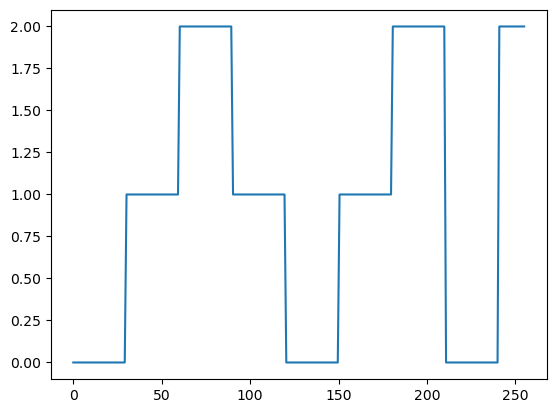

In [4]:
# the "hard" task
color_probe = np.linspace(0, 255, 255)
color_class = [color_classifier(x) for x in color_probe]
plt.plot(color_probe, color_class)

In [5]:
class ResNet(nn.Module):
    def __init__(self, conv_layers, num_classes, img_shape, path, fc_layers=[1000], groups=1):
        super().__init__()
        self.conv_layers1 = []  # entry into residual block 
        self.conv_layers2 = []  # https://arxiv.org/pdf/1512.03385.pdf Figure 3
        self.batch_norms1 = []
        self.batch_norms2 = []
        self.is_resid = []
        self.path = path
        self.num_classes = num_classes
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            if l[2] > 1: # stride
                pad_type = "valid"
                img_size = (img_size-l[1])//l[2] + 1 # https://arxiv.org/pdf/1603.07285.pdf
            else:
                pad_type = "same"
            if isinstance(l[0], float):
                l[0] = int(l[0])
                l[0] -= l[0] % groups # ensure divisble by groups
            self.is_resid.append(l[2] == 1 and channels == l[0])
            self.conv_layers1.append(nn.Conv2d(channels, l[0], l[1], stride=l[2], padding=pad_type, groups=groups))
            channels = l[0]
            self.final_num_logits = channels * img_size * img_size 
            self.batch_norms1.append(nn.BatchNorm2d(channels)) # cant use track_running_stats=False since
            self.batch_norms2.append(nn.BatchNorm2d(channels)) # it causes poor performance for inference with batch size=1 (or probably with the same image repeated a bunch of times)
            self.conv_layers2.append(nn.Conv2d(channels, channels, l[1], stride=1, padding="same", groups=groups))
        self.conv_layers1 = nn.ModuleList(self.conv_layers1)
        self.conv_layers2 = nn.ModuleList(self.conv_layers2)
        self.batch_norms1 = nn.ModuleList(self.batch_norms1)
        self.batch_norms2 = nn.ModuleList(self.batch_norms2)

        fully_connected = []
        fc_layers.insert(0, self.final_num_logits)
        fc_layers.append(num_classes)
        for fc_prev, fc_next in zip(fc_layers, fc_layers[1:]):
            fully_connected.append(nn.Linear(fc_prev, fc_next))
        self.fully_connected = nn.ModuleList(fully_connected)

    def forward(self, x, logits=False):
        network_iter = zip(self.conv_layers1, self.conv_layers2, self.batch_norms1, self.batch_norms2, self.is_resid)
        for i, (conv1, conv2, batch_norm1, batch_norm2, is_resid) in enumerate(network_iter):                
            x_conv1 = F.relu(batch_norm1(conv1(x)))
            x_conv2 = F.relu(batch_norm2(conv2(x_conv1)))
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block            
        x = torch.flatten(x, 1)
        for i, fc_layer in enumerate(self.fully_connected):
            x = fc_layer(x)
            if i != len(self.fully_connected) - 1: # dont ReLU the last one
                x = F.relu(x)            
        if self.num_classes == 1 and not logits:  # always allow returning logits
            x = torch.sigmoid(x)
        return x    

    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if optim is not None:
            save_dict = {}
            save_dict["model"] = self.state_dict()
            save_dict["optim"] = optim.state_dict()
        else:
            save_dict = self.state_dict()
        torch.save(save_dict, path)
    
    def load_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if not os.path.exists(path):
            return
        load_dict = torch.load(path)
        if "model" in load_dict:
            if optim is not None:
                optim.load_state_dict(load_dict["optim"]) 
            self.load_state_dict(load_dict["model"])
        else:
            self.load_state_dict(load_dict)

In [6]:
class ProfileExecution(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.handles = []
        
        for list_name, mod_list in self.model.named_children():
            for mod_name, mod in mod_list.named_children():
                name = f"{list_name}_{mod_name}"
                self.handles.append(mod.register_forward_hook(self.benchmark_hook(name)))
    
    def benchmark_hook(self, name):
        def fn(layer, inpt, outpt):
            benchmark(name, verbose=False)
        return fn
    
    def clean_up(self):
        for handle in self.handles:
            handle.remove()

    def forward(self, *args):
        benchmark()
        return self.model(*args)

class AllActivations(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self._features = {}
        self.handles = []

        for list_name, mod_list in self.model.named_children():
            for mod_name, mod in mod_list.named_children():
                name = f"{list_name}_{mod_name}"
                self.handles.append(mod.register_forward_hook(self.save_activations_hook(name)))

    def save_activations_hook(self, name):
        def fn(layer, inpt, output):
            self._features[name] = output
        return fn

    def clean_up(self):
        for hand in self.handles:
            handle.remove()

    def forward(self, *args):
        self.model(*args)
        return self._features

In [6]:
def correct(pred_logits, labels):
    if labels.shape[1] != 1:
        pred_probabilities = F.softmax(pred_logits, dim=1)
        classifications = torch.argmax(pred_probabilities, dim=1)
        labels_argmax = torch.argmax(labels, dim=1)
    else:
        classifications = pred_logits.int()
        labels_argmax = labels
    correct = (labels_argmax == classifications)
    return correct

def train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    va_accuracies = []
    for epoch in range(epochs):
        epoch_tr_loss = 0.0
        net.train()
        for i, sample in tqdm(enumerate(train_loader)):
            imgs = sample["image"].to(device, non_blocking=False).float()
            labels = sample["label"].to(device).float()
            optimizer.zero_grad()
            outputs = net(imgs)
            batch_loss = loss(outputs, labels)
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        epoch_va_loss = 0.0
        epoch_va_correct = 0
        net.eval()
        with torch.no_grad():
            for i, sample in enumerate(valid_loader):
                imgs = sample["image"].to(device).float()
                labels = sample["label"].to(device).float()
                outputs = net(imgs)
                epoch_va_loss += loss(outputs, labels).item()
                epoch_va_correct += correct(outputs, labels).sum().item()
        epoch_va_accuracy = epoch_va_correct/(valid_indices[1] - valid_indices[0])
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, va_accuracy: {epoch_va_accuracy}, tr_loss: {epoch_tr_loss}')
        if not va_losses or epoch_va_loss < min(va_losses):
            net.save_model_state_dict(optim=optimizer)
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
        va_accuracies.append(epoch_va_accuracy)
    return va_losses, va_accuracies, tr_losses

In [55]:
small_net = ResNet([[16, 3, 2],  # num_channels (input and output), kernel_size, stride
                    [32, 3, 2],
                    [64, 3, 2]], 3, [128, 128, 1], 
                   "small_net_noise_hard_grey.dict", fc_layers=[32]).to(device)
loss_func = nn.CrossEntropyLoss()
small_optim = torch.optim.Adam(small_net.parameters())
print(small_net.num_params())
small_net.load_model_state_dict(optim=small_optim)

533171


In [8]:
results = train(small_net, small_optim, loss_func, 1000)

977it [00:34, 27.95it/s]


Epoch 1: va_loss: 63.95993787050247, va_accuracy: 0.7452, tr_loss: 486.1124418079853


977it [00:33, 29.01it/s]


Epoch 2: va_loss: 47.582066148519516, va_accuracy: 0.7822, tr_loss: 340.64800202846527


977it [00:33, 28.92it/s]


Epoch 3: va_loss: 47.761973828077316, va_accuracy: 0.7949, tr_loss: 233.24647753685713


977it [00:33, 28.91it/s]


Epoch 4: va_loss: 15.907397031784058, va_accuracy: 0.92775, tr_loss: 194.2273837402463


977it [00:33, 28.91it/s]


Epoch 5: va_loss: 10.861001022160053, va_accuracy: 0.95055, tr_loss: 181.2226861193776


977it [00:33, 28.89it/s]


Epoch 6: va_loss: 18.820921823382378, va_accuracy: 0.89865, tr_loss: 173.11389814317226


977it [00:33, 28.89it/s]


Epoch 7: va_loss: 36.06477475166321, va_accuracy: 0.83325, tr_loss: 167.28867587447166


977it [00:33, 28.87it/s]


Epoch 8: va_loss: 9.592857129871845, va_accuracy: 0.94715, tr_loss: 159.41597591340542


977it [00:33, 28.85it/s]


Epoch 9: va_loss: 9.51905132830143, va_accuracy: 0.96115, tr_loss: 158.1571029126644


977it [00:33, 28.82it/s]


Epoch 10: va_loss: 14.068912371993065, va_accuracy: 0.9208, tr_loss: 154.17884229123592


977it [00:33, 28.81it/s]


Epoch 11: va_loss: 6.570868901908398, va_accuracy: 0.97515, tr_loss: 138.90402102470398


977it [00:33, 28.82it/s]


Epoch 12: va_loss: 44.32718551158905, va_accuracy: 0.81805, tr_loss: 138.97411774098873


977it [00:33, 28.80it/s]


Epoch 13: va_loss: 11.63763228058815, va_accuracy: 0.9484, tr_loss: 128.33380711451173


977it [00:33, 28.77it/s]


Epoch 14: va_loss: 78.29141026735306, va_accuracy: 0.74365, tr_loss: 128.0806068778038


977it [00:33, 28.78it/s]


Epoch 15: va_loss: 53.86191254854202, va_accuracy: 0.81755, tr_loss: 117.8091052994132


977it [00:33, 28.77it/s]


Epoch 16: va_loss: 7.2794911824166775, va_accuracy: 0.96365, tr_loss: 113.54085110500455


977it [00:33, 28.78it/s]


Epoch 17: va_loss: 6.780482497066259, va_accuracy: 0.9671, tr_loss: 104.67116392031312


977it [00:33, 28.78it/s]


Epoch 18: va_loss: 5.598605938255787, va_accuracy: 0.97555, tr_loss: 104.62566252052784


977it [00:33, 28.77it/s]


Epoch 19: va_loss: 11.964893490076065, va_accuracy: 0.9344, tr_loss: 97.91236294619739


977it [00:33, 28.80it/s]


Epoch 20: va_loss: 8.770230233669281, va_accuracy: 0.9544, tr_loss: 95.68912946432829


977it [00:33, 28.78it/s]


Epoch 21: va_loss: 19.90941445529461, va_accuracy: 0.91295, tr_loss: 88.71671565063298


977it [00:33, 28.77it/s]


Epoch 22: va_loss: 35.28107565641403, va_accuracy: 0.88185, tr_loss: 86.34576806798577


977it [00:33, 28.78it/s]


Epoch 23: va_loss: 19.109329842031002, va_accuracy: 0.90945, tr_loss: 87.01331433281302


977it [00:33, 28.77it/s]


Epoch 24: va_loss: 15.76465629786253, va_accuracy: 0.92065, tr_loss: 81.88235672190785


977it [00:33, 28.79it/s]


Epoch 25: va_loss: 8.063147764652967, va_accuracy: 0.9577, tr_loss: 80.43436822481453


977it [00:33, 28.78it/s]


Epoch 26: va_loss: 11.88730988651514, va_accuracy: 0.92965, tr_loss: 78.68777211755514


977it [00:33, 28.80it/s]


Epoch 27: va_loss: 124.51794534921646, va_accuracy: 0.7535, tr_loss: 76.97913330048323


977it [00:33, 28.78it/s]


Epoch 28: va_loss: 3.510248627513647, va_accuracy: 0.98395, tr_loss: 73.32000103406608


977it [00:33, 28.77it/s]


Epoch 29: va_loss: 27.26089833676815, va_accuracy: 0.90565, tr_loss: 72.51514101028442


977it [00:33, 28.77it/s]


Epoch 30: va_loss: 86.63280963897705, va_accuracy: 0.80605, tr_loss: 71.90367004461586


977it [00:33, 28.77it/s]


Epoch 31: va_loss: 3.493149420246482, va_accuracy: 0.98405, tr_loss: 69.54528490640223


977it [00:33, 28.78it/s]


Epoch 32: va_loss: 3.717185026034713, va_accuracy: 0.98415, tr_loss: 67.41951391939074


977it [00:33, 28.77it/s]


Epoch 33: va_loss: 17.519104845821857, va_accuracy: 0.90895, tr_loss: 65.40224329940975


977it [00:33, 28.76it/s]


Epoch 34: va_loss: 3.4494672287255526, va_accuracy: 0.9822, tr_loss: 67.68303886149079


977it [00:33, 28.79it/s]


Epoch 35: va_loss: 32.954653322696686, va_accuracy: 0.8898, tr_loss: 63.32043162919581


977it [00:33, 28.77it/s]


Epoch 36: va_loss: 17.276933401823044, va_accuracy: 0.93235, tr_loss: 62.68960882909596


977it [00:33, 28.78it/s]


Epoch 37: va_loss: 10.488509625196457, va_accuracy: 0.94075, tr_loss: 62.529547641053796


977it [00:33, 28.77it/s]


Epoch 38: va_loss: 6.10211231186986, va_accuracy: 0.96505, tr_loss: 58.73450665548444


977it [00:33, 28.78it/s]


Epoch 39: va_loss: 2.580416228622198, va_accuracy: 0.99025, tr_loss: 59.14390662033111


977it [00:33, 28.78it/s]


Epoch 40: va_loss: 7.356483567506075, va_accuracy: 0.9664, tr_loss: 54.92862632405013


977it [00:33, 28.77it/s]


Epoch 41: va_loss: 34.58217389881611, va_accuracy: 0.8904, tr_loss: 55.117143511772156


977it [00:33, 28.78it/s]


Epoch 42: va_loss: 3.284465130418539, va_accuracy: 0.98445, tr_loss: 53.48302392754704


977it [00:33, 28.77it/s]


Epoch 43: va_loss: 3.3580141328275204, va_accuracy: 0.98155, tr_loss: 55.570886919274926


977it [00:33, 28.75it/s]


Epoch 44: va_loss: 4.374333856627345, va_accuracy: 0.9748, tr_loss: 52.848147781565785


977it [00:33, 28.77it/s]


Epoch 45: va_loss: 3.8923224359750748, va_accuracy: 0.9779, tr_loss: 49.6721722278744


977it [00:33, 28.76it/s]


Epoch 46: va_loss: 25.546455428004265, va_accuracy: 0.9061, tr_loss: 50.25617708917707


977it [00:33, 28.77it/s]


Epoch 47: va_loss: 2.2527796868234873, va_accuracy: 0.99, tr_loss: 50.80719964765012


977it [00:33, 28.77it/s]


Epoch 48: va_loss: 1.85078601911664, va_accuracy: 0.9921, tr_loss: 48.396828341297805


977it [00:33, 28.78it/s]


Epoch 49: va_loss: 18.629742108285427, va_accuracy: 0.92065, tr_loss: 42.42756033036858


977it [00:33, 28.77it/s]


Epoch 50: va_loss: 16.950544744729996, va_accuracy: 0.9215, tr_loss: 46.93767703464255


977it [00:33, 28.78it/s]


Epoch 51: va_loss: 21.359600827097893, va_accuracy: 0.91195, tr_loss: 47.2268586717546


977it [00:33, 28.76it/s]


Epoch 52: va_loss: 5.156926279887557, va_accuracy: 0.9739, tr_loss: 42.972463329322636


977it [00:33, 28.75it/s]


Epoch 53: va_loss: 1.798684412613511, va_accuracy: 0.99425, tr_loss: 42.560243380256


977it [00:33, 28.74it/s]


Epoch 54: va_loss: 8.316712606698275, va_accuracy: 0.959, tr_loss: 41.51224880712107


977it [00:33, 28.75it/s]


Epoch 55: va_loss: 4.481292546726763, va_accuracy: 0.97465, tr_loss: 38.80920832417905


977it [00:33, 28.74it/s]


Epoch 56: va_loss: 4.935245271772146, va_accuracy: 0.97315, tr_loss: 42.27900895476341


977it [00:33, 28.75it/s]


Epoch 57: va_loss: 8.44012401252985, va_accuracy: 0.95765, tr_loss: 37.644425047561526


977it [00:33, 28.77it/s]


Epoch 58: va_loss: 3.1231853924691677, va_accuracy: 0.98385, tr_loss: 40.443653993774205


977it [00:33, 28.78it/s]


Epoch 59: va_loss: 1.7392132664099336, va_accuracy: 0.9909, tr_loss: 35.686486194841564


977it [00:33, 28.77it/s]


Epoch 60: va_loss: 26.84670463204384, va_accuracy: 0.90295, tr_loss: 34.02765431953594


977it [00:33, 28.77it/s]


Epoch 61: va_loss: 14.53988143056631, va_accuracy: 0.9431, tr_loss: 36.653478453401476


977it [00:33, 28.77it/s]


Epoch 62: va_loss: 7.611899673938751, va_accuracy: 0.95835, tr_loss: 31.753481965512037


977it [00:33, 28.77it/s]


Epoch 63: va_loss: 36.27863276004791, va_accuracy: 0.89625, tr_loss: 36.01445017103106


977it [00:33, 28.75it/s]


Epoch 64: va_loss: 1.8058814704418182, va_accuracy: 0.99115, tr_loss: 29.97217846661806


977it [00:33, 28.78it/s]


Epoch 65: va_loss: 37.17015218734741, va_accuracy: 0.87705, tr_loss: 32.23793069575913


977it [00:33, 28.78it/s]


Epoch 66: va_loss: 3.58156474865973, va_accuracy: 0.9787, tr_loss: 30.655697987647727


977it [00:33, 28.76it/s]


Epoch 67: va_loss: 11.792855056002736, va_accuracy: 0.94475, tr_loss: 32.40365827246569


977it [00:33, 28.76it/s]


Epoch 68: va_loss: 1.203133531846106, va_accuracy: 0.99445, tr_loss: 26.386108480393887


977it [00:33, 28.77it/s]


Epoch 69: va_loss: 0.960293703712523, va_accuracy: 0.9965, tr_loss: 27.05432828865014


977it [00:33, 28.76it/s]


Epoch 70: va_loss: 7.014327917248011, va_accuracy: 0.9691, tr_loss: 30.194541313685477


977it [00:33, 28.77it/s]


Epoch 71: va_loss: 1.3594954703003168, va_accuracy: 0.9933, tr_loss: 26.609717255923897


977it [00:33, 28.77it/s]


Epoch 72: va_loss: 2.5259752788115293, va_accuracy: 0.987, tr_loss: 28.98544744902756


977it [00:33, 28.78it/s]


Epoch 73: va_loss: 11.033022552728653, va_accuracy: 0.94675, tr_loss: 25.62522142054513


977it [00:33, 28.76it/s]


Epoch 74: va_loss: 6.96396710164845, va_accuracy: 0.96225, tr_loss: 25.286534720566124


977it [00:33, 28.77it/s]


Epoch 75: va_loss: 1.6702315357979387, va_accuracy: 0.99125, tr_loss: 25.324709355132654


977it [00:33, 28.77it/s]


Epoch 76: va_loss: 0.6960534519748762, va_accuracy: 0.99775, tr_loss: 22.95646423008293


977it [00:33, 28.75it/s]


Epoch 77: va_loss: 1.135311963967979, va_accuracy: 0.99545, tr_loss: 25.837567531270906


977it [00:33, 28.77it/s]


Epoch 78: va_loss: 11.60624372959137, va_accuracy: 0.9467, tr_loss: 22.54283811058849


977it [00:33, 28.78it/s]


Epoch 79: va_loss: 1.7530272635631263, va_accuracy: 0.99135, tr_loss: 23.475408655474894


977it [00:33, 28.76it/s]


Epoch 80: va_loss: 0.6044674851000309, va_accuracy: 0.9981, tr_loss: 19.735210496233776


977it [00:33, 28.78it/s]


Epoch 81: va_loss: 0.8784299676772207, va_accuracy: 0.99685, tr_loss: 23.516867045429535


977it [00:33, 28.77it/s]


Epoch 82: va_loss: 1.567745182197541, va_accuracy: 0.99245, tr_loss: 25.108743690419942


977it [00:33, 28.76it/s]


Epoch 83: va_loss: 3.4963781307451427, va_accuracy: 0.9821, tr_loss: 22.122105540242046


977it [00:33, 28.77it/s]


Epoch 84: va_loss: 7.971866280771792, va_accuracy: 0.96385, tr_loss: 20.393570465792436


977it [00:33, 28.75it/s]


Epoch 85: va_loss: 1.4340221709571779, va_accuracy: 0.9927, tr_loss: 20.79492564126849


977it [00:33, 28.76it/s]


Epoch 86: va_loss: 68.54069089889526, va_accuracy: 0.867, tr_loss: 21.219997921725735


977it [00:33, 28.77it/s]


Epoch 87: va_loss: 0.9437342763412744, va_accuracy: 0.996, tr_loss: 20.52689299848862


977it [00:33, 28.76it/s]


Epoch 88: va_loss: 0.5756269157864153, va_accuracy: 0.99775, tr_loss: 21.096362519892864


977it [00:33, 28.78it/s]


Epoch 89: va_loss: 2.2144364146515727, va_accuracy: 0.98845, tr_loss: 19.183291082503274


977it [00:33, 28.77it/s]


Epoch 90: va_loss: 38.15550434589386, va_accuracy: 0.9039, tr_loss: 18.333310658461414


977it [00:33, 28.76it/s]


Epoch 91: va_loss: 17.27473201660905, va_accuracy: 0.93925, tr_loss: 17.692713116121013


977it [00:33, 28.76it/s]


Epoch 92: va_loss: 26.78616763651371, va_accuracy: 0.9088, tr_loss: 16.91991036379477


977it [00:33, 28.77it/s]


Epoch 93: va_loss: 11.692178152501583, va_accuracy: 0.9561, tr_loss: 18.858724645571783


977it [00:33, 28.77it/s]


Epoch 94: va_loss: 1.0919900219887495, va_accuracy: 0.9953, tr_loss: 20.45024079893483


977it [00:33, 28.77it/s]


Epoch 95: va_loss: 18.2656107544899, va_accuracy: 0.93115, tr_loss: 16.35432246408891


977it [00:33, 28.75it/s]


Epoch 96: va_loss: 1.3496235853526741, va_accuracy: 0.9936, tr_loss: 17.1300851808046


977it [00:33, 28.76it/s]


Epoch 97: va_loss: 3.1762349791824818, va_accuracy: 0.98195, tr_loss: 17.8813635558472


977it [00:33, 28.76it/s]


Epoch 98: va_loss: 1.2914362584706396, va_accuracy: 0.99315, tr_loss: 16.576446277438663


977it [00:33, 28.76it/s]


Epoch 99: va_loss: 4.032776573672891, va_accuracy: 0.98025, tr_loss: 14.993957890139427


977it [00:33, 28.74it/s]


Epoch 100: va_loss: 2.807558862026781, va_accuracy: 0.98415, tr_loss: 19.26621228962904


977it [00:33, 28.75it/s]


Epoch 101: va_loss: 1.781725829001516, va_accuracy: 0.9905, tr_loss: 14.978597970650299


977it [00:33, 28.74it/s]


Epoch 102: va_loss: 1.7354244405869395, va_accuracy: 0.9903, tr_loss: 21.56860268767923


977it [00:33, 28.76it/s]


Epoch 103: va_loss: 7.154213322792202, va_accuracy: 0.96825, tr_loss: 16.518415504484437


977it [00:33, 28.76it/s]


Epoch 104: va_loss: 0.23363810864975676, va_accuracy: 0.9996, tr_loss: 11.649648344289744


977it [00:33, 28.77it/s]


Epoch 105: va_loss: 1.0293348852319468, va_accuracy: 0.994, tr_loss: 16.47044205639395


977it [00:33, 28.77it/s]


Epoch 106: va_loss: 4.54427689826116, va_accuracy: 0.97805, tr_loss: 14.53906855621608


977it [00:33, 28.77it/s]


Epoch 107: va_loss: 0.8568571913056076, va_accuracy: 0.99605, tr_loss: 13.036612516472815


977it [00:33, 28.75it/s]


Epoch 108: va_loss: 8.461051784455776, va_accuracy: 0.9609, tr_loss: 15.939373554778285


977it [00:33, 28.76it/s]


Epoch 109: va_loss: 31.26819023489952, va_accuracy: 0.9053, tr_loss: 12.966177158989012


977it [00:33, 28.76it/s]


Epoch 110: va_loss: 11.07598078250885, va_accuracy: 0.95175, tr_loss: 14.001792824652512


977it [00:33, 28.78it/s]


Epoch 111: va_loss: 4.340527287684381, va_accuracy: 0.9762, tr_loss: 14.918814474222017


977it [00:33, 28.75it/s]


Epoch 112: va_loss: 2.2391173830255866, va_accuracy: 0.9876, tr_loss: 14.486366216471652


977it [00:33, 28.77it/s]


Epoch 113: va_loss: 1.835937269963324, va_accuracy: 0.99005, tr_loss: 13.699814486608375


977it [00:33, 28.76it/s]


Epoch 114: va_loss: 0.18508045811904594, va_accuracy: 0.99965, tr_loss: 13.63492760801455


977it [00:33, 28.75it/s]


Epoch 115: va_loss: 0.720083797328698, va_accuracy: 0.997, tr_loss: 13.892002629087074


977it [00:33, 28.78it/s]


Epoch 116: va_loss: 0.4252256858017063, va_accuracy: 0.9985, tr_loss: 12.930401451099897


977it [00:33, 28.77it/s]


Epoch 117: va_loss: 104.24870479106903, va_accuracy: 0.82895, tr_loss: 13.836498983728234


977it [00:33, 28.76it/s]


Epoch 118: va_loss: 4.94546318295761, va_accuracy: 0.97415, tr_loss: 13.76295506315364


977it [00:33, 28.77it/s]


Epoch 119: va_loss: 0.26881486567435786, va_accuracy: 0.99945, tr_loss: 12.799666107690427


977it [00:33, 28.75it/s]


Epoch 120: va_loss: 30.17286777496338, va_accuracy: 0.91105, tr_loss: 14.914487478206865


977it [00:33, 28.77it/s]


Epoch 121: va_loss: 0.14158579814829864, va_accuracy: 0.9999, tr_loss: 11.89371636408032


977it [00:33, 28.76it/s]


Epoch 122: va_loss: 0.885888876626268, va_accuracy: 0.99605, tr_loss: 10.337418482027715


977it [00:33, 28.74it/s]


Epoch 123: va_loss: 0.7421629583259346, va_accuracy: 0.997, tr_loss: 10.868104779889109


977it [00:33, 28.74it/s]


Epoch 124: va_loss: 2.0611700020963326, va_accuracy: 0.9898, tr_loss: 12.65366634602833


977it [00:33, 28.75it/s]


Epoch 125: va_loss: 0.2389199014287442, va_accuracy: 0.99935, tr_loss: 12.95355778708472


977it [00:33, 28.75it/s]


Epoch 126: va_loss: 0.9938748604618013, va_accuracy: 0.995, tr_loss: 11.89782932845992


977it [00:33, 28.75it/s]


Epoch 127: va_loss: 1.142715215246426, va_accuracy: 0.9941, tr_loss: 9.88469397604058


977it [00:33, 28.79it/s]


Epoch 128: va_loss: 2.064512223005295, va_accuracy: 0.98985, tr_loss: 14.639464278545347


977it [00:33, 28.77it/s]


Epoch 129: va_loss: 0.07036101013545704, va_accuracy: 1.0, tr_loss: 9.362767584592802


977it [00:33, 28.76it/s]


Epoch 130: va_loss: 2.2296481421217322, va_accuracy: 0.98835, tr_loss: 11.446701892564306


977it [00:33, 28.76it/s]


Epoch 131: va_loss: 7.2668658420443535, va_accuracy: 0.9673, tr_loss: 13.48019657676923


977it [00:33, 28.76it/s]


Epoch 132: va_loss: 1.9173910371027887, va_accuracy: 0.99065, tr_loss: 8.947662432241486


977it [00:33, 28.76it/s]


Epoch 133: va_loss: 2.2490435839863494, va_accuracy: 0.98805, tr_loss: 10.991974653938087


977it [00:33, 28.75it/s]


Epoch 134: va_loss: 3.6379567599797156, va_accuracy: 0.98065, tr_loss: 11.797787232266273


977it [00:33, 28.76it/s]


Epoch 135: va_loss: 0.11087252665311098, va_accuracy: 0.99975, tr_loss: 10.146488037120434


977it [00:33, 28.77it/s]


Epoch 136: va_loss: 0.13418277923483402, va_accuracy: 0.99985, tr_loss: 12.168940691917669


977it [00:33, 28.76it/s]


Epoch 137: va_loss: 0.3592725397320464, va_accuracy: 0.9985, tr_loss: 10.558821358688874


977it [00:33, 28.76it/s]


Epoch 138: va_loss: 0.5795256624696776, va_accuracy: 0.99745, tr_loss: 10.55692079111759


977it [00:33, 28.77it/s]


Epoch 139: va_loss: 0.16324444460042287, va_accuracy: 0.99955, tr_loss: 11.883853805702529


977it [00:33, 28.75it/s]


Epoch 140: va_loss: 130.81128001213074, va_accuracy: 0.82405, tr_loss: 11.398206777812447


977it [00:33, 28.75it/s]


Epoch 141: va_loss: 180.446892619133, va_accuracy: 0.7849, tr_loss: 9.401959883703967


977it [00:33, 28.74it/s]


Epoch 142: va_loss: 0.3370825966121629, va_accuracy: 0.999, tr_loss: 10.190391932614148


977it [00:33, 28.76it/s]


Epoch 143: va_loss: 0.8138456443557516, va_accuracy: 0.9957, tr_loss: 10.003661339302198


977it [00:33, 28.75it/s]


Epoch 144: va_loss: 0.7402430023939814, va_accuracy: 0.9963, tr_loss: 9.345276664113044


977it [00:33, 28.75it/s]


Epoch 145: va_loss: 0.11805288940377068, va_accuracy: 0.99965, tr_loss: 11.063240075105568


977it [00:33, 28.75it/s]


Epoch 146: va_loss: 0.8884463348986174, va_accuracy: 0.9961, tr_loss: 11.010440311394632


977it [00:33, 28.75it/s]


Epoch 147: va_loss: 20.213435649871826, va_accuracy: 0.936, tr_loss: 7.995649727003183


977it [00:33, 28.76it/s]


Epoch 148: va_loss: 1.2956037793774158, va_accuracy: 0.99315, tr_loss: 10.25270494769211


977it [00:34, 28.73it/s]


Epoch 149: va_loss: 1.106535259867087, va_accuracy: 0.995, tr_loss: 13.666721047455212


977it [00:33, 28.77it/s]


Epoch 150: va_loss: 2.885673540760763, va_accuracy: 0.98425, tr_loss: 9.95388117452967


977it [00:33, 28.74it/s]


Epoch 151: va_loss: 0.21220557284686947, va_accuracy: 0.9994, tr_loss: 7.440453133298433


977it [00:33, 28.77it/s]


Epoch 152: va_loss: 2.2183723337948322, va_accuracy: 0.98765, tr_loss: 10.984958330955124


977it [00:33, 28.77it/s]


Epoch 153: va_loss: 0.12064715658198111, va_accuracy: 0.9997, tr_loss: 8.996406738413498


977it [00:33, 28.76it/s]


Epoch 154: va_loss: 0.09880255894677248, va_accuracy: 0.9999, tr_loss: 8.755411013582489


977it [00:33, 28.77it/s]


Epoch 155: va_loss: 6.788579732179642, va_accuracy: 0.97085, tr_loss: 11.900525321165333


977it [00:33, 28.76it/s]


Epoch 156: va_loss: 0.0959572090068832, va_accuracy: 0.9999, tr_loss: 9.273905465313874


977it [00:33, 28.76it/s]


Epoch 157: va_loss: 3.2114449301734567, va_accuracy: 0.98495, tr_loss: 7.166786539150053


977it [00:33, 28.76it/s]


Epoch 158: va_loss: 0.24322869931347668, va_accuracy: 0.9994, tr_loss: 11.054115478676977


977it [00:34, 28.73it/s]


Epoch 159: va_loss: 0.35499694090685807, va_accuracy: 0.99865, tr_loss: 9.529770403773


977it [00:33, 28.76it/s]


Epoch 160: va_loss: 2.911677958443761, va_accuracy: 0.9852, tr_loss: 7.220704278712219


977it [00:33, 28.76it/s]


Epoch 161: va_loss: 0.3632773676654324, va_accuracy: 0.99845, tr_loss: 10.839298919701832


977it [00:33, 28.77it/s]


Epoch 162: va_loss: 0.11542178892705124, va_accuracy: 0.9997, tr_loss: 7.240029566426529


977it [00:33, 28.74it/s]


Epoch 163: va_loss: 0.577807069174014, va_accuracy: 0.9974, tr_loss: 7.02050570139545


977it [00:33, 28.77it/s]


Epoch 164: va_loss: 2.700002851895988, va_accuracy: 0.98615, tr_loss: 10.081860963065992


977it [00:33, 28.75it/s]


Epoch 165: va_loss: 0.058625698802643456, va_accuracy: 1.0, tr_loss: 6.532242347471765


977it [00:33, 28.75it/s]


Epoch 166: va_loss: 0.6107736722624395, va_accuracy: 0.9971, tr_loss: 8.027665550660458


977it [00:33, 28.75it/s]


Epoch 167: va_loss: 4.2859539072960615, va_accuracy: 0.9793, tr_loss: 8.272659778987872


977it [00:33, 28.76it/s]


Epoch 168: va_loss: 0.24210444459458813, va_accuracy: 0.9992, tr_loss: 11.256552482067491


977it [00:33, 28.75it/s]


Epoch 169: va_loss: 0.15377916555735283, va_accuracy: 0.99975, tr_loss: 9.32836395745835


977it [00:33, 28.74it/s]


Epoch 170: va_loss: 23.08287949115038, va_accuracy: 0.92595, tr_loss: 7.463292695087148


977it [00:33, 28.76it/s]


Epoch 171: va_loss: 0.452685526033747, va_accuracy: 0.99765, tr_loss: 6.301092676803819


977it [00:33, 28.76it/s]


Epoch 172: va_loss: 6.357205279171467, va_accuracy: 0.9731, tr_loss: 10.070858644103282


977it [00:33, 28.77it/s]


Epoch 173: va_loss: 0.24936340562999249, va_accuracy: 0.99935, tr_loss: 9.01743988681119


977it [00:33, 28.77it/s]


Epoch 174: va_loss: 0.7452045344980434, va_accuracy: 0.9963, tr_loss: 7.799669160071062


977it [00:33, 28.76it/s]


Epoch 175: va_loss: 0.1326277041225694, va_accuracy: 0.9997, tr_loss: 10.93601951126766


977it [00:33, 28.78it/s]


Epoch 176: va_loss: 10.254453238099813, va_accuracy: 0.95535, tr_loss: 6.194293876775191


977it [00:34, 28.73it/s]


Epoch 177: va_loss: 0.2519389802473597, va_accuracy: 0.99905, tr_loss: 7.791507309775625


977it [00:33, 28.75it/s]


Epoch 178: va_loss: 0.16697520719026215, va_accuracy: 0.99945, tr_loss: 7.277505888450833


977it [00:33, 28.75it/s]


Epoch 179: va_loss: 4.71574586443603, va_accuracy: 0.97575, tr_loss: 7.0750996453280095


977it [00:33, 28.74it/s]


Epoch 180: va_loss: 0.6231412014458328, va_accuracy: 0.9973, tr_loss: 8.440690434581484


977it [00:33, 28.77it/s]


Epoch 181: va_loss: 0.2939013590585091, va_accuracy: 0.9986, tr_loss: 7.091152437751589


977it [00:33, 28.77it/s]


Epoch 182: va_loss: 0.06810139165281726, va_accuracy: 0.99995, tr_loss: 6.27810878038872


977it [00:33, 28.78it/s]


Epoch 183: va_loss: 0.03231942882121075, va_accuracy: 1.0, tr_loss: 9.594679757625272


977it [00:33, 28.75it/s]


Epoch 184: va_loss: 0.12184275998151861, va_accuracy: 0.99985, tr_loss: 5.822113393296604


977it [00:33, 28.76it/s]


Epoch 185: va_loss: 2.8356186165474355, va_accuracy: 0.98515, tr_loss: 7.643627265206305


977it [00:33, 28.76it/s]


Epoch 186: va_loss: 9.463411650853232, va_accuracy: 0.9644, tr_loss: 7.493402401909407


977it [00:33, 28.74it/s]


Epoch 187: va_loss: 1.1604589680209756, va_accuracy: 0.9942, tr_loss: 7.718352398267598


977it [00:33, 28.76it/s]


Epoch 188: va_loss: 0.389947128132917, va_accuracy: 0.9982, tr_loss: 6.319253103221854


977it [00:34, 28.68it/s]


Epoch 189: va_loss: 0.1610510244499892, va_accuracy: 0.99935, tr_loss: 9.928757346744533


977it [00:34, 28.70it/s]


Epoch 190: va_loss: 0.09956761944340542, va_accuracy: 0.9998, tr_loss: 6.175924647446664


977it [00:33, 28.75it/s]


Epoch 191: va_loss: 0.4848567044828087, va_accuracy: 0.9979, tr_loss: 8.626629727274121


977it [00:33, 28.78it/s]


Epoch 192: va_loss: 0.16171107323316392, va_accuracy: 0.9995, tr_loss: 7.086580991053779


977it [00:33, 28.76it/s]


Epoch 193: va_loss: 71.94693952798843, va_accuracy: 0.8719, tr_loss: 8.152462564052257


977it [00:33, 28.75it/s]


Epoch 194: va_loss: 1.9337020597304218, va_accuracy: 0.99015, tr_loss: 8.270127365489316


977it [00:33, 28.77it/s]


Epoch 195: va_loss: 0.25799984703189693, va_accuracy: 0.999, tr_loss: 3.984668762452202


977it [00:33, 28.76it/s]


Epoch 196: va_loss: 1.8563529360108078, va_accuracy: 0.9904, tr_loss: 7.191935674396518


977it [00:33, 28.76it/s]


Epoch 197: va_loss: 0.14886359765660018, va_accuracy: 0.9994, tr_loss: 8.033565253877896


977it [00:33, 28.75it/s]


Epoch 198: va_loss: 0.14502767436079012, va_accuracy: 0.99965, tr_loss: 5.591841673434828


977it [00:33, 28.76it/s]


Epoch 199: va_loss: 0.10114668690948747, va_accuracy: 0.9998, tr_loss: 9.328005364375713


977it [00:33, 28.74it/s]


Epoch 200: va_loss: 1.1626377925276756, va_accuracy: 0.9941, tr_loss: 5.515645897929062


977it [00:33, 28.76it/s]


Epoch 201: va_loss: 0.3042899389693048, va_accuracy: 0.99885, tr_loss: 5.63685049956257


977it [00:33, 28.77it/s]


Epoch 202: va_loss: 0.3829457245010417, va_accuracy: 0.9981, tr_loss: 8.835354278315208


977it [00:33, 28.74it/s]


Epoch 203: va_loss: 0.3659027730232083, va_accuracy: 0.9982, tr_loss: 4.304640613307129


977it [00:34, 28.73it/s]


Epoch 204: va_loss: 3.672160699032247, va_accuracy: 0.98335, tr_loss: 6.94646318469313


977it [00:33, 28.74it/s]


Epoch 205: va_loss: 0.42184483430173714, va_accuracy: 0.99835, tr_loss: 7.356448694379651


977it [00:33, 28.75it/s]


Epoch 206: va_loss: 25.667741315439343, va_accuracy: 0.9216, tr_loss: 6.150660280094598


977it [00:33, 28.74it/s]


Epoch 207: va_loss: 1.9514966900460422, va_accuracy: 0.9892, tr_loss: 7.71207065751878


977it [00:33, 28.76it/s]


Epoch 208: va_loss: 26.959170438349247, va_accuracy: 0.92375, tr_loss: 4.361366452707443


977it [00:33, 28.76it/s]


Epoch 209: va_loss: 0.5903933347435668, va_accuracy: 0.99775, tr_loss: 10.259073949389858


977it [00:34, 28.13it/s]


Epoch 210: va_loss: 0.13658860587020172, va_accuracy: 0.9995, tr_loss: 5.516785225991043


977it [00:33, 28.76it/s]


Epoch 211: va_loss: 0.33140827831812203, va_accuracy: 0.99875, tr_loss: 7.102290484101104


977it [00:33, 28.78it/s]


Epoch 212: va_loss: 2.901858113185881, va_accuracy: 0.98505, tr_loss: 5.928584180677717


977it [00:33, 28.76it/s]


Epoch 213: va_loss: 0.1756935275552678, va_accuracy: 0.99955, tr_loss: 5.500097915522929


977it [00:33, 28.76it/s]


Epoch 214: va_loss: 0.14883509723949828, va_accuracy: 0.99945, tr_loss: 6.247017469671846


977it [00:33, 28.77it/s]


Epoch 215: va_loss: 19.043785199522972, va_accuracy: 0.93555, tr_loss: 7.372724695020224


977it [00:33, 28.74it/s]


Epoch 216: va_loss: 0.1410873504646588, va_accuracy: 0.99965, tr_loss: 6.915254080478917


977it [00:33, 28.74it/s]


Epoch 217: va_loss: 2.7012348636053503, va_accuracy: 0.9859, tr_loss: 7.318533573776222


977it [00:34, 28.74it/s]


Epoch 218: va_loss: 0.7456697117886506, va_accuracy: 0.99665, tr_loss: 3.901667513015127


977it [00:34, 28.72it/s]


Epoch 219: va_loss: 0.2259115675551584, va_accuracy: 0.99885, tr_loss: 5.838273790985113


977it [00:33, 28.75it/s]


Epoch 220: va_loss: 0.14646782347699627, va_accuracy: 0.9995, tr_loss: 7.119723727897508


977it [00:33, 28.76it/s]


Epoch 221: va_loss: 50.13193956017494, va_accuracy: 0.8979, tr_loss: 4.932609207906353


977it [00:33, 28.77it/s]


Epoch 222: va_loss: 1.4650093982054386, va_accuracy: 0.9922, tr_loss: 4.801963930978673


977it [00:33, 28.75it/s]


Epoch 223: va_loss: 5.158680213615298, va_accuracy: 0.97885, tr_loss: 4.82538944330372


977it [00:33, 28.77it/s]


Epoch 224: va_loss: 0.15519092125759926, va_accuracy: 0.9995, tr_loss: 7.313429234978685


977it [00:33, 28.76it/s]


Epoch 225: va_loss: 0.05321481325154309, va_accuracy: 0.9999, tr_loss: 4.878420195218496


977it [00:33, 28.75it/s]


Epoch 226: va_loss: 0.34834542725002393, va_accuracy: 0.99855, tr_loss: 5.699846839535894


977it [00:33, 28.75it/s]


Epoch 227: va_loss: 0.1464147785300156, va_accuracy: 0.9994, tr_loss: 6.212582497802941


977it [00:33, 28.75it/s]


Epoch 228: va_loss: 0.030479994784400333, va_accuracy: 1.0, tr_loss: 3.4165562481393863


977it [00:34, 28.68it/s]


Epoch 229: va_loss: 0.393004360012128, va_accuracy: 0.9981, tr_loss: 5.787915097691439


977it [00:33, 28.74it/s]


Epoch 230: va_loss: 0.1582849392289063, va_accuracy: 0.99955, tr_loss: 5.851869755253574


977it [00:33, 28.75it/s]


Epoch 231: va_loss: 3.015959654469043, va_accuracy: 0.9909, tr_loss: 6.5511796019964095


977it [00:33, 28.76it/s]


Epoch 232: va_loss: 0.052918788242095616, va_accuracy: 1.0, tr_loss: 4.652039583961596


977it [00:33, 28.76it/s]


Epoch 233: va_loss: 2.5472992099821568, va_accuracy: 0.98715, tr_loss: 5.944943858883562


977it [00:33, 28.76it/s]


Epoch 234: va_loss: 12.584896445274353, va_accuracy: 0.9488, tr_loss: 6.055946639258764


977it [00:33, 28.76it/s]


Epoch 235: va_loss: 7.244391695596278, va_accuracy: 0.96925, tr_loss: 4.895608963266568


977it [00:33, 28.75it/s]


Epoch 236: va_loss: 10.77559707686305, va_accuracy: 0.95605, tr_loss: 5.255897822740735


977it [00:33, 28.75it/s]


Epoch 237: va_loss: 1.1387222340563312, va_accuracy: 0.9941, tr_loss: 5.221305821065471


977it [00:33, 28.76it/s]


Epoch 238: va_loss: 0.16353335526946466, va_accuracy: 0.99925, tr_loss: 5.915131077988917


977it [00:33, 28.76it/s]


Epoch 239: va_loss: 0.8758048746685745, va_accuracy: 0.9957, tr_loss: 5.104819431409851


977it [00:33, 28.74it/s]


Epoch 240: va_loss: 0.4477300051294151, va_accuracy: 0.9984, tr_loss: 9.959198731872675


977it [00:33, 28.74it/s]


Epoch 241: va_loss: 1.4866523002274334, va_accuracy: 0.9925, tr_loss: 4.697739144256047


977it [00:34, 28.73it/s]


Epoch 242: va_loss: 0.7516897990135476, va_accuracy: 0.99615, tr_loss: 5.400816848221439


977it [00:34, 28.71it/s]


Epoch 243: va_loss: 0.9775069210445508, va_accuracy: 0.9951, tr_loss: 3.8105921361711808


977it [00:33, 28.75it/s]


Epoch 244: va_loss: 1.1501515860436484, va_accuracy: 0.99465, tr_loss: 6.043469338776049


977it [00:33, 28.75it/s]


Epoch 245: va_loss: 2.5820570539217442, va_accuracy: 0.98695, tr_loss: 5.661195789743942


977it [00:33, 28.74it/s]


Epoch 246: va_loss: 0.5459538624854758, va_accuracy: 0.9975, tr_loss: 4.455267593977624


977it [00:33, 28.74it/s]


Epoch 247: va_loss: 0.04607157088139502, va_accuracy: 0.99985, tr_loss: 5.026551403498161


977it [00:33, 28.74it/s]


Epoch 248: va_loss: 0.16900875741339405, va_accuracy: 0.99945, tr_loss: 5.996152008017816


977it [00:33, 28.74it/s]


Epoch 249: va_loss: 0.05887738437013468, va_accuracy: 0.9999, tr_loss: 7.169919460811798


977it [00:34, 28.73it/s]


Epoch 250: va_loss: 0.17028616982861422, va_accuracy: 0.99945, tr_loss: 6.995570379665878


977it [00:34, 28.73it/s]


Epoch 251: va_loss: 0.6434188961948166, va_accuracy: 0.9967, tr_loss: 2.0137398560909787


977it [00:33, 28.74it/s]


Epoch 252: va_loss: 4.095593661186285, va_accuracy: 0.97945, tr_loss: 4.539828673663578


977it [00:34, 28.72it/s]


Epoch 253: va_loss: 0.16394754550856305, va_accuracy: 0.99935, tr_loss: 6.428914237068966


977it [00:33, 28.75it/s]


Epoch 254: va_loss: 73.74282323941588, va_accuracy: 0.8785, tr_loss: 5.256597161609534


977it [00:33, 28.76it/s]


Epoch 255: va_loss: 0.05509709843681776, va_accuracy: 0.99995, tr_loss: 4.637058848145898


977it [00:33, 28.75it/s]


Epoch 256: va_loss: 0.050512812467786716, va_accuracy: 0.9998, tr_loss: 3.896295146056218


977it [00:33, 28.75it/s]


Epoch 257: va_loss: 0.77585888242902, va_accuracy: 0.9962, tr_loss: 5.515274170740668


977it [00:33, 28.75it/s]


Epoch 258: va_loss: 0.31199292335804785, va_accuracy: 0.99845, tr_loss: 4.025745750321221


977it [00:33, 28.76it/s]


Epoch 259: va_loss: 0.04838899725291412, va_accuracy: 0.9998, tr_loss: 4.172775983461179


977it [00:33, 28.76it/s]


Epoch 260: va_loss: 0.043919539431954036, va_accuracy: 0.9999, tr_loss: 5.943684970225149


977it [00:33, 28.76it/s]


Epoch 261: va_loss: 0.5679516644158866, va_accuracy: 0.99735, tr_loss: 2.8047865393000393


977it [00:34, 28.72it/s]


Epoch 262: va_loss: 0.37465538723336067, va_accuracy: 0.9989, tr_loss: 5.52671320472291


977it [00:33, 28.76it/s]


Epoch 263: va_loss: 0.48435401398455724, va_accuracy: 0.998, tr_loss: 6.720420883670158


977it [00:33, 28.75it/s]


Epoch 264: va_loss: 0.18815879903559107, va_accuracy: 0.99925, tr_loss: 3.0842780120938187


977it [00:33, 28.74it/s]


Epoch 265: va_loss: 0.19022935011889786, va_accuracy: 0.9993, tr_loss: 6.130386816732425


977it [00:33, 28.78it/s]


Epoch 266: va_loss: 0.31009593697672244, va_accuracy: 0.99835, tr_loss: 4.774888031308365


977it [00:33, 28.74it/s]


Epoch 267: va_loss: 0.763134773929778, va_accuracy: 0.99645, tr_loss: 2.5033756485954655


977it [00:33, 28.76it/s]


Epoch 268: va_loss: 0.5631543409836013, va_accuracy: 0.9975, tr_loss: 4.954922070128305


977it [00:33, 28.75it/s]


Epoch 269: va_loss: 0.11210930632660165, va_accuracy: 0.99965, tr_loss: 7.166474655172351


977it [00:33, 28.74it/s]


Epoch 270: va_loss: 0.8805341563620459, va_accuracy: 0.9956, tr_loss: 3.479003707829179


977it [00:33, 28.76it/s]


Epoch 271: va_loss: 0.18186549670645036, va_accuracy: 0.99915, tr_loss: 4.088716037231279


977it [00:33, 28.75it/s]


Epoch 272: va_loss: 4.700553277740255, va_accuracy: 0.98355, tr_loss: 4.833318022028834


977it [00:33, 28.77it/s]


Epoch 273: va_loss: 0.7362886720511597, va_accuracy: 0.9963, tr_loss: 4.929065889464255


977it [00:33, 28.76it/s]


Epoch 274: va_loss: 0.018407512485282496, va_accuracy: 1.0, tr_loss: 3.481499296362017


977it [00:33, 28.77it/s]


Epoch 275: va_loss: 0.16290582493820693, va_accuracy: 0.99955, tr_loss: 5.234621053905357


977it [00:33, 28.74it/s]


Epoch 276: va_loss: 0.23606878548162058, va_accuracy: 0.9989, tr_loss: 4.854103911498896


977it [00:33, 28.75it/s]


Epoch 277: va_loss: 0.09042894279264146, va_accuracy: 0.9998, tr_loss: 3.923684876084735


977it [00:33, 28.76it/s]


Epoch 278: va_loss: 1.1110359260055702, va_accuracy: 0.99485, tr_loss: 5.343117053620517


977it [00:33, 28.77it/s]


Epoch 279: va_loss: 0.24438489295425825, va_accuracy: 0.99905, tr_loss: 4.853341101130354


977it [00:33, 28.75it/s]


Epoch 280: va_loss: 0.03863886960425589, va_accuracy: 0.99995, tr_loss: 6.03770786709174


977it [00:34, 28.73it/s]


Epoch 281: va_loss: 0.7544761854223907, va_accuracy: 0.99615, tr_loss: 3.2456658008868544


977it [00:33, 28.74it/s]


Epoch 282: va_loss: 1.202110513113439, va_accuracy: 0.994, tr_loss: 4.545309618435567


977it [00:33, 28.74it/s]


Epoch 283: va_loss: 0.20659190954029327, va_accuracy: 0.9991, tr_loss: 5.4237489756505965


977it [00:33, 28.76it/s]


Epoch 284: va_loss: 0.03342298245115671, va_accuracy: 0.9999, tr_loss: 4.027265890581475


977it [00:34, 28.73it/s]


Epoch 285: va_loss: 0.15132212483877083, va_accuracy: 0.99925, tr_loss: 5.289345897410385


977it [00:33, 28.76it/s]


Epoch 286: va_loss: 0.08668133000173839, va_accuracy: 0.9996, tr_loss: 3.0224363208253635


977it [00:34, 28.72it/s]


Epoch 287: va_loss: 0.3853267077138298, va_accuracy: 0.99815, tr_loss: 5.4015996196030756


977it [00:33, 28.76it/s]


Epoch 288: va_loss: 0.9196849970030598, va_accuracy: 0.9957, tr_loss: 5.194150099396211


977it [00:33, 28.74it/s]


Epoch 289: va_loss: 0.09628804563180893, va_accuracy: 0.9997, tr_loss: 3.273969509249582


977it [00:33, 28.74it/s]


Epoch 290: va_loss: 0.7808926331381372, va_accuracy: 0.9971, tr_loss: 5.352197267369775


977it [00:34, 28.72it/s]


Epoch 291: va_loss: 9.238648251455743, va_accuracy: 0.96255, tr_loss: 4.231308228418129


977it [00:33, 28.76it/s]


Epoch 292: va_loss: 0.032320963187885354, va_accuracy: 0.99995, tr_loss: 5.233326954361473


977it [00:33, 28.77it/s]


Epoch 293: va_loss: 0.10063030403398443, va_accuracy: 0.9997, tr_loss: 4.218827069249528


977it [00:33, 28.75it/s]


Epoch 294: va_loss: 2.5033287056721747, va_accuracy: 0.9876, tr_loss: 6.043461229506647


977it [00:33, 28.76it/s]


Epoch 295: va_loss: 0.09615391497209202, va_accuracy: 0.99975, tr_loss: 2.959860269418641


977it [00:33, 28.76it/s]


Epoch 296: va_loss: 0.6525493790686596, va_accuracy: 0.997, tr_loss: 3.5149064756569715


977it [00:33, 28.74it/s]


Epoch 297: va_loss: 0.14773182196586276, va_accuracy: 0.9996, tr_loss: 5.294497176113509


977it [00:33, 28.77it/s]


Epoch 298: va_loss: 0.11404320798465051, va_accuracy: 0.99965, tr_loss: 3.928563834844681


977it [00:33, 28.75it/s]


Epoch 299: va_loss: 0.06413013934616174, va_accuracy: 0.99985, tr_loss: 3.4738491985281144


977it [00:33, 28.75it/s]


Epoch 300: va_loss: 3.7734767547808588, va_accuracy: 0.9819, tr_loss: 4.728470648035909


977it [00:33, 28.76it/s]


Epoch 301: va_loss: 0.45466212421888486, va_accuracy: 0.99785, tr_loss: 3.94843222700365


977it [00:33, 28.75it/s]


Epoch 302: va_loss: 0.041171314178427565, va_accuracy: 0.9999, tr_loss: 3.502845370581781


977it [00:33, 28.74it/s]


Epoch 303: va_loss: 4.062600488050521, va_accuracy: 0.9905, tr_loss: 5.649051070645328


977it [00:33, 28.76it/s]


Epoch 304: va_loss: 0.20152117527322844, va_accuracy: 0.9991, tr_loss: 4.165787566224026


977it [00:33, 28.75it/s]


Epoch 305: va_loss: 0.11153756129351677, va_accuracy: 0.99965, tr_loss: 3.4897926221183297


977it [00:33, 28.76it/s]


Epoch 306: va_loss: 0.05262429459617124, va_accuracy: 0.9998, tr_loss: 3.7805811883081333


977it [00:33, 28.76it/s]


Epoch 307: va_loss: 0.06302123903878964, va_accuracy: 0.9998, tr_loss: 3.926533728497816


977it [00:33, 28.74it/s]


Epoch 308: va_loss: 0.0649353423359571, va_accuracy: 0.99985, tr_loss: 4.675858770169725


977it [00:33, 28.74it/s]


Epoch 309: va_loss: 5.130595780909061, va_accuracy: 0.97715, tr_loss: 4.349148999466706


977it [00:33, 28.75it/s]


Epoch 310: va_loss: 0.02718124351304141, va_accuracy: 0.99995, tr_loss: 5.452718896794977


977it [00:33, 28.76it/s]


Epoch 311: va_loss: 0.14822982523037354, va_accuracy: 0.9995, tr_loss: 3.592747494915784


977it [00:34, 28.71it/s]


Epoch 312: va_loss: 0.218244795112696, va_accuracy: 0.9992, tr_loss: 4.154326745384424


977it [00:33, 28.75it/s]


Epoch 313: va_loss: 0.4395575474227371, va_accuracy: 0.99785, tr_loss: 3.422791055448215


977it [00:34, 28.70it/s]


Epoch 314: va_loss: 1.0192705838708207, va_accuracy: 0.99475, tr_loss: 6.333875215474109


977it [00:33, 28.75it/s]


Epoch 315: va_loss: 0.03133579567656852, va_accuracy: 0.99995, tr_loss: 2.6854686988281173


977it [00:33, 28.76it/s]


Epoch 316: va_loss: 0.3312290665926412, va_accuracy: 0.99855, tr_loss: 3.4830627767987608


977it [00:34, 28.71it/s]


Epoch 317: va_loss: 0.08030912519734557, va_accuracy: 0.99965, tr_loss: 3.8472139641344256


977it [00:33, 28.76it/s]


Epoch 318: va_loss: 0.055490715857558826, va_accuracy: 0.99985, tr_loss: 3.9853897551220143


977it [00:33, 28.76it/s]


Epoch 319: va_loss: 0.08277314685983583, va_accuracy: 0.9998, tr_loss: 3.0314995639346307


977it [00:34, 28.72it/s]


Epoch 320: va_loss: 0.08730367542011663, va_accuracy: 0.99985, tr_loss: 5.752859444254682


977it [00:33, 28.74it/s]


Epoch 321: va_loss: 0.04933312412322266, va_accuracy: 0.99995, tr_loss: 3.2709828879369525


977it [00:34, 28.73it/s]


Epoch 322: va_loss: 0.18819790772977285, va_accuracy: 0.99935, tr_loss: 3.3786173977632643


977it [00:34, 28.72it/s]


Epoch 323: va_loss: 0.04831218396611803, va_accuracy: 0.9999, tr_loss: 3.2708265226528965


977it [00:33, 28.76it/s]


Epoch 324: va_loss: 0.823263862170279, va_accuracy: 0.99605, tr_loss: 6.210216249961377


977it [00:34, 28.73it/s]


Epoch 325: va_loss: 0.15529529650666518, va_accuracy: 0.99935, tr_loss: 2.3316040392091963


977it [00:33, 28.74it/s]


Epoch 326: va_loss: 0.015649940657112893, va_accuracy: 1.0, tr_loss: 3.6444673726255132


977it [00:33, 28.74it/s]


Epoch 327: va_loss: 6.983077682554722, va_accuracy: 0.97, tr_loss: 3.6829741276324057


977it [00:33, 28.76it/s]


Epoch 328: va_loss: 0.34401983857969753, va_accuracy: 0.99845, tr_loss: 3.734761852048905


977it [00:33, 28.74it/s]


Epoch 329: va_loss: 0.03440463095830637, va_accuracy: 0.99995, tr_loss: 4.314975626912201


977it [00:33, 28.75it/s]


Epoch 330: va_loss: 0.06628737768551218, va_accuracy: 0.9998, tr_loss: 3.231990091038824


977it [00:33, 28.76it/s]


Epoch 331: va_loss: 0.013621786634757882, va_accuracy: 1.0, tr_loss: 5.0465383267255675


977it [00:33, 28.75it/s]


Epoch 332: va_loss: 1.344627111851878, va_accuracy: 0.9929, tr_loss: 3.3483584919958957


977it [00:33, 28.75it/s]


Epoch 333: va_loss: 0.04919779951706005, va_accuracy: 1.0, tr_loss: 2.8901066308671943


977it [00:33, 28.75it/s]


Epoch 334: va_loss: 0.030881664559274213, va_accuracy: 1.0, tr_loss: 4.096530661147881


977it [00:34, 28.73it/s]


Epoch 335: va_loss: 0.1587585485249292, va_accuracy: 0.9996, tr_loss: 6.357404516953466


977it [00:33, 28.75it/s]


Epoch 336: va_loss: 3.527803903678432, va_accuracy: 0.9845, tr_loss: 2.1554207767985645


977it [00:33, 28.75it/s]


Epoch 337: va_loss: 0.06399628920553369, va_accuracy: 0.9998, tr_loss: 3.2648243862522577


977it [00:33, 28.74it/s]


Epoch 338: va_loss: 2.7883527351077646, va_accuracy: 0.9869, tr_loss: 3.6053771662445797


977it [00:34, 28.73it/s]


Epoch 339: va_loss: 0.9677119733532891, va_accuracy: 0.99485, tr_loss: 3.158581106166821


977it [00:33, 28.75it/s]


Epoch 340: va_loss: 0.08714385762505117, va_accuracy: 0.9997, tr_loss: 3.7093938170564797


977it [00:33, 28.75it/s]


Epoch 341: va_loss: 0.0755406582429714, va_accuracy: 0.99975, tr_loss: 4.27491753123104


977it [00:33, 28.75it/s]


Epoch 342: va_loss: 0.007610713169924566, va_accuracy: 1.0, tr_loss: 3.3112810638558585


977it [00:34, 28.73it/s]


Epoch 343: va_loss: 0.047040334404300665, va_accuracy: 0.99985, tr_loss: 4.38757096667814


977it [00:33, 28.74it/s]


Epoch 344: va_loss: 7.373302590101957, va_accuracy: 0.966, tr_loss: 4.058044666566275


977it [00:33, 28.75it/s]


Epoch 345: va_loss: 0.09585611936199712, va_accuracy: 0.9996, tr_loss: 4.558427538736396


977it [00:33, 28.74it/s]


Epoch 346: va_loss: 0.1063002649898408, va_accuracy: 0.9997, tr_loss: 2.522845713128845


977it [00:34, 28.72it/s]


Epoch 347: va_loss: 9.426799637260046, va_accuracy: 0.96585, tr_loss: 3.9996683369317907


977it [00:34, 28.73it/s]


Epoch 348: va_loss: 1.285065146861598, va_accuracy: 0.99425, tr_loss: 4.443392151856642


977it [00:33, 28.76it/s]


Epoch 349: va_loss: 0.13947609918068338, va_accuracy: 0.999, tr_loss: 3.4606643776824058


977it [00:33, 28.75it/s]


Epoch 350: va_loss: 0.16312964132521302, va_accuracy: 0.9994, tr_loss: 3.2462007698804882


977it [00:33, 28.75it/s]


Epoch 351: va_loss: 0.04526488323972444, va_accuracy: 0.9999, tr_loss: 3.7004866465140367


977it [00:33, 28.76it/s]


Epoch 352: va_loss: 0.027792486646831094, va_accuracy: 0.99995, tr_loss: 4.212777482855017


977it [00:34, 28.73it/s]


Epoch 353: va_loss: 0.21951324986366672, va_accuracy: 0.99905, tr_loss: 3.221577261757375


977it [00:33, 28.74it/s]


Epoch 354: va_loss: 0.12415826943288266, va_accuracy: 0.99965, tr_loss: 3.2863895172067714


977it [00:33, 28.76it/s]


Epoch 355: va_loss: 0.5024407580494881, va_accuracy: 0.99765, tr_loss: 1.831035568660809


977it [00:34, 28.71it/s]


Epoch 356: va_loss: 0.06396591217526293, va_accuracy: 0.9998, tr_loss: 4.979567433390912


977it [00:33, 28.75it/s]


Epoch 357: va_loss: 0.3793847029519384, va_accuracy: 0.99845, tr_loss: 2.235719305211205


977it [00:34, 28.72it/s]


Epoch 358: va_loss: 1.0504569476470351, va_accuracy: 0.99475, tr_loss: 3.9498802121624976


977it [00:33, 28.74it/s]


Epoch 359: va_loss: 0.01140331614533352, va_accuracy: 1.0, tr_loss: 2.8283118799545264


977it [00:34, 28.73it/s]


Epoch 360: va_loss: 0.07869524779562198, va_accuracy: 0.9998, tr_loss: 3.5105990494557773


977it [00:33, 28.74it/s]


Epoch 361: va_loss: 0.022992180763139913, va_accuracy: 1.0, tr_loss: 3.066720022528898


977it [00:34, 28.73it/s]


Epoch 362: va_loss: 1.2840577017050236, va_accuracy: 0.9933, tr_loss: 3.076406626861626


977it [00:34, 28.72it/s]


Epoch 363: va_loss: 0.09123236143932445, va_accuracy: 0.99975, tr_loss: 6.0433616934860765


977it [00:33, 28.75it/s]


Epoch 364: va_loss: 0.014147972450700763, va_accuracy: 1.0, tr_loss: 1.9637868673153207


977it [00:33, 28.75it/s]


Epoch 365: va_loss: 0.13292946678620865, va_accuracy: 0.9995, tr_loss: 2.895015373987917


977it [00:33, 28.74it/s]


Epoch 366: va_loss: 6.393759768456221, va_accuracy: 0.98065, tr_loss: 5.500143729315823


977it [00:33, 28.74it/s]


Epoch 367: va_loss: 0.04653241764935956, va_accuracy: 0.9999, tr_loss: 2.6899794286609904


977it [00:33, 28.74it/s]


Epoch 368: va_loss: 1.4567342069931328, va_accuracy: 0.99255, tr_loss: 3.6528084979627238


977it [00:33, 28.74it/s]


Epoch 369: va_loss: 0.2957571515653399, va_accuracy: 0.99885, tr_loss: 4.286363205670568


977it [00:34, 28.73it/s]


Epoch 370: va_loss: 0.018484344782336848, va_accuracy: 1.0, tr_loss: 4.2014031381077075


977it [00:34, 28.67it/s]


Epoch 371: va_loss: 0.03819427967118827, va_accuracy: 0.99995, tr_loss: 2.9353975621015707


977it [00:34, 28.71it/s]


Epoch 372: va_loss: 0.2032728919220972, va_accuracy: 0.9993, tr_loss: 3.9134042103905813


977it [00:33, 28.74it/s]


Epoch 373: va_loss: 0.035770711374425446, va_accuracy: 0.99995, tr_loss: 2.7306326878861


977it [00:34, 28.73it/s]


Epoch 374: va_loss: 0.11516322974784998, va_accuracy: 0.9996, tr_loss: 2.0867443383376667


977it [00:34, 28.71it/s]


Epoch 375: va_loss: 3.262157663702965, va_accuracy: 0.98535, tr_loss: 4.337585625673455


977it [00:34, 28.70it/s]


Epoch 376: va_loss: 0.11298757077747723, va_accuracy: 0.99955, tr_loss: 3.4710415204190213


977it [00:34, 28.68it/s]


Epoch 377: va_loss: 0.10235983447637409, va_accuracy: 0.99965, tr_loss: 2.0725916959891038


977it [00:34, 28.68it/s]


Epoch 378: va_loss: 0.020949409885361092, va_accuracy: 0.99995, tr_loss: 3.3172621872463424


977it [00:34, 28.60it/s]


Epoch 379: va_loss: 0.1646890517877182, va_accuracy: 0.99945, tr_loss: 4.012832314584557


977it [00:34, 28.71it/s]


Epoch 380: va_loss: 1.473071583066485, va_accuracy: 0.99255, tr_loss: 2.787974084565576


977it [00:34, 28.73it/s]


Epoch 381: va_loss: 0.1948188895767089, va_accuracy: 0.99915, tr_loss: 3.5647407584074244


977it [00:34, 28.73it/s]


Epoch 382: va_loss: 0.045920432603452355, va_accuracy: 0.9999, tr_loss: 3.2730912189035735


977it [00:34, 28.45it/s]


Epoch 383: va_loss: 6.933416750282049, va_accuracy: 0.9719, tr_loss: 4.574715008387102


977it [00:34, 28.65it/s]


Epoch 384: va_loss: 0.044879779740767844, va_accuracy: 0.9998, tr_loss: 2.1222200759375482


977it [00:34, 28.67it/s]


Epoch 385: va_loss: 0.05921170278634236, va_accuracy: 0.9997, tr_loss: 4.638293697444169


977it [00:34, 28.66it/s]


Epoch 386: va_loss: 0.23104398680879967, va_accuracy: 0.99925, tr_loss: 1.8964784421204968


977it [00:34, 28.56it/s]


Epoch 387: va_loss: 0.19190387477647164, va_accuracy: 0.99905, tr_loss: 4.1369305242596965


977it [00:34, 28.65it/s]


Epoch 388: va_loss: 0.02489003575192328, va_accuracy: 0.9999, tr_loss: 2.728655927755426


977it [00:33, 28.74it/s]


Epoch 389: va_loss: 0.01811963558429852, va_accuracy: 1.0, tr_loss: 2.161397291622052


977it [00:34, 28.71it/s]


Epoch 390: va_loss: 0.02280146820066875, va_accuracy: 0.99995, tr_loss: 3.399843240114933


977it [00:34, 28.73it/s]


Epoch 391: va_loss: 0.09648117189863115, va_accuracy: 0.9997, tr_loss: 4.32130436859461


977it [00:34, 28.71it/s]


Epoch 392: va_loss: 1.273592978483066, va_accuracy: 0.99405, tr_loss: 2.530728272665783


977it [00:34, 28.70it/s]


Epoch 393: va_loss: 29.38642594218254, va_accuracy: 0.9217, tr_loss: 2.503624866035352


977it [00:34, 28.73it/s]


Epoch 394: va_loss: 0.03127225211028417, va_accuracy: 0.99995, tr_loss: 1.8274171221078177


977it [00:33, 28.74it/s]


Epoch 395: va_loss: 2.116677386686206, va_accuracy: 0.99055, tr_loss: 5.409479562131764


977it [00:34, 28.73it/s]


Epoch 396: va_loss: 0.15412758453021524, va_accuracy: 0.9995, tr_loss: 2.243147852632319


977it [00:34, 28.73it/s]


Epoch 397: va_loss: 0.07949321115302155, va_accuracy: 0.9997, tr_loss: 2.3781988664550227


977it [00:34, 28.73it/s]


Epoch 398: va_loss: 0.060467075881206256, va_accuracy: 0.99975, tr_loss: 4.845686558090165


977it [00:34, 28.73it/s]


Epoch 399: va_loss: 0.035410001830314286, va_accuracy: 0.99985, tr_loss: 1.6272811282383373


977it [00:33, 28.75it/s]


Epoch 400: va_loss: 0.08031163111809292, va_accuracy: 0.9997, tr_loss: 3.844384145158074


977it [00:34, 28.73it/s]


Epoch 401: va_loss: 0.04801687917279196, va_accuracy: 0.9998, tr_loss: 5.596474466081418


977it [00:34, 28.72it/s]


Epoch 402: va_loss: 0.01623650156034273, va_accuracy: 0.9999, tr_loss: 1.7713659299161009


977it [00:34, 28.71it/s]


Epoch 403: va_loss: 0.12963693608799076, va_accuracy: 0.99965, tr_loss: 2.049305545900097


977it [00:34, 28.71it/s]


Epoch 404: va_loss: 0.07640645964011128, va_accuracy: 0.9997, tr_loss: 4.478384037734941


977it [00:33, 28.75it/s]


Epoch 405: va_loss: 0.026596336878355942, va_accuracy: 0.9999, tr_loss: 1.557067503241342


977it [00:34, 28.71it/s]


Epoch 406: va_loss: 0.32162371833692305, va_accuracy: 0.9987, tr_loss: 3.6363498209784666


977it [00:33, 28.74it/s]


Epoch 407: va_loss: 0.08334462285279187, va_accuracy: 0.99965, tr_loss: 2.5210072323625354


977it [00:33, 28.74it/s]


Epoch 408: va_loss: 0.6823965429957752, va_accuracy: 0.997, tr_loss: 4.437649788636918


977it [00:34, 28.70it/s]


Epoch 409: va_loss: 0.0777052769662987, va_accuracy: 0.9998, tr_loss: 4.4054388255690355


977it [00:33, 28.74it/s]


Epoch 410: va_loss: 0.01086606536864565, va_accuracy: 1.0, tr_loss: 1.7308192358204906


977it [00:34, 28.72it/s]


Epoch 411: va_loss: 0.031861860339631676, va_accuracy: 0.99995, tr_loss: 2.8345701928083145


977it [00:34, 28.70it/s]


Epoch 412: va_loss: 0.02499046843695396, va_accuracy: 0.9999, tr_loss: 3.214133516092261


977it [00:34, 28.68it/s]


Epoch 413: va_loss: 0.7743628010211978, va_accuracy: 0.99605, tr_loss: 2.353506482632838


977it [00:34, 28.71it/s]


Epoch 414: va_loss: 4.317834367742762, va_accuracy: 0.9861, tr_loss: 3.2352340044335506


977it [00:33, 28.75it/s]


Epoch 415: va_loss: 0.12368443954892427, va_accuracy: 0.99975, tr_loss: 3.04724557163172


977it [00:33, 28.75it/s]


Epoch 416: va_loss: 0.47727269293682184, va_accuracy: 0.9983, tr_loss: 2.028773860532965


977it [00:34, 28.73it/s]


Epoch 417: va_loss: 4.0084407646209, va_accuracy: 0.98235, tr_loss: 4.936080231192136


977it [00:33, 28.74it/s]


Epoch 418: va_loss: 0.016542494489385717, va_accuracy: 0.99995, tr_loss: 3.3814570641388855


977it [00:33, 28.74it/s]


Epoch 419: va_loss: 0.06950087668701599, va_accuracy: 0.9998, tr_loss: 1.5366291079735674


977it [00:33, 28.75it/s]


Epoch 420: va_loss: 0.270758375962032, va_accuracy: 0.99855, tr_loss: 4.521982677541928


977it [00:34, 28.73it/s]


Epoch 421: va_loss: 0.03249749739188701, va_accuracy: 1.0, tr_loss: 3.5862992253014454


977it [00:34, 28.71it/s]


Epoch 422: va_loss: 0.00751094533734431, va_accuracy: 1.0, tr_loss: 2.02407192980354


977it [00:33, 28.75it/s]


Epoch 423: va_loss: 0.022882251893861394, va_accuracy: 1.0, tr_loss: 1.950769090324684


977it [00:34, 28.68it/s]


Epoch 424: va_loss: 0.025530250666633947, va_accuracy: 1.0, tr_loss: 2.835729670990986


977it [00:34, 28.73it/s]


Epoch 425: va_loss: 0.08716182833995845, va_accuracy: 0.99975, tr_loss: 2.8141941773469625


977it [00:34, 28.69it/s]


Epoch 426: va_loss: 0.0361158350902997, va_accuracy: 0.99985, tr_loss: 2.9979997524342252


977it [00:34, 28.70it/s]


Epoch 427: va_loss: 0.06932211587263737, va_accuracy: 0.99975, tr_loss: 3.0007426502438648


977it [00:34, 28.73it/s]


Epoch 428: va_loss: 0.21083695848938078, va_accuracy: 0.99925, tr_loss: 2.554519636365967


977it [00:33, 28.75it/s]


Epoch 429: va_loss: 0.24087761082319048, va_accuracy: 0.9988, tr_loss: 2.1646056598565337


977it [00:33, 28.75it/s]


Epoch 430: va_loss: 0.01846351472886454, va_accuracy: 0.99995, tr_loss: 4.7552493690782285


977it [00:34, 28.73it/s]


Epoch 431: va_loss: 0.011697971466674062, va_accuracy: 1.0, tr_loss: 2.0844354680775723


977it [00:33, 28.75it/s]


Epoch 432: va_loss: 0.1357055625267094, va_accuracy: 0.9995, tr_loss: 3.729015403692756


977it [00:33, 28.74it/s]


Epoch 433: va_loss: 0.038486039122290094, va_accuracy: 0.99995, tr_loss: 2.0166566291645722


977it [00:34, 28.73it/s]


Epoch 434: va_loss: 0.5364222820280702, va_accuracy: 0.9974, tr_loss: 1.3695530407410388


977it [00:34, 28.71it/s]


Epoch 435: va_loss: 0.036101813754157774, va_accuracy: 0.99985, tr_loss: 3.236719764717236


977it [00:33, 28.74it/s]


Epoch 436: va_loss: 0.5189336949551944, va_accuracy: 0.9977, tr_loss: 4.456106692132835


977it [00:34, 28.73it/s]


Epoch 437: va_loss: 0.11045159453351516, va_accuracy: 0.9997, tr_loss: 4.978554454636651


977it [00:33, 28.74it/s]


Epoch 438: va_loss: 0.286690851993626, va_accuracy: 0.99875, tr_loss: 1.0554627860583423


977it [00:33, 28.75it/s]


Epoch 439: va_loss: 0.03934427949934616, va_accuracy: 0.99995, tr_loss: 2.1977875417005635


977it [00:34, 28.73it/s]


Epoch 440: va_loss: 0.1540658697647359, va_accuracy: 0.99935, tr_loss: 3.2728135494289745


977it [00:33, 28.74it/s]


Epoch 441: va_loss: 0.09684152726549655, va_accuracy: 0.9995, tr_loss: 2.489704161548616


977it [00:34, 28.72it/s]


Epoch 442: va_loss: 0.1330141078469751, va_accuracy: 0.99935, tr_loss: 2.2816051193299245


977it [00:34, 28.72it/s]


Epoch 443: va_loss: 0.0312752846366493, va_accuracy: 0.9999, tr_loss: 3.715989785124293


977it [00:33, 28.74it/s]


Epoch 444: va_loss: 0.03333158820987592, va_accuracy: 0.9999, tr_loss: 2.9114805577678453


977it [00:33, 28.74it/s]


Epoch 445: va_loss: 1.5088999713771045, va_accuracy: 0.99335, tr_loss: 3.709541294041628


977it [00:33, 28.74it/s]


Epoch 446: va_loss: 0.12117630915963673, va_accuracy: 0.99965, tr_loss: 1.7225735295714912


977it [00:34, 28.73it/s]


Epoch 447: va_loss: 0.09712913467410544, va_accuracy: 0.99965, tr_loss: 2.816772908178791


977it [00:33, 28.74it/s]


Epoch 448: va_loss: 0.1395893289131891, va_accuracy: 0.9994, tr_loss: 4.251941560978594


977it [00:33, 28.74it/s]


Epoch 449: va_loss: 0.07249864494224312, va_accuracy: 0.99985, tr_loss: 4.608595450057692


977it [00:34, 28.72it/s]


Epoch 450: va_loss: 0.033306209807051346, va_accuracy: 0.99985, tr_loss: 1.1212642941263766


977it [00:34, 28.72it/s]


Epoch 451: va_loss: 0.006503623704702477, va_accuracy: 1.0, tr_loss: 1.3755719303735532


977it [00:33, 28.74it/s]


Epoch 452: va_loss: 0.012037608373248077, va_accuracy: 0.99995, tr_loss: 2.8971424973469766


977it [00:33, 28.75it/s]


Epoch 453: va_loss: 0.024511211614481, va_accuracy: 0.99985, tr_loss: 3.232319572484357


977it [00:33, 28.76it/s]


Epoch 454: va_loss: 7.72067566215992, va_accuracy: 0.9674, tr_loss: 3.69483106411235


977it [00:34, 28.73it/s]


Epoch 455: va_loss: 0.034559306560026926, va_accuracy: 0.99995, tr_loss: 3.105845333027901


977it [00:33, 28.74it/s]


Epoch 456: va_loss: 0.02750614099750237, va_accuracy: 0.99995, tr_loss: 2.1327579134326697


977it [00:33, 28.74it/s]


Epoch 457: va_loss: 0.6209684642963111, va_accuracy: 0.9969, tr_loss: 2.8570871634146897


977it [00:34, 28.72it/s]


Epoch 458: va_loss: 0.0077555019825013005, va_accuracy: 1.0, tr_loss: 2.6907522263381907


977it [00:33, 28.74it/s]


Epoch 459: va_loss: 0.06439666152618884, va_accuracy: 0.99975, tr_loss: 3.384892348196445


977it [00:34, 28.72it/s]


Epoch 460: va_loss: 0.138781081183879, va_accuracy: 0.9996, tr_loss: 2.864122041243718


977it [00:34, 28.71it/s]


Epoch 461: va_loss: 0.20408518229669426, va_accuracy: 0.9993, tr_loss: 2.7485396207430313


977it [00:34, 28.73it/s]


Epoch 462: va_loss: 0.04178577916513859, va_accuracy: 0.99985, tr_loss: 1.8951520051432453


977it [00:33, 28.74it/s]


Epoch 463: va_loss: 0.16915266767682624, va_accuracy: 0.99935, tr_loss: 2.899384967849983


977it [00:34, 28.71it/s]


Epoch 464: va_loss: 0.12225970062718261, va_accuracy: 0.99945, tr_loss: 3.1527109549588204


977it [00:34, 28.73it/s]


Epoch 465: va_loss: 0.03854716709247441, va_accuracy: 0.9999, tr_loss: 1.728930252103055


977it [00:34, 28.72it/s]


Epoch 466: va_loss: 0.05548773110194816, va_accuracy: 0.99975, tr_loss: 3.5597742797167484


977it [00:34, 28.73it/s]


Epoch 467: va_loss: 0.05513107580736687, va_accuracy: 0.99985, tr_loss: 3.5997669380785737


977it [00:33, 28.74it/s]


Epoch 468: va_loss: 0.009628832809767118, va_accuracy: 1.0, tr_loss: 2.330200894050904


977it [00:34, 28.73it/s]


Epoch 469: va_loss: 0.6461546527134487, va_accuracy: 0.99725, tr_loss: 2.679710268555027


977it [00:34, 28.73it/s]


Epoch 470: va_loss: 41.022506423294544, va_accuracy: 0.91225, tr_loss: 2.5663688699187333


977it [00:34, 28.72it/s]


Epoch 471: va_loss: 0.01862292176235769, va_accuracy: 0.99995, tr_loss: 2.6830866574814536


977it [00:34, 28.73it/s]


Epoch 472: va_loss: 0.04184635322417307, va_accuracy: 0.9998, tr_loss: 2.5660103117961626


977it [00:34, 28.73it/s]


Epoch 473: va_loss: 0.016355845704310923, va_accuracy: 0.99995, tr_loss: 2.2841625301362


977it [00:33, 28.74it/s]


Epoch 474: va_loss: 0.009619390799230132, va_accuracy: 1.0, tr_loss: 2.250205519060728


977it [00:33, 28.74it/s]


Epoch 475: va_loss: 252.77064418792725, va_accuracy: 0.78695, tr_loss: 1.718279956155584


977it [00:34, 28.71it/s]


Epoch 476: va_loss: 0.3235299739171751, va_accuracy: 0.9988, tr_loss: 3.8207011701852025


977it [00:33, 28.74it/s]


Epoch 477: va_loss: 0.2698227854416473, va_accuracy: 0.99905, tr_loss: 2.74301649522522


977it [00:33, 28.74it/s]


Epoch 478: va_loss: 0.006448275471484521, va_accuracy: 1.0, tr_loss: 2.0297395684729054


977it [00:34, 28.73it/s]


Epoch 479: va_loss: 2.097501361888135, va_accuracy: 0.9916, tr_loss: 2.5635272434046783


977it [00:34, 28.73it/s]


Epoch 480: va_loss: 0.006210137647485681, va_accuracy: 1.0, tr_loss: 2.5246859402986956


977it [00:34, 28.73it/s]


Epoch 481: va_loss: 0.05234936477773999, va_accuracy: 0.9999, tr_loss: 2.78760324899622


977it [00:34, 28.72it/s]


Epoch 482: va_loss: 0.06208059503842378, va_accuracy: 0.99995, tr_loss: 3.5611640564638947


977it [00:33, 28.74it/s]


Epoch 483: va_loss: 0.014521129546665179, va_accuracy: 0.99995, tr_loss: 1.7104874026858852


977it [00:33, 28.74it/s]


Epoch 484: va_loss: 0.4153196165279951, va_accuracy: 0.99785, tr_loss: 3.77132078559589


977it [00:34, 28.72it/s]


Epoch 485: va_loss: 0.04624015331319242, va_accuracy: 0.99985, tr_loss: 1.661833727222529


977it [00:34, 28.72it/s]


Epoch 486: va_loss: 0.2578652648298885, va_accuracy: 0.9992, tr_loss: 2.3814862487020036


977it [00:33, 28.75it/s]


Epoch 487: va_loss: 0.01187718465916987, va_accuracy: 1.0, tr_loss: 3.4399654621474838


977it [00:33, 28.74it/s]


Epoch 488: va_loss: 0.011699026204951224, va_accuracy: 1.0, tr_loss: 1.9632559204383142


977it [00:34, 28.72it/s]


Epoch 489: va_loss: 0.17066051656001946, va_accuracy: 0.99945, tr_loss: 1.6345517016884514


977it [00:33, 28.75it/s]


Epoch 490: va_loss: 0.2832134613345261, va_accuracy: 0.9986, tr_loss: 3.806641430367563


977it [00:34, 28.73it/s]


Epoch 491: va_loss: 0.295400230515952, va_accuracy: 0.99845, tr_loss: 1.2727271612420736


977it [00:34, 28.73it/s]


Epoch 492: va_loss: 0.08323626387118566, va_accuracy: 0.9998, tr_loss: 3.4669023418168763


977it [00:34, 28.73it/s]


Epoch 493: va_loss: 0.005676978498740937, va_accuracy: 1.0, tr_loss: 2.704146166573082


977it [00:34, 28.72it/s]


Epoch 494: va_loss: 0.32327532696945127, va_accuracy: 0.99875, tr_loss: 2.1259768491759132


977it [00:34, 28.72it/s]


Epoch 495: va_loss: 0.030776713795603428, va_accuracy: 0.99995, tr_loss: 2.2667776244206834


977it [00:34, 28.74it/s]


Epoch 496: va_loss: 0.025851994642835052, va_accuracy: 0.9999, tr_loss: 5.206972706829674


977it [00:34, 28.73it/s]


Epoch 497: va_loss: 0.014694961775603588, va_accuracy: 1.0, tr_loss: 2.535483480748553


977it [00:34, 28.53it/s]


Epoch 498: va_loss: 0.23553900040496956, va_accuracy: 0.99895, tr_loss: 1.4513199031143813


977it [00:34, 28.73it/s]


Epoch 499: va_loss: 0.02847414363805001, va_accuracy: 0.99995, tr_loss: 3.845319624802869


977it [00:33, 28.74it/s]


Epoch 500: va_loss: 0.0063692220546727185, va_accuracy: 1.0, tr_loss: 1.3302061576387132


977it [00:33, 28.75it/s]


Epoch 501: va_loss: 0.023343196919995535, va_accuracy: 0.9999, tr_loss: 2.1336967598676893


977it [00:33, 28.75it/s]


Epoch 502: va_loss: 0.039245560259587364, va_accuracy: 0.9999, tr_loss: 2.58665879209002


977it [00:33, 28.76it/s]


Epoch 503: va_loss: 0.011689411051520437, va_accuracy: 0.99995, tr_loss: 3.952677055010099


977it [00:33, 28.74it/s]


Epoch 504: va_loss: 0.0044588237133211805, va_accuracy: 1.0, tr_loss: 1.3560799533165664


977it [00:33, 28.77it/s]


Epoch 505: va_loss: 0.04214531512843678, va_accuracy: 0.9999, tr_loss: 2.6850367553875003


977it [00:34, 28.73it/s]


Epoch 506: va_loss: 59.295803010463715, va_accuracy: 0.90575, tr_loss: 2.110127341964926


977it [00:33, 28.76it/s]


Epoch 507: va_loss: 0.09449805258918786, va_accuracy: 0.99975, tr_loss: 2.0322204410686027


977it [00:34, 28.73it/s]


Epoch 508: va_loss: 0.37407199355220655, va_accuracy: 0.99825, tr_loss: 3.0709979552138975


977it [00:33, 28.75it/s]


Epoch 509: va_loss: 0.26378395596839255, va_accuracy: 0.9988, tr_loss: 2.2502791544229694


977it [00:33, 28.74it/s]


Epoch 510: va_loss: 3.04919589497149, va_accuracy: 0.9879, tr_loss: 3.608404811998753


977it [00:33, 28.75it/s]


Epoch 511: va_loss: 0.01779793055857226, va_accuracy: 1.0, tr_loss: 1.8978099886790005


977it [00:33, 28.74it/s]


Epoch 512: va_loss: 0.012652812969463412, va_accuracy: 1.0, tr_loss: 4.306235094348267


977it [00:33, 28.75it/s]


Epoch 513: va_loss: 0.006367547105583071, va_accuracy: 1.0, tr_loss: 1.7525255540376747


977it [00:34, 28.73it/s]


Epoch 514: va_loss: 0.018287568886989902, va_accuracy: 1.0, tr_loss: 1.5749831475395695


977it [00:33, 28.74it/s]


Epoch 515: va_loss: 0.012044230407354917, va_accuracy: 1.0, tr_loss: 2.454916523369775


977it [00:34, 28.73it/s]


Epoch 516: va_loss: 0.008190554016891838, va_accuracy: 0.99995, tr_loss: 2.8438140452494736


977it [00:34, 28.71it/s]


Epoch 517: va_loss: 0.15544872009922983, va_accuracy: 0.9994, tr_loss: 2.0134305483707067


977it [00:33, 28.74it/s]


Epoch 518: va_loss: 0.5485701036814135, va_accuracy: 0.9978, tr_loss: 2.225629548025154


977it [00:34, 28.70it/s]


Epoch 519: va_loss: 0.030771893925702898, va_accuracy: 1.0, tr_loss: 5.199129923594228


977it [00:34, 28.65it/s]


Epoch 520: va_loss: 0.00413151848670168, va_accuracy: 1.0, tr_loss: 1.163563686481666


977it [00:34, 28.65it/s]


Epoch 521: va_loss: 0.028860735279977234, va_accuracy: 0.9999, tr_loss: 2.3879070542029694


977it [00:34, 28.73it/s]


Epoch 522: va_loss: 0.13576075163746282, va_accuracy: 0.9995, tr_loss: 2.2955342777577243


977it [00:34, 28.73it/s]


Epoch 523: va_loss: 0.04867327189367643, va_accuracy: 0.9999, tr_loss: 1.512227772344886


977it [00:34, 28.64it/s]


Epoch 524: va_loss: 7.348781058564782, va_accuracy: 0.97475, tr_loss: 1.8190652865691845


977it [00:34, 28.68it/s]


Epoch 525: va_loss: 0.09471828927962633, va_accuracy: 0.9996, tr_loss: 3.4010990798087732


977it [00:34, 28.72it/s]


Epoch 526: va_loss: 0.07758673718217324, va_accuracy: 0.9997, tr_loss: 1.446666252014893


977it [00:34, 28.68it/s]


Epoch 527: va_loss: 0.017611426651910733, va_accuracy: 0.99995, tr_loss: 1.7943184176658633


977it [00:34, 28.67it/s]


Epoch 528: va_loss: 0.2959435978173133, va_accuracy: 0.9986, tr_loss: 3.0204403819993786


977it [00:33, 28.75it/s]


Epoch 529: va_loss: 0.009990583976104972, va_accuracy: 1.0, tr_loss: 2.3110828782409953


977it [00:34, 28.67it/s]


Epoch 530: va_loss: 0.05734929041261694, va_accuracy: 0.9998, tr_loss: 2.5023491146921515


977it [00:34, 28.70it/s]


Epoch 531: va_loss: 0.52745292862528, va_accuracy: 0.9974, tr_loss: 3.0198652487674735


977it [00:34, 28.64it/s]


Epoch 532: va_loss: 0.028708560003792627, va_accuracy: 0.99995, tr_loss: 1.4842375483453907


977it [00:34, 28.70it/s]


Epoch 533: va_loss: 0.033056979945286, va_accuracy: 0.99985, tr_loss: 2.051849568534635


977it [00:33, 28.74it/s]


Epoch 534: va_loss: 1.1222154841962038, va_accuracy: 0.9937, tr_loss: 1.9863895962539573


977it [00:33, 28.74it/s]


Epoch 535: va_loss: 9.078034012578428, va_accuracy: 0.9666, tr_loss: 2.8733468230843755


977it [00:34, 28.67it/s]


Epoch 536: va_loss: 0.007101847970716335, va_accuracy: 1.0, tr_loss: 1.8692331361221477


977it [00:37, 26.40it/s]


Epoch 537: va_loss: 0.008191373382942402, va_accuracy: 1.0, tr_loss: 2.151686301239579


977it [00:35, 27.37it/s]


Epoch 538: va_loss: 0.02271073817519209, va_accuracy: 0.99995, tr_loss: 1.927043105499024


977it [00:34, 28.54it/s]


Epoch 539: va_loss: 0.05364287228076137, va_accuracy: 0.9999, tr_loss: 4.183491592161772


977it [00:34, 28.73it/s]


Epoch 540: va_loss: 0.01059978929515637, va_accuracy: 1.0, tr_loss: 1.1456886561081774


977it [00:34, 28.67it/s]


Epoch 541: va_loss: 0.018458465408002667, va_accuracy: 0.9999, tr_loss: 1.552026545643912


977it [00:33, 28.76it/s]


Epoch 542: va_loss: 0.0169547604273248, va_accuracy: 0.99995, tr_loss: 3.349909662918435


977it [00:34, 28.54it/s]


Epoch 543: va_loss: 0.09532683090219507, va_accuracy: 0.9996, tr_loss: 0.7247339910911705


977it [00:34, 28.62it/s]


Epoch 544: va_loss: 0.04929827907562867, va_accuracy: 0.9998, tr_loss: 2.2689302290500564


977it [00:34, 28.53it/s]


Epoch 545: va_loss: 0.012160849798874551, va_accuracy: 1.0, tr_loss: 2.5673456487731983


977it [00:34, 28.70it/s]


Epoch 546: va_loss: 0.08151912910125247, va_accuracy: 0.99975, tr_loss: 2.0737064876957447


977it [00:34, 28.68it/s]


Epoch 547: va_loss: 0.9554180333652766, va_accuracy: 0.99535, tr_loss: 2.464907782133423


977it [00:34, 28.71it/s]


Epoch 548: va_loss: 0.09067256091566378, va_accuracy: 0.9996, tr_loss: 2.659645669003112


977it [00:34, 28.71it/s]


Epoch 549: va_loss: 0.04348817405207228, va_accuracy: 0.9998, tr_loss: 2.0824090139808504


977it [00:33, 28.74it/s]


Epoch 550: va_loss: 0.03244908120814216, va_accuracy: 0.9999, tr_loss: 1.284621097438503


977it [00:33, 28.75it/s]


Epoch 551: va_loss: 0.04565148964184118, va_accuracy: 0.9998, tr_loss: 2.397508340588047


977it [00:34, 28.72it/s]


Epoch 552: va_loss: 0.6919428453984438, va_accuracy: 0.99675, tr_loss: 2.1196156907324166


977it [00:33, 28.74it/s]


Epoch 553: va_loss: 0.012109253162066125, va_accuracy: 1.0, tr_loss: 1.8812596582674814


977it [00:33, 28.74it/s]


Epoch 554: va_loss: 0.007754271977773897, va_accuracy: 1.0, tr_loss: 3.0315744347640248


977it [00:34, 28.73it/s]


Epoch 555: va_loss: 0.21064194065161246, va_accuracy: 0.99915, tr_loss: 1.9437989211173772


977it [00:34, 28.72it/s]


Epoch 556: va_loss: 0.028789320040687016, va_accuracy: 1.0, tr_loss: 2.475410735191872


977it [00:34, 28.71it/s]


Epoch 557: va_loss: 0.010423365633869253, va_accuracy: 1.0, tr_loss: 2.760369556722253


977it [00:33, 28.74it/s]


Epoch 558: va_loss: 0.06091818310233066, va_accuracy: 0.99985, tr_loss: 2.3713745937366184


977it [00:33, 28.74it/s]


Epoch 559: va_loss: 0.006183976404145142, va_accuracy: 1.0, tr_loss: 0.7953263325239277


977it [00:34, 28.72it/s]


Epoch 560: va_loss: 1.0923984360524628, va_accuracy: 0.99525, tr_loss: 1.5875844038125706


977it [00:33, 28.74it/s]


Epoch 561: va_loss: 0.796033433863272, va_accuracy: 0.9959, tr_loss: 3.6124958706250254


977it [00:33, 28.75it/s]


Epoch 562: va_loss: 0.025999951796620735, va_accuracy: 0.99995, tr_loss: 2.7490838136322964


977it [00:34, 28.73it/s]


Epoch 563: va_loss: 0.03795512926080846, va_accuracy: 0.9999, tr_loss: 2.5898277012834114


977it [00:33, 28.75it/s]


Epoch 564: va_loss: 0.19067880688089645, va_accuracy: 0.9994, tr_loss: 2.6844617112928972


977it [00:33, 28.75it/s]


Epoch 565: va_loss: 0.01724694992935838, va_accuracy: 0.99995, tr_loss: 0.7156141483001193


977it [00:34, 28.72it/s]


Epoch 566: va_loss: 0.004828530779832363, va_accuracy: 1.0, tr_loss: 2.3127966464198835


977it [00:33, 28.75it/s]


Epoch 567: va_loss: 0.007626229796187545, va_accuracy: 1.0, tr_loss: 3.1070464537851876


977it [00:33, 28.74it/s]


Epoch 568: va_loss: 0.01985091830908914, va_accuracy: 1.0, tr_loss: 1.0508265204887266


977it [00:33, 28.74it/s]


Epoch 569: va_loss: 0.03548702168518503, va_accuracy: 0.99995, tr_loss: 2.896575779579962


977it [00:34, 28.70it/s]


Epoch 570: va_loss: 0.06972196092647209, va_accuracy: 0.9998, tr_loss: 1.2620614669604038


977it [00:33, 28.74it/s]


Epoch 571: va_loss: 0.6812447042757412, va_accuracy: 0.9977, tr_loss: 2.551309295669398


977it [00:34, 28.72it/s]


Epoch 572: va_loss: 0.6345238326648541, va_accuracy: 0.99705, tr_loss: 1.8461093874411745


977it [00:34, 28.73it/s]


Epoch 573: va_loss: 0.010087704225497873, va_accuracy: 0.99995, tr_loss: 1.5472089533286635


977it [00:33, 28.75it/s]


Epoch 574: va_loss: 0.027343079324964492, va_accuracy: 0.99995, tr_loss: 2.1338466739225623


977it [00:33, 28.75it/s]


Epoch 575: va_loss: 0.025763124888726452, va_accuracy: 0.9999, tr_loss: 3.348267906365436


977it [00:34, 28.72it/s]


Epoch 576: va_loss: 0.014751398302337293, va_accuracy: 0.99995, tr_loss: 1.2218416248952053


977it [00:33, 28.74it/s]


Epoch 577: va_loss: 0.03104646066458372, va_accuracy: 0.99995, tr_loss: 2.3184669520169336


977it [00:33, 28.75it/s]


Epoch 578: va_loss: 0.01070442608306621, va_accuracy: 0.99995, tr_loss: 1.541751370381462


977it [00:34, 28.72it/s]


Epoch 579: va_loss: 0.3841207580526316, va_accuracy: 0.9983, tr_loss: 2.0064042806138787


977it [00:33, 28.74it/s]


Epoch 580: va_loss: 1.4596078989561647, va_accuracy: 0.9933, tr_loss: 3.039770569017037


977it [00:34, 28.71it/s]


Epoch 581: va_loss: 0.02388495501509169, va_accuracy: 0.99995, tr_loss: 2.127115739202509


977it [00:34, 28.72it/s]


Epoch 582: va_loss: 0.014503996118946816, va_accuracy: 1.0, tr_loss: 2.3017069942407034


977it [00:34, 28.72it/s]


Epoch 583: va_loss: 0.09797981814699597, va_accuracy: 0.99975, tr_loss: 2.6775250768041587


977it [00:33, 28.74it/s]


Epoch 584: va_loss: 0.004380560993013205, va_accuracy: 1.0, tr_loss: 0.6988087768586411


977it [00:33, 28.74it/s]


Epoch 585: va_loss: 0.4424387513718102, va_accuracy: 0.9977, tr_loss: 1.8734861536750032


977it [00:34, 28.73it/s]


Epoch 586: va_loss: 0.008387347390907962, va_accuracy: 0.99995, tr_loss: 2.9390292530601982


977it [00:33, 28.75it/s]


Epoch 587: va_loss: 0.007908816603958257, va_accuracy: 1.0, tr_loss: 1.989699069232529


977it [00:33, 28.74it/s]


Epoch 588: va_loss: 0.05003271051646152, va_accuracy: 0.99985, tr_loss: 2.483716246565564


977it [00:34, 28.73it/s]


Epoch 589: va_loss: 0.013997569770936025, va_accuracy: 0.99995, tr_loss: 1.6289822560070206


977it [00:34, 28.73it/s]


Epoch 590: va_loss: 0.07110011014174233, va_accuracy: 0.99975, tr_loss: 1.465933157066047


977it [00:34, 28.73it/s]


Epoch 591: va_loss: 0.006315437916782685, va_accuracy: 1.0, tr_loss: 2.2016605267185696


977it [00:34, 28.71it/s]


Epoch 592: va_loss: 4.528866030275822, va_accuracy: 0.9841, tr_loss: 1.9446233025582842


977it [00:34, 28.73it/s]


Epoch 593: va_loss: 1.467997244442813, va_accuracy: 0.99445, tr_loss: 2.7992968421096975


977it [00:33, 28.75it/s]


Epoch 594: va_loss: 0.006091818085678824, va_accuracy: 1.0, tr_loss: 2.056467076469744


977it [00:34, 28.72it/s]


KeyboardInterrupt: 

In [69]:
tiny_net = ResNet([[2, 3, 4],  # num_channels (input and output), kernel_size, stride
                   #[4, 3, 2],
                   [6, 3, 4]], 3, [128, 128, 1], 
                   "tiny_net_noise_hard_grey.dict", fc_layers=[]).to(device)
loss_func = nn.CrossEntropyLoss()
tiny_optim = torch.optim.Adam(tiny_net.parameters())
print(tiny_net.num_params())
tiny_net.load_model_state_dict(optim=tiny_optim)

1689


In [25]:
results = train(tiny_net, tiny_optim, loss_func, 1000)

489it [00:17, 27.31it/s]


Epoch 1: va_loss: 37.67733657360077, va_accuracy: 0.50705, tr_loss: 468.4564988017082


489it [00:18, 27.13it/s]


Epoch 2: va_loss: 22.528521448373795, va_accuracy: 0.7168, tr_loss: 331.71052116155624


489it [00:17, 27.59it/s]


Epoch 3: va_loss: 20.566030889749527, va_accuracy: 0.7511, tr_loss: 251.46678563952446


489it [00:17, 27.39it/s]


Epoch 4: va_loss: 18.083252489566803, va_accuracy: 0.78185, tr_loss: 229.34854313731194


489it [00:17, 27.43it/s]


Epoch 5: va_loss: 17.933811366558075, va_accuracy: 0.80215, tr_loss: 202.67170307040215


489it [00:17, 27.46it/s]


Epoch 6: va_loss: 14.32333455979824, va_accuracy: 0.8464, tr_loss: 185.78372171521187


489it [00:18, 26.97it/s]


Epoch 7: va_loss: 14.018811762332916, va_accuracy: 0.8469, tr_loss: 176.38087236881256


489it [00:17, 27.60it/s]


Epoch 8: va_loss: 13.01196962594986, va_accuracy: 0.85735, tr_loss: 170.904238820076


489it [00:17, 27.62it/s]


Epoch 9: va_loss: 11.673002749681473, va_accuracy: 0.8744, tr_loss: 164.19107350707054


489it [00:17, 27.41it/s]


Epoch 10: va_loss: 11.512625649571419, va_accuracy: 0.88035, tr_loss: 164.93080346286297


489it [00:17, 27.31it/s]


Epoch 11: va_loss: 13.852524816989899, va_accuracy: 0.8534, tr_loss: 161.17685222625732


489it [00:17, 27.33it/s]


Epoch 12: va_loss: 10.709141165018082, va_accuracy: 0.88925, tr_loss: 154.25045654177666


489it [00:17, 27.49it/s]


Epoch 13: va_loss: 19.589111804962158, va_accuracy: 0.8174, tr_loss: 154.5992697328329


489it [00:17, 27.51it/s]


Epoch 14: va_loss: 16.978305220603943, va_accuracy: 0.83325, tr_loss: 152.79341679811478


489it [00:17, 27.31it/s]


Epoch 15: va_loss: 10.242642641067505, va_accuracy: 0.8935, tr_loss: 151.9053976535797


489it [00:17, 27.42it/s]


Epoch 16: va_loss: 12.838420361280441, va_accuracy: 0.8608, tr_loss: 148.79236207902431


489it [00:17, 27.52it/s]


Epoch 17: va_loss: 10.009815722703934, va_accuracy: 0.8975, tr_loss: 149.81536205112934


489it [00:18, 26.89it/s]


Epoch 18: va_loss: 10.793949410319328, va_accuracy: 0.8878, tr_loss: 147.5757931023836


489it [00:18, 26.74it/s]


Epoch 19: va_loss: 11.42225356400013, va_accuracy: 0.883, tr_loss: 145.47155678272247


489it [00:18, 27.02it/s]


Epoch 20: va_loss: 12.619676977396011, va_accuracy: 0.86425, tr_loss: 144.13341395556927


489it [00:18, 26.82it/s]


Epoch 21: va_loss: 10.111046135425568, va_accuracy: 0.8918, tr_loss: 142.9905094653368


489it [00:18, 26.58it/s]


Epoch 22: va_loss: 19.00429454445839, va_accuracy: 0.81045, tr_loss: 144.0395980477333


489it [00:18, 26.63it/s]


Epoch 23: va_loss: 17.04584628343582, va_accuracy: 0.8292, tr_loss: 142.4695995748043


489it [00:17, 27.46it/s]


Epoch 24: va_loss: 10.908342719078064, va_accuracy: 0.8853, tr_loss: 142.03191556036472


489it [00:17, 27.33it/s]


Epoch 25: va_loss: 9.155312910676003, va_accuracy: 0.9033, tr_loss: 142.9237662255764


489it [00:17, 27.28it/s]


Epoch 26: va_loss: 15.987940266728401, va_accuracy: 0.8425, tr_loss: 140.19344182312489


489it [00:17, 27.19it/s]


Epoch 27: va_loss: 16.885658264160156, va_accuracy: 0.84025, tr_loss: 142.1549034267664


489it [00:17, 27.31it/s]


Epoch 28: va_loss: 9.288023471832275, va_accuracy: 0.9029, tr_loss: 140.97863821685314


489it [00:17, 27.20it/s]


Epoch 29: va_loss: 10.40438787639141, va_accuracy: 0.8918, tr_loss: 136.9061143398285


489it [00:18, 27.12it/s]


Epoch 30: va_loss: 9.002520963549614, va_accuracy: 0.9072, tr_loss: 131.45504570007324


489it [00:18, 26.85it/s]


Epoch 31: va_loss: 9.340644359588623, va_accuracy: 0.90385, tr_loss: 125.84102626144886


489it [00:18, 27.05it/s]


Epoch 32: va_loss: 8.279829815030098, va_accuracy: 0.9131, tr_loss: 126.11566488444805


489it [00:18, 26.87it/s]


Epoch 33: va_loss: 13.884127527475357, va_accuracy: 0.86605, tr_loss: 129.32413151860237


489it [00:18, 26.49it/s]


Epoch 34: va_loss: 18.82821825146675, va_accuracy: 0.8351, tr_loss: 123.90947423875332


489it [00:17, 27.38it/s]


Epoch 35: va_loss: 15.285986185073853, va_accuracy: 0.8619, tr_loss: 121.52374391257763


489it [00:17, 27.56it/s]


Epoch 36: va_loss: 8.36095155775547, va_accuracy: 0.91735, tr_loss: 125.60259360074997


489it [00:17, 27.31it/s]


Epoch 37: va_loss: 7.971012726426125, va_accuracy: 0.9188, tr_loss: 121.17476619780064


489it [00:17, 27.47it/s]


Epoch 38: va_loss: 9.873538240790367, va_accuracy: 0.9009, tr_loss: 119.88239951431751


489it [00:17, 27.40it/s]


Epoch 39: va_loss: 12.898612648248672, va_accuracy: 0.8746, tr_loss: 119.46211905777454


489it [00:17, 27.22it/s]


Epoch 40: va_loss: 10.557962894439697, va_accuracy: 0.887, tr_loss: 124.89472717046738


489it [00:18, 26.94it/s]


Epoch 41: va_loss: 8.75794817507267, va_accuracy: 0.9061, tr_loss: 119.8650603145361


489it [00:17, 27.52it/s]


Epoch 42: va_loss: 11.5132856965065, va_accuracy: 0.8848, tr_loss: 115.82877723872662


489it [00:17, 27.30it/s]


Epoch 43: va_loss: 13.800120681524277, va_accuracy: 0.8689, tr_loss: 117.35487134754658


489it [00:17, 27.19it/s]


Epoch 44: va_loss: 14.800882905721664, va_accuracy: 0.8616, tr_loss: 119.41277633607388


489it [00:18, 27.16it/s]


Epoch 45: va_loss: 24.209303468465805, va_accuracy: 0.81005, tr_loss: 116.8704224228859


489it [00:17, 27.23it/s]


Epoch 46: va_loss: 8.418372616171837, va_accuracy: 0.91085, tr_loss: 117.19393935799599


489it [00:17, 27.18it/s]


Epoch 47: va_loss: 8.014566853642464, va_accuracy: 0.9133, tr_loss: 114.65761317312717


489it [00:17, 27.18it/s]


Epoch 48: va_loss: 9.758769676089287, va_accuracy: 0.89905, tr_loss: 115.52688705921173


489it [00:18, 27.08it/s]


Epoch 49: va_loss: 7.3930861204862595, va_accuracy: 0.92325, tr_loss: 114.52367629110813


489it [00:17, 27.48it/s]


Epoch 50: va_loss: 13.849589258432388, va_accuracy: 0.8684, tr_loss: 119.38117907941341


489it [00:18, 27.11it/s]


Epoch 51: va_loss: 11.370247155427933, va_accuracy: 0.88195, tr_loss: 116.40452559292316


489it [00:18, 27.03it/s]


Epoch 52: va_loss: 8.830479860305786, va_accuracy: 0.90685, tr_loss: 114.2320850789547


489it [00:18, 26.61it/s]


Epoch 53: va_loss: 13.650468245148659, va_accuracy: 0.86505, tr_loss: 112.77585142850876


489it [00:18, 26.83it/s]


Epoch 54: va_loss: 15.190946966409683, va_accuracy: 0.8564, tr_loss: 116.78382395207882


489it [00:18, 27.01it/s]


Epoch 55: va_loss: 7.736344322562218, va_accuracy: 0.91875, tr_loss: 113.04088553786278


489it [00:18, 26.48it/s]


Epoch 56: va_loss: 7.43248675763607, va_accuracy: 0.92465, tr_loss: 111.22025193274021


489it [00:18, 26.96it/s]


Epoch 57: va_loss: 21.000059008598328, va_accuracy: 0.8231, tr_loss: 115.01603828370571


489it [00:17, 27.36it/s]


Epoch 58: va_loss: 9.079907670617104, va_accuracy: 0.90095, tr_loss: 112.65730404853821


489it [00:17, 27.32it/s]


Epoch 59: va_loss: 7.059958003461361, va_accuracy: 0.92855, tr_loss: 111.09353464841843


489it [00:18, 26.98it/s]


Epoch 60: va_loss: 7.565770670771599, va_accuracy: 0.9191, tr_loss: 110.40223866701126


489it [00:17, 27.26it/s]


Epoch 61: va_loss: 7.226243570446968, va_accuracy: 0.9246, tr_loss: 112.254708558321


489it [00:17, 27.29it/s]


Epoch 62: va_loss: 12.945416778326035, va_accuracy: 0.8738, tr_loss: 112.83633148670197


489it [00:17, 27.21it/s]


Epoch 63: va_loss: 8.958664357662201, va_accuracy: 0.9055, tr_loss: 111.20403358340263


489it [00:18, 27.09it/s]


Epoch 64: va_loss: 7.09592866897583, va_accuracy: 0.92695, tr_loss: 110.7303823530674


489it [00:18, 26.95it/s]


Epoch 65: va_loss: 10.618614450097084, va_accuracy: 0.88985, tr_loss: 107.47805173695087


489it [00:17, 27.18it/s]


Epoch 66: va_loss: 14.56229117512703, va_accuracy: 0.87025, tr_loss: 107.86924883723259


489it [00:17, 27.43it/s]


Epoch 67: va_loss: 7.34467625617981, va_accuracy: 0.92395, tr_loss: 112.20815490186214


489it [00:18, 27.15it/s]


Epoch 68: va_loss: 10.98821921646595, va_accuracy: 0.8809, tr_loss: 110.85052415728569


489it [00:18, 27.09it/s]


Epoch 69: va_loss: 6.936219215393066, va_accuracy: 0.9308, tr_loss: 107.83886323869228


489it [00:17, 27.31it/s]


Epoch 70: va_loss: 7.509048044681549, va_accuracy: 0.9202, tr_loss: 107.16342754662037


489it [00:18, 27.10it/s]


Epoch 71: va_loss: 9.480965435504913, va_accuracy: 0.90185, tr_loss: 111.24042485654354


489it [00:18, 27.05it/s]


Epoch 72: va_loss: 7.360379293560982, va_accuracy: 0.92165, tr_loss: 111.2655652910471


489it [00:17, 27.18it/s]


Epoch 73: va_loss: 7.785290941596031, va_accuracy: 0.9214, tr_loss: 105.16745511442423


489it [00:17, 27.26it/s]


Epoch 74: va_loss: 7.14793398976326, va_accuracy: 0.92675, tr_loss: 108.72687311470509


489it [00:18, 26.55it/s]


Epoch 75: va_loss: 6.78845477104187, va_accuracy: 0.93015, tr_loss: 108.6492292881012


489it [00:18, 27.09it/s]


Epoch 76: va_loss: 10.214489415287971, va_accuracy: 0.8921, tr_loss: 108.0203253030777


489it [00:17, 27.19it/s]


Epoch 77: va_loss: 16.844000920653343, va_accuracy: 0.84915, tr_loss: 109.93243315815926


489it [00:17, 27.19it/s]


Epoch 78: va_loss: 6.852871939539909, va_accuracy: 0.92755, tr_loss: 107.23250298202038


489it [00:18, 26.32it/s]


Epoch 79: va_loss: 9.023246616125107, va_accuracy: 0.90825, tr_loss: 106.30933129787445


489it [00:18, 27.17it/s]


Epoch 80: va_loss: 8.198945730924606, va_accuracy: 0.916, tr_loss: 109.2564549446106


489it [00:18, 27.04it/s]


Epoch 81: va_loss: 9.724104687571526, va_accuracy: 0.90065, tr_loss: 105.70359324663877


489it [00:17, 27.33it/s]


Epoch 82: va_loss: 7.606341615319252, va_accuracy: 0.92165, tr_loss: 107.17169997096062


489it [00:18, 26.80it/s]


Epoch 83: va_loss: 8.038516953587532, va_accuracy: 0.9152, tr_loss: 104.94944034516811


489it [00:18, 26.87it/s]


Epoch 84: va_loss: 6.964459240436554, va_accuracy: 0.9291, tr_loss: 107.42242920398712


489it [00:18, 26.73it/s]


Epoch 85: va_loss: 22.719870686531067, va_accuracy: 0.8275, tr_loss: 107.06205832958221


489it [00:18, 26.81it/s]


Epoch 86: va_loss: 7.7748086750507355, va_accuracy: 0.91925, tr_loss: 107.860196813941


489it [00:18, 27.03it/s]


Epoch 87: va_loss: 7.06060516834259, va_accuracy: 0.92995, tr_loss: 104.22695106267929


489it [00:18, 27.11it/s]


Epoch 88: va_loss: 6.749072819948196, va_accuracy: 0.93245, tr_loss: 105.2030284255743


489it [00:17, 27.40it/s]


Epoch 89: va_loss: 6.9203318655490875, va_accuracy: 0.92775, tr_loss: 104.24916337430477


489it [00:17, 27.39it/s]


Epoch 90: va_loss: 22.078827798366547, va_accuracy: 0.8222, tr_loss: 107.19598668813705


489it [00:17, 27.26it/s]


Epoch 91: va_loss: 7.659391134977341, va_accuracy: 0.91885, tr_loss: 107.2532119601965


489it [00:17, 27.44it/s]


Epoch 92: va_loss: 8.111727774143219, va_accuracy: 0.9151, tr_loss: 105.43929155170918


489it [00:17, 27.27it/s]


Epoch 93: va_loss: 6.829965367913246, va_accuracy: 0.9301, tr_loss: 106.1340242922306


489it [00:17, 27.31it/s]


Epoch 94: va_loss: 6.768738344311714, va_accuracy: 0.9291, tr_loss: 101.61301726102829


489it [00:17, 27.26it/s]


Epoch 95: va_loss: 6.95940962433815, va_accuracy: 0.92615, tr_loss: 105.10155902802944


489it [00:18, 27.14it/s]


Epoch 96: va_loss: 9.298518925905228, va_accuracy: 0.903, tr_loss: 104.66559666395187


489it [00:17, 27.18it/s]


Epoch 97: va_loss: 11.564385659992695, va_accuracy: 0.89, tr_loss: 104.50550998747349


489it [00:18, 27.12it/s]


Epoch 98: va_loss: 6.648041918873787, va_accuracy: 0.93245, tr_loss: 104.10764813423157


489it [00:18, 27.09it/s]


Epoch 99: va_loss: 9.471018716692924, va_accuracy: 0.90625, tr_loss: 103.465048879385


489it [00:17, 27.28it/s]


Epoch 100: va_loss: 12.713228911161423, va_accuracy: 0.8776, tr_loss: 107.22400069236755


489it [00:18, 27.06it/s]


Epoch 101: va_loss: 6.720553137362003, va_accuracy: 0.93025, tr_loss: 100.68087193369865


489it [00:18, 26.68it/s]


Epoch 102: va_loss: 6.590486466884613, va_accuracy: 0.93545, tr_loss: 102.53990399837494


489it [00:17, 27.20it/s]


Epoch 103: va_loss: 6.574936255812645, va_accuracy: 0.9318, tr_loss: 105.56820224225521


489it [00:17, 27.25it/s]


Epoch 104: va_loss: 7.785597451031208, va_accuracy: 0.91595, tr_loss: 102.9773550927639


489it [00:17, 27.25it/s]


Epoch 105: va_loss: 8.295234888792038, va_accuracy: 0.9107, tr_loss: 107.27673876285553


489it [00:17, 27.25it/s]


Epoch 106: va_loss: 7.320605978369713, va_accuracy: 0.9268, tr_loss: 104.43944768607616


489it [00:18, 26.85it/s]


Epoch 107: va_loss: 9.790935635566711, va_accuracy: 0.8963, tr_loss: 103.54913805425167


489it [00:17, 27.26it/s]


Epoch 108: va_loss: 7.819118410348892, va_accuracy: 0.9197, tr_loss: 102.27081057429314


489it [00:17, 27.47it/s]


Epoch 109: va_loss: 7.426562279462814, va_accuracy: 0.92105, tr_loss: 104.02768078446388


489it [00:18, 26.93it/s]


Epoch 110: va_loss: 9.795920193195343, va_accuracy: 0.89535, tr_loss: 102.27492307126522


489it [00:18, 27.12it/s]


Epoch 111: va_loss: 6.917370706796646, va_accuracy: 0.92745, tr_loss: 104.9444969445467


489it [00:18, 27.05it/s]


Epoch 112: va_loss: 7.372197538614273, va_accuracy: 0.9225, tr_loss: 102.15192639827728


489it [00:17, 27.46it/s]


Epoch 113: va_loss: 8.144211664795876, va_accuracy: 0.91915, tr_loss: 102.71509911119938


489it [00:17, 27.58it/s]


Epoch 114: va_loss: 8.116998881101608, va_accuracy: 0.91515, tr_loss: 101.51136686652899


489it [00:17, 27.26it/s]


Epoch 115: va_loss: 6.1784350499510765, va_accuracy: 0.93645, tr_loss: 101.40175777673721


489it [00:17, 27.62it/s]


Epoch 116: va_loss: 6.863185301423073, va_accuracy: 0.93015, tr_loss: 103.85944199562073


489it [00:17, 27.48it/s]


Epoch 117: va_loss: 6.5753239169716835, va_accuracy: 0.93435, tr_loss: 100.52736312150955


489it [00:18, 26.86it/s]


Epoch 118: va_loss: 7.520082972943783, va_accuracy: 0.9182, tr_loss: 103.05542007088661


489it [00:19, 25.62it/s]


Epoch 119: va_loss: 6.676321879029274, va_accuracy: 0.9291, tr_loss: 102.80844356119633


489it [00:17, 27.52it/s]


Epoch 120: va_loss: 9.074660941958427, va_accuracy: 0.9112, tr_loss: 100.3617706373334


489it [00:17, 27.36it/s]


Epoch 121: va_loss: 6.846835732460022, va_accuracy: 0.92825, tr_loss: 101.22227339446545


489it [00:17, 27.47it/s]


Epoch 122: va_loss: 10.941951304674149, va_accuracy: 0.88865, tr_loss: 106.53436642885208


489it [00:17, 27.17it/s]


Epoch 123: va_loss: 6.253147795796394, va_accuracy: 0.9332, tr_loss: 103.07734078913927


489it [00:17, 27.28it/s]


Epoch 124: va_loss: 6.376698851585388, va_accuracy: 0.9332, tr_loss: 102.00426615774632


489it [00:17, 27.21it/s]


Epoch 125: va_loss: 6.923870138823986, va_accuracy: 0.92595, tr_loss: 100.04297582805157


489it [00:17, 27.26it/s]


Epoch 126: va_loss: 6.230948328971863, va_accuracy: 0.93795, tr_loss: 100.3928362801671


489it [00:19, 25.66it/s]


Epoch 127: va_loss: 8.048579573631287, va_accuracy: 0.9149, tr_loss: 101.35822287201881


489it [00:17, 27.22it/s]


Epoch 128: va_loss: 9.01159843802452, va_accuracy: 0.90915, tr_loss: 103.33309951424599


489it [00:17, 27.32it/s]


Epoch 129: va_loss: 6.617988139390945, va_accuracy: 0.93325, tr_loss: 101.77418861538172


489it [00:18, 27.09it/s]


Epoch 130: va_loss: 6.609608680009842, va_accuracy: 0.9313, tr_loss: 102.72606045752764


489it [00:17, 27.18it/s]


Epoch 131: va_loss: 6.9897966384887695, va_accuracy: 0.9254, tr_loss: 99.85948796570301


489it [00:17, 27.55it/s]


Epoch 132: va_loss: 8.187158316373825, va_accuracy: 0.916, tr_loss: 101.8709766343236


489it [00:17, 27.43it/s]


Epoch 133: va_loss: 6.745569035410881, va_accuracy: 0.92845, tr_loss: 102.35459177196026


489it [00:17, 27.47it/s]


Epoch 134: va_loss: 8.740568161010742, va_accuracy: 0.91215, tr_loss: 102.2836163341999


489it [00:17, 27.38it/s]


Epoch 135: va_loss: 6.805331751704216, va_accuracy: 0.92835, tr_loss: 104.70209126919508


489it [00:17, 27.58it/s]


Epoch 136: va_loss: 8.52707014977932, va_accuracy: 0.911, tr_loss: 98.6468972787261


489it [00:17, 27.31it/s]


Epoch 137: va_loss: 5.983324192464352, va_accuracy: 0.93915, tr_loss: 100.71527042984962


489it [00:17, 27.25it/s]


Epoch 138: va_loss: 8.92828756570816, va_accuracy: 0.90545, tr_loss: 102.11765503883362


489it [00:17, 27.32it/s]


Epoch 139: va_loss: 6.731913648545742, va_accuracy: 0.9322, tr_loss: 100.51695468276739


489it [00:18, 27.04it/s]


Epoch 140: va_loss: 6.2367503345012665, va_accuracy: 0.9364, tr_loss: 101.94109167158604


489it [00:17, 27.36it/s]


Epoch 141: va_loss: 6.626947291195393, va_accuracy: 0.92865, tr_loss: 102.19994135946035


489it [00:18, 27.16it/s]


Epoch 142: va_loss: 9.975725680589676, va_accuracy: 0.8986, tr_loss: 101.48030680418015


489it [00:17, 27.20it/s]


Epoch 143: va_loss: 6.71896455436945, va_accuracy: 0.9271, tr_loss: 100.6070673763752


489it [00:17, 27.36it/s]


Epoch 144: va_loss: 7.465279281139374, va_accuracy: 0.91945, tr_loss: 100.15592379122972


489it [00:17, 27.51it/s]


Epoch 145: va_loss: 10.872070550918579, va_accuracy: 0.88985, tr_loss: 99.40259711444378


489it [00:17, 27.23it/s]


Epoch 146: va_loss: 8.438066273927689, va_accuracy: 0.9114, tr_loss: 100.0987705513835


489it [00:17, 27.42it/s]


Epoch 147: va_loss: 19.419249951839447, va_accuracy: 0.8356, tr_loss: 99.92461888492107


489it [00:17, 27.29it/s]


Epoch 148: va_loss: 7.011330142617226, va_accuracy: 0.92545, tr_loss: 102.95023757219315


489it [00:17, 27.30it/s]


Epoch 149: va_loss: 6.140382781624794, va_accuracy: 0.9369, tr_loss: 98.99978110194206


489it [00:17, 27.63it/s]


Epoch 150: va_loss: 7.148157507181168, va_accuracy: 0.924, tr_loss: 98.23635083436966


489it [00:17, 27.31it/s]


Epoch 151: va_loss: 6.813482865691185, va_accuracy: 0.92815, tr_loss: 100.09539621323347


489it [00:17, 27.49it/s]


Epoch 152: va_loss: 6.720240622758865, va_accuracy: 0.9354, tr_loss: 99.3717767894268


489it [00:17, 27.48it/s]


Epoch 153: va_loss: 7.960991904139519, va_accuracy: 0.9191, tr_loss: 98.95719240605831


489it [00:17, 27.43it/s]


Epoch 154: va_loss: 5.962499588727951, va_accuracy: 0.93965, tr_loss: 99.95737508684397


489it [00:19, 25.48it/s]


Epoch 155: va_loss: 6.4569268226623535, va_accuracy: 0.9339, tr_loss: 102.7297723069787


489it [00:18, 26.95it/s]


Epoch 156: va_loss: 11.748251378536224, va_accuracy: 0.8837, tr_loss: 100.53766798228025


489it [00:18, 26.35it/s]


Epoch 157: va_loss: 9.819716289639473, va_accuracy: 0.90215, tr_loss: 99.59778708219528


489it [00:18, 26.58it/s]


Epoch 158: va_loss: 9.285125121474266, va_accuracy: 0.9016, tr_loss: 99.85580886900425


489it [00:18, 27.05it/s]


Epoch 159: va_loss: 6.429382875561714, va_accuracy: 0.93315, tr_loss: 98.30844156444073


489it [00:18, 27.14it/s]


Epoch 160: va_loss: 7.3921869546175, va_accuracy: 0.92275, tr_loss: 97.84149625897408


489it [00:17, 27.21it/s]


Epoch 161: va_loss: 6.785727262496948, va_accuracy: 0.93195, tr_loss: 100.46503429114819


489it [00:18, 27.04it/s]


Epoch 162: va_loss: 9.194684267044067, va_accuracy: 0.90395, tr_loss: 100.08436723053455


489it [00:17, 27.48it/s]


Epoch 163: va_loss: 6.392986580729485, va_accuracy: 0.93375, tr_loss: 99.72307089716196


489it [00:17, 27.59it/s]


Epoch 164: va_loss: 7.759125217795372, va_accuracy: 0.9215, tr_loss: 100.94173453003168


489it [00:18, 26.08it/s]


Epoch 165: va_loss: 10.685413718223572, va_accuracy: 0.89245, tr_loss: 97.64838348329067


489it [00:17, 27.21it/s]


Epoch 166: va_loss: 7.430917903780937, va_accuracy: 0.92265, tr_loss: 100.26114790141582


489it [00:17, 27.33it/s]


Epoch 167: va_loss: 9.244790881872177, va_accuracy: 0.90705, tr_loss: 98.23185950517654


489it [00:18, 27.10it/s]


Epoch 168: va_loss: 8.992434486746788, va_accuracy: 0.9091, tr_loss: 99.6814012825489


489it [00:18, 26.09it/s]


Epoch 169: va_loss: 12.368447974324226, va_accuracy: 0.8803, tr_loss: 100.58040045946836


489it [00:17, 27.34it/s]


Epoch 170: va_loss: 7.396088242530823, va_accuracy: 0.9226, tr_loss: 101.1934953853488


489it [00:18, 27.13it/s]


Epoch 171: va_loss: 6.3267015516757965, va_accuracy: 0.9373, tr_loss: 101.57242783904076


489it [00:17, 27.40it/s]


Epoch 172: va_loss: 6.0101471692323685, va_accuracy: 0.9399, tr_loss: 98.95020666718483


489it [00:17, 27.35it/s]


Epoch 173: va_loss: 8.390258714556694, va_accuracy: 0.9149, tr_loss: 102.61620634049177


489it [00:17, 27.26it/s]


Epoch 174: va_loss: 7.321351632475853, va_accuracy: 0.9267, tr_loss: 98.89548979699612


489it [00:18, 27.05it/s]


Epoch 175: va_loss: 5.910904958844185, va_accuracy: 0.9396, tr_loss: 97.54606429487467


489it [00:17, 27.40it/s]


Epoch 176: va_loss: 6.565241813659668, va_accuracy: 0.9329, tr_loss: 99.75214813649654


489it [00:17, 27.61it/s]


Epoch 177: va_loss: 6.067062869668007, va_accuracy: 0.9361, tr_loss: 98.3272343724966


489it [00:17, 27.33it/s]


Epoch 178: va_loss: 12.707137942314148, va_accuracy: 0.88035, tr_loss: 98.81837863475084


489it [00:18, 27.01it/s]


Epoch 179: va_loss: 9.184400588274002, va_accuracy: 0.90135, tr_loss: 100.57284341752529


489it [00:19, 25.56it/s]


Epoch 180: va_loss: 6.293454200029373, va_accuracy: 0.9364, tr_loss: 98.12048799544573


489it [00:17, 27.44it/s]


Epoch 181: va_loss: 6.17729864269495, va_accuracy: 0.9362, tr_loss: 97.25467909872532


489it [00:17, 27.27it/s]


Epoch 182: va_loss: 5.985590640455484, va_accuracy: 0.93765, tr_loss: 101.53893288969994


489it [00:17, 27.29it/s]


Epoch 183: va_loss: 7.8106477707624435, va_accuracy: 0.91935, tr_loss: 98.01759422570467


489it [00:18, 27.12it/s]


Epoch 184: va_loss: 6.058958686888218, va_accuracy: 0.9394, tr_loss: 96.97895411401987


489it [00:17, 27.28it/s]


Epoch 185: va_loss: 7.841034844517708, va_accuracy: 0.9202, tr_loss: 96.42636045068502


489it [00:17, 27.31it/s]


Epoch 186: va_loss: 7.483581453561783, va_accuracy: 0.9172, tr_loss: 100.29471796005964


489it [00:17, 27.38it/s]


Epoch 187: va_loss: 7.398430913686752, va_accuracy: 0.92165, tr_loss: 97.90987293422222


489it [00:17, 27.62it/s]


Epoch 188: va_loss: 13.038279443979263, va_accuracy: 0.88265, tr_loss: 93.87404862046242


489it [00:18, 26.67it/s]


Epoch 189: va_loss: 5.572910159826279, va_accuracy: 0.94305, tr_loss: 97.30378837883472


489it [00:18, 26.57it/s]


Epoch 190: va_loss: 7.0363137647509575, va_accuracy: 0.92385, tr_loss: 95.2633181810379


489it [00:18, 27.15it/s]


Epoch 191: va_loss: 8.364923939108849, va_accuracy: 0.916, tr_loss: 93.92348392307758


489it [00:17, 27.63it/s]


Epoch 192: va_loss: 6.0631824135780334, va_accuracy: 0.936, tr_loss: 97.21415995061398


489it [00:17, 27.56it/s]


Epoch 193: va_loss: 7.478134825825691, va_accuracy: 0.9243, tr_loss: 97.99371694773436


489it [00:17, 27.42it/s]


Epoch 194: va_loss: 11.13393023610115, va_accuracy: 0.89055, tr_loss: 100.13373126834631


489it [00:18, 26.81it/s]


Epoch 195: va_loss: 6.368494339287281, va_accuracy: 0.9353, tr_loss: 96.1517194584012


489it [00:17, 27.34it/s]


Epoch 196: va_loss: 6.203648388385773, va_accuracy: 0.93815, tr_loss: 95.38841716200113


489it [00:17, 27.21it/s]


Epoch 197: va_loss: 6.294880196452141, va_accuracy: 0.93415, tr_loss: 95.06785413622856


489it [00:17, 27.23it/s]


Epoch 198: va_loss: 5.56897284835577, va_accuracy: 0.94445, tr_loss: 97.10927081108093


489it [00:18, 26.96it/s]


Epoch 199: va_loss: 7.055744826793671, va_accuracy: 0.9235, tr_loss: 95.85743378847837


489it [00:19, 25.53it/s]


Epoch 200: va_loss: 5.562505476176739, va_accuracy: 0.94655, tr_loss: 92.02101812511683


489it [00:18, 26.11it/s]


Epoch 201: va_loss: 5.581843581050634, va_accuracy: 0.9425, tr_loss: 95.91690619289875


489it [00:18, 26.97it/s]


Epoch 202: va_loss: 6.636869959533215, va_accuracy: 0.9306, tr_loss: 95.69962344318628


489it [00:18, 26.73it/s]


Epoch 203: va_loss: 12.729382365942001, va_accuracy: 0.8856, tr_loss: 95.05888620018959


489it [00:19, 24.96it/s]


Epoch 204: va_loss: 6.33253587782383, va_accuracy: 0.93335, tr_loss: 95.96852672100067


489it [00:20, 24.38it/s]


Epoch 205: va_loss: 6.036475665867329, va_accuracy: 0.936, tr_loss: 95.75693663954735


489it [00:20, 23.74it/s]


Epoch 206: va_loss: 6.503971427679062, va_accuracy: 0.93275, tr_loss: 92.96503464132547


489it [00:18, 26.13it/s]


Epoch 207: va_loss: 5.9076593071222305, va_accuracy: 0.9415, tr_loss: 94.24817313998938


489it [00:18, 26.83it/s]


Epoch 208: va_loss: 6.515435643494129, va_accuracy: 0.9306, tr_loss: 95.35310715436935


489it [00:18, 26.88it/s]


Epoch 209: va_loss: 6.267138160765171, va_accuracy: 0.9341, tr_loss: 93.94112630933523


489it [00:18, 26.35it/s]


Epoch 210: va_loss: 10.258416846394539, va_accuracy: 0.89735, tr_loss: 93.39274045079947


489it [00:17, 27.31it/s]


Epoch 211: va_loss: 6.021604135632515, va_accuracy: 0.9375, tr_loss: 93.50616686046124


489it [00:17, 27.32it/s]


Epoch 212: va_loss: 5.739481307566166, va_accuracy: 0.9414, tr_loss: 91.59008360654116


489it [00:17, 27.18it/s]


Epoch 213: va_loss: 6.167396903038025, va_accuracy: 0.9352, tr_loss: 95.05693255364895


489it [00:17, 27.26it/s]


Epoch 214: va_loss: 6.232567563652992, va_accuracy: 0.9334, tr_loss: 91.98409155756235


489it [00:19, 25.46it/s]


Epoch 215: va_loss: 5.368286304175854, va_accuracy: 0.9459, tr_loss: 92.04834832251072


489it [00:18, 26.76it/s]


Epoch 216: va_loss: 5.469235293567181, va_accuracy: 0.94475, tr_loss: 95.37983850389719


489it [00:18, 26.32it/s]


Epoch 217: va_loss: 6.270279735326767, va_accuracy: 0.93095, tr_loss: 92.98357657343149


489it [00:18, 25.82it/s]


Epoch 218: va_loss: 6.027103818953037, va_accuracy: 0.93675, tr_loss: 94.38581005483866


489it [00:18, 26.69it/s]


Epoch 219: va_loss: 8.739440761506557, va_accuracy: 0.91235, tr_loss: 94.60384554415941


489it [00:18, 26.46it/s]


Epoch 220: va_loss: 15.13441488146782, va_accuracy: 0.86315, tr_loss: 93.0027210265398


489it [00:18, 26.72it/s]


Epoch 221: va_loss: 5.9158905148506165, va_accuracy: 0.94045, tr_loss: 92.08319629728794


489it [00:19, 25.54it/s]


Epoch 222: va_loss: 5.36824706196785, va_accuracy: 0.9492, tr_loss: 93.12811445444822


489it [00:19, 25.09it/s]


Epoch 223: va_loss: 7.691622145473957, va_accuracy: 0.9127, tr_loss: 92.24453990906477


489it [00:18, 25.83it/s]


Epoch 224: va_loss: 6.984948106110096, va_accuracy: 0.9297, tr_loss: 93.81891711056232


489it [00:18, 25.74it/s]


Epoch 225: va_loss: 6.775224752724171, va_accuracy: 0.9261, tr_loss: 91.23207134008408


489it [00:18, 25.98it/s]


Epoch 226: va_loss: 6.179372183978558, va_accuracy: 0.9345, tr_loss: 93.99955337494612


489it [00:19, 25.26it/s]


Epoch 227: va_loss: 5.52982410043478, va_accuracy: 0.9438, tr_loss: 90.07671794295311


489it [00:19, 25.61it/s]


Epoch 228: va_loss: 5.894379340112209, va_accuracy: 0.9406, tr_loss: 92.63449597358704


489it [00:19, 25.70it/s]


Epoch 229: va_loss: 5.385239198803902, va_accuracy: 0.94785, tr_loss: 92.3280617967248


489it [00:19, 25.19it/s]


Epoch 230: va_loss: 6.950655788183212, va_accuracy: 0.92365, tr_loss: 87.63124003261328


489it [00:18, 26.00it/s]


Epoch 231: va_loss: 5.225059360265732, va_accuracy: 0.94915, tr_loss: 90.88990920782089


489it [00:19, 25.58it/s]


Epoch 232: va_loss: 15.372906744480133, va_accuracy: 0.86685, tr_loss: 90.83841733634472


489it [00:18, 26.02it/s]


Epoch 233: va_loss: 16.78153693675995, va_accuracy: 0.8694, tr_loss: 91.6428183466196


489it [00:18, 25.75it/s]


Epoch 234: va_loss: 7.80765138566494, va_accuracy: 0.92035, tr_loss: 92.48871307820082


489it [00:19, 25.54it/s]


Epoch 235: va_loss: 12.250336199998856, va_accuracy: 0.8778, tr_loss: 90.50082992017269


489it [00:18, 25.84it/s]


Epoch 236: va_loss: 6.109641641378403, va_accuracy: 0.93625, tr_loss: 90.60756801068783


489it [00:18, 26.43it/s]


Epoch 237: va_loss: 6.175224177539349, va_accuracy: 0.9352, tr_loss: 90.55209072679281


489it [00:18, 25.82it/s]


Epoch 238: va_loss: 6.0816715359687805, va_accuracy: 0.9368, tr_loss: 90.5341786146164


489it [00:18, 26.62it/s]


Epoch 239: va_loss: 7.138229921460152, va_accuracy: 0.9287, tr_loss: 93.134700730443


489it [00:18, 26.44it/s]


Epoch 240: va_loss: 5.242044843733311, va_accuracy: 0.9463, tr_loss: 90.86435825377703


489it [00:20, 24.31it/s]


Epoch 241: va_loss: 5.183550268411636, va_accuracy: 0.9489, tr_loss: 90.92665936052799


489it [00:19, 25.49it/s]


Epoch 242: va_loss: 6.360532768070698, va_accuracy: 0.93435, tr_loss: 89.92473443597555


489it [00:18, 26.00it/s]


Epoch 243: va_loss: 7.547399133443832, va_accuracy: 0.91835, tr_loss: 90.20039438456297


489it [00:19, 25.40it/s]


Epoch 244: va_loss: 5.436531476676464, va_accuracy: 0.94425, tr_loss: 89.37150649726391


489it [00:18, 25.79it/s]


Epoch 245: va_loss: 5.638249963521957, va_accuracy: 0.9404, tr_loss: 88.52477553486824


489it [00:19, 25.73it/s]


Epoch 246: va_loss: 5.4599499553442, va_accuracy: 0.9447, tr_loss: 90.74159956723452


489it [00:19, 24.50it/s]


Epoch 247: va_loss: 5.448711717501283, va_accuracy: 0.94405, tr_loss: 90.75752117484808


489it [00:19, 24.63it/s]


Epoch 248: va_loss: 5.3323711678385735, va_accuracy: 0.94655, tr_loss: 90.51689794659615


489it [00:19, 24.75it/s]


Epoch 249: va_loss: 14.068700224161148, va_accuracy: 0.8787, tr_loss: 89.29628995805979


489it [00:18, 26.00it/s]


Epoch 250: va_loss: 6.491957150399685, va_accuracy: 0.92925, tr_loss: 92.21368606388569


489it [00:19, 25.66it/s]


Epoch 251: va_loss: 5.236942112445831, va_accuracy: 0.9467, tr_loss: 88.70163946598768


489it [00:18, 26.27it/s]


Epoch 252: va_loss: 5.365842528641224, va_accuracy: 0.9456, tr_loss: 91.71157435327768


489it [00:19, 25.66it/s]


Epoch 253: va_loss: 6.369090124964714, va_accuracy: 0.9321, tr_loss: 88.79908175766468


489it [00:19, 25.53it/s]


Epoch 254: va_loss: 5.411835514008999, va_accuracy: 0.9445, tr_loss: 88.92419118434191


489it [00:19, 25.26it/s]


Epoch 255: va_loss: 9.056186586618423, va_accuracy: 0.90295, tr_loss: 91.96179977804422


489it [00:19, 25.69it/s]


Epoch 256: va_loss: 7.149739548563957, va_accuracy: 0.92745, tr_loss: 88.5098382383585


489it [00:18, 25.96it/s]


Epoch 257: va_loss: 5.729814887046814, va_accuracy: 0.94065, tr_loss: 87.14027690142393


489it [00:18, 26.03it/s]


Epoch 258: va_loss: 14.961430579423904, va_accuracy: 0.8675, tr_loss: 88.85552732646465


489it [00:18, 26.19it/s]


Epoch 259: va_loss: 7.093326695263386, va_accuracy: 0.92185, tr_loss: 91.44979587197304


489it [00:18, 26.06it/s]


Epoch 260: va_loss: 8.52253495156765, va_accuracy: 0.90785, tr_loss: 88.34107419848442


489it [00:18, 26.37it/s]


Epoch 261: va_loss: 5.16894207149744, va_accuracy: 0.9489, tr_loss: 86.96207316219807


489it [00:18, 25.98it/s]


Epoch 262: va_loss: 11.03292578458786, va_accuracy: 0.8988, tr_loss: 86.97289323806763


489it [00:18, 25.96it/s]


Epoch 263: va_loss: 6.294938802719116, va_accuracy: 0.9302, tr_loss: 89.10608989745378


489it [00:18, 26.09it/s]


Epoch 264: va_loss: 6.943353578448296, va_accuracy: 0.92645, tr_loss: 87.77947686612606


489it [00:18, 26.03it/s]


Epoch 265: va_loss: 5.5811881348490715, va_accuracy: 0.9414, tr_loss: 87.13264115899801


489it [00:19, 25.69it/s]


Epoch 266: va_loss: 5.45601561665535, va_accuracy: 0.9441, tr_loss: 89.1577086597681


489it [00:18, 25.95it/s]


Epoch 267: va_loss: 5.216736279428005, va_accuracy: 0.94615, tr_loss: 88.10014913231134


489it [00:19, 25.22it/s]


Epoch 268: va_loss: 6.426846340298653, va_accuracy: 0.9309, tr_loss: 84.10036931186914


489it [00:19, 25.73it/s]


Epoch 269: va_loss: 5.25405428558588, va_accuracy: 0.94615, tr_loss: 89.29396655410528


489it [00:19, 25.43it/s]


Epoch 270: va_loss: 7.494843944907188, va_accuracy: 0.9188, tr_loss: 90.08954971283674


489it [00:19, 25.63it/s]


Epoch 271: va_loss: 6.466566018760204, va_accuracy: 0.93115, tr_loss: 85.47933955490589


489it [00:18, 26.41it/s]


Epoch 272: va_loss: 5.341113582253456, va_accuracy: 0.9461, tr_loss: 86.61706902831793


489it [00:18, 25.86it/s]


Epoch 273: va_loss: 5.9943333975970745, va_accuracy: 0.93595, tr_loss: 87.10912062972784


489it [00:18, 26.83it/s]


Epoch 274: va_loss: 5.252919398248196, va_accuracy: 0.94565, tr_loss: 86.0624568387866


489it [00:18, 25.97it/s]


Epoch 275: va_loss: 8.82288807630539, va_accuracy: 0.91575, tr_loss: 87.37930400669575


489it [00:18, 26.26it/s]


Epoch 276: va_loss: 5.389147184789181, va_accuracy: 0.94605, tr_loss: 85.55591276288033


489it [00:19, 25.42it/s]


Epoch 277: va_loss: 5.437082394957542, va_accuracy: 0.94235, tr_loss: 83.75633671879768


489it [00:18, 26.19it/s]


Epoch 278: va_loss: 5.091473005712032, va_accuracy: 0.9493, tr_loss: 86.07629635930061


489it [00:18, 26.31it/s]


Epoch 279: va_loss: 4.812873519957066, va_accuracy: 0.9525, tr_loss: 88.21870926767588


489it [00:18, 26.23it/s]


Epoch 280: va_loss: 5.374483019113541, va_accuracy: 0.94585, tr_loss: 85.99600035697222


489it [00:18, 26.17it/s]


Epoch 281: va_loss: 6.1344936937093735, va_accuracy: 0.93755, tr_loss: 85.7685901671648


489it [00:19, 25.67it/s]


Epoch 282: va_loss: 6.9362668842077255, va_accuracy: 0.9314, tr_loss: 86.09569593518972


489it [00:18, 25.94it/s]


Epoch 283: va_loss: 6.255657121539116, va_accuracy: 0.93575, tr_loss: 87.1999965235591


489it [00:18, 25.76it/s]


Epoch 284: va_loss: 4.789988845586777, va_accuracy: 0.9541, tr_loss: 85.01611033082008


489it [00:19, 25.14it/s]


Epoch 285: va_loss: 5.7331512197852135, va_accuracy: 0.9391, tr_loss: 85.712099224329


489it [00:20, 23.90it/s]


Epoch 286: va_loss: 6.165488233789802, va_accuracy: 0.9343, tr_loss: 84.37025978416204


489it [00:20, 24.26it/s]


Epoch 287: va_loss: 5.8447674587368965, va_accuracy: 0.93755, tr_loss: 85.3704447299242


489it [00:19, 24.95it/s]


Epoch 288: va_loss: 5.525735691189766, va_accuracy: 0.9427, tr_loss: 84.96118740737438


489it [00:18, 26.04it/s]


Epoch 289: va_loss: 5.150516711175442, va_accuracy: 0.9476, tr_loss: 85.07040601968765


489it [00:18, 26.15it/s]


Epoch 290: va_loss: 5.209742441773415, va_accuracy: 0.9482, tr_loss: 83.42252876609564


489it [00:18, 25.82it/s]


Epoch 291: va_loss: 5.03040836006403, va_accuracy: 0.94965, tr_loss: 84.88845873624086


489it [00:18, 26.04it/s]


Epoch 292: va_loss: 4.9809248596429825, va_accuracy: 0.9529, tr_loss: 82.56454433500767


489it [00:19, 25.48it/s]


Epoch 293: va_loss: 8.762415386736393, va_accuracy: 0.9124, tr_loss: 83.1642543002963


489it [00:20, 24.36it/s]


Epoch 294: va_loss: 4.822606347501278, va_accuracy: 0.9519, tr_loss: 83.66049501299858


489it [00:18, 26.31it/s]


Epoch 295: va_loss: 5.358216308057308, va_accuracy: 0.9441, tr_loss: 85.38883675634861


489it [00:18, 25.88it/s]


Epoch 296: va_loss: 10.026642441749573, va_accuracy: 0.90635, tr_loss: 81.10914354026318


489it [00:19, 25.65it/s]


Epoch 297: va_loss: 7.422894969582558, va_accuracy: 0.92555, tr_loss: 82.3015769124031


489it [00:18, 26.41it/s]


Epoch 298: va_loss: 7.126914083957672, va_accuracy: 0.9333, tr_loss: 80.26948339492083


489it [00:19, 25.69it/s]


Epoch 299: va_loss: 4.63813878595829, va_accuracy: 0.95365, tr_loss: 82.54623050242662


489it [00:21, 23.28it/s]


Epoch 300: va_loss: 5.002685151994228, va_accuracy: 0.9509, tr_loss: 82.80104327946901


489it [00:20, 23.64it/s]


Epoch 301: va_loss: 5.168806944042444, va_accuracy: 0.94505, tr_loss: 84.72724544256926


489it [00:20, 24.42it/s]


Epoch 302: va_loss: 8.443306744098663, va_accuracy: 0.91225, tr_loss: 83.39799085259438


489it [00:20, 24.33it/s]


Epoch 303: va_loss: 5.100171573460102, va_accuracy: 0.94845, tr_loss: 82.27533745020628


489it [00:19, 24.77it/s]


Epoch 304: va_loss: 10.712577670812607, va_accuracy: 0.8932, tr_loss: 85.08314467966557


489it [00:18, 26.35it/s]


Epoch 305: va_loss: 6.972624376416206, va_accuracy: 0.92845, tr_loss: 85.80492630600929


489it [00:19, 25.41it/s]


Epoch 306: va_loss: 10.265772178769112, va_accuracy: 0.90315, tr_loss: 83.15671140700579


489it [00:19, 25.16it/s]


Epoch 307: va_loss: 5.006036162376404, va_accuracy: 0.9506, tr_loss: 86.64423997700214


489it [00:19, 25.65it/s]


Epoch 308: va_loss: 5.291565656661987, va_accuracy: 0.94725, tr_loss: 82.31233977526426


489it [00:19, 25.07it/s]


Epoch 309: va_loss: 6.955521419644356, va_accuracy: 0.92365, tr_loss: 81.13025885820389


489it [00:18, 26.09it/s]


Epoch 310: va_loss: 5.824863888323307, va_accuracy: 0.93845, tr_loss: 83.97913263738155


489it [00:18, 26.24it/s]


Epoch 311: va_loss: 15.233583986759186, va_accuracy: 0.87305, tr_loss: 81.93259415775537


489it [00:18, 25.95it/s]


Epoch 312: va_loss: 4.798255123198032, va_accuracy: 0.9538, tr_loss: 82.469626031816


489it [00:19, 25.62it/s]


Epoch 313: va_loss: 5.63650793582201, va_accuracy: 0.9413, tr_loss: 82.98396168649197


489it [00:19, 24.82it/s]


Epoch 314: va_loss: 10.498324498534203, va_accuracy: 0.9002, tr_loss: 80.38592696934938


489it [00:19, 25.18it/s]


Epoch 315: va_loss: 8.48599810898304, va_accuracy: 0.914, tr_loss: 84.78846707195044


489it [00:19, 25.62it/s]


Epoch 316: va_loss: 5.183400854468346, va_accuracy: 0.9463, tr_loss: 82.24380758404732


489it [00:18, 26.05it/s]


Epoch 317: va_loss: 7.0715431571006775, va_accuracy: 0.92545, tr_loss: 83.18239580839872


489it [00:18, 26.30it/s]


Epoch 318: va_loss: 6.01765625923872, va_accuracy: 0.9395, tr_loss: 80.44875755906105


489it [00:18, 25.91it/s]


Epoch 319: va_loss: 7.5638212859630585, va_accuracy: 0.9203, tr_loss: 83.55023082345724


489it [00:19, 25.42it/s]


Epoch 320: va_loss: 5.708133794367313, va_accuracy: 0.9399, tr_loss: 79.61118970066309


489it [00:18, 25.81it/s]


Epoch 321: va_loss: 4.797765590250492, va_accuracy: 0.9514, tr_loss: 79.34576196968555


489it [00:18, 26.81it/s]


Epoch 322: va_loss: 5.827810347080231, va_accuracy: 0.9377, tr_loss: 80.3906734585762


489it [00:18, 25.77it/s]


Epoch 323: va_loss: 5.123302102088928, va_accuracy: 0.94965, tr_loss: 81.70796317607164


489it [00:18, 25.88it/s]


Epoch 324: va_loss: 8.317633256316185, va_accuracy: 0.9192, tr_loss: 80.90426351875067


489it [00:19, 25.69it/s]


Epoch 325: va_loss: 5.890104040503502, va_accuracy: 0.93985, tr_loss: 80.73973120748997


489it [00:18, 25.75it/s]


Epoch 326: va_loss: 9.200745552778244, va_accuracy: 0.91005, tr_loss: 83.81497952342033


489it [00:19, 24.59it/s]


Epoch 327: va_loss: 4.841311767697334, va_accuracy: 0.95235, tr_loss: 81.45885640382767


489it [00:19, 24.70it/s]


Epoch 328: va_loss: 5.379466529935598, va_accuracy: 0.94265, tr_loss: 80.03679148107767


489it [00:19, 25.42it/s]


Epoch 329: va_loss: 5.032376170158386, va_accuracy: 0.9475, tr_loss: 83.05227370560169


489it [00:19, 25.66it/s]


Epoch 330: va_loss: 5.1208338513970375, va_accuracy: 0.94695, tr_loss: 82.11245338618755


489it [00:19, 25.56it/s]


Epoch 331: va_loss: 5.0436216071248055, va_accuracy: 0.94855, tr_loss: 80.94759307056665


489it [00:19, 24.89it/s]


Epoch 332: va_loss: 7.435706093907356, va_accuracy: 0.92545, tr_loss: 80.24418366700411


489it [00:19, 25.73it/s]


Epoch 333: va_loss: 5.360237345099449, va_accuracy: 0.94525, tr_loss: 82.55524732917547


489it [00:19, 25.23it/s]


Epoch 334: va_loss: 4.614095434546471, va_accuracy: 0.9552, tr_loss: 81.16725942492485


489it [00:19, 24.88it/s]


Epoch 335: va_loss: 7.30046920478344, va_accuracy: 0.9219, tr_loss: 77.72001082450151


489it [00:18, 25.81it/s]


Epoch 336: va_loss: 8.786329969763756, va_accuracy: 0.9112, tr_loss: 82.63839233666658


489it [00:18, 26.23it/s]


Epoch 337: va_loss: 5.012041702866554, va_accuracy: 0.94705, tr_loss: 81.04622859507799


489it [00:20, 24.23it/s]


Epoch 338: va_loss: 5.016088627278805, va_accuracy: 0.94845, tr_loss: 80.55802884697914


489it [00:19, 25.02it/s]


Epoch 339: va_loss: 5.371450170874596, va_accuracy: 0.94265, tr_loss: 82.83808635920286


489it [00:19, 25.73it/s]


Epoch 340: va_loss: 4.720424439758062, va_accuracy: 0.9504, tr_loss: 80.71132655441761


489it [00:18, 25.77it/s]


Epoch 341: va_loss: 6.310239776968956, va_accuracy: 0.9326, tr_loss: 79.8356311172247


489it [00:18, 26.28it/s]


Epoch 342: va_loss: 10.008255273103714, va_accuracy: 0.89685, tr_loss: 80.65634700655937


489it [00:18, 26.02it/s]


Epoch 343: va_loss: 4.740376956760883, va_accuracy: 0.95095, tr_loss: 81.03427827358246


489it [00:19, 25.37it/s]


Epoch 344: va_loss: 7.84345318377018, va_accuracy: 0.92025, tr_loss: 80.63811150193214


489it [00:18, 26.57it/s]


Epoch 345: va_loss: 4.95242390781641, va_accuracy: 0.9473, tr_loss: 78.73498624563217


489it [00:19, 25.30it/s]


Epoch 346: va_loss: 5.035019613802433, va_accuracy: 0.94945, tr_loss: 79.57217977941036


489it [00:18, 26.58it/s]


Epoch 347: va_loss: 7.875384941697121, va_accuracy: 0.9203, tr_loss: 80.94361166656017


489it [00:18, 26.22it/s]


Epoch 348: va_loss: 4.774055205285549, va_accuracy: 0.9532, tr_loss: 81.27891704440117


489it [00:18, 26.68it/s]


Epoch 349: va_loss: 6.701153062283993, va_accuracy: 0.93015, tr_loss: 80.52538587152958


489it [00:18, 26.57it/s]


Epoch 350: va_loss: 9.213314816355705, va_accuracy: 0.9074, tr_loss: 79.80558148771524


489it [00:19, 25.26it/s]


Epoch 351: va_loss: 4.660105437040329, va_accuracy: 0.9538, tr_loss: 78.76523685455322


489it [00:18, 25.93it/s]


Epoch 352: va_loss: 4.707750715315342, va_accuracy: 0.95295, tr_loss: 79.9521134197712


489it [00:19, 25.37it/s]


Epoch 353: va_loss: 6.4209835678339005, va_accuracy: 0.9348, tr_loss: 81.28619350492954


489it [00:19, 25.13it/s]


Epoch 354: va_loss: 4.68412571400404, va_accuracy: 0.95265, tr_loss: 82.77146474272013


473it [00:18, 27.93it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 355: va_loss: 5.817889802157879, va_accuracy: 0.9378, tr_loss: 79.20842423290014


466it [00:18, 29.49it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
470it [00:18, 23.66it/s]<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/

Epoch 356: va_loss: 4.922540329396725, va_accuracy: 0.95135, tr_loss: 80.57374932616949


489it [00:18, 26.33it/s]


Epoch 357: va_loss: 7.952560767531395, va_accuracy: 0.921, tr_loss: 81.0489172488451


463it [00:17, 26.05it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
468it [00:17, 30.48it/s]can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1

Epoch 358: va_loss: 5.261752441525459, va_accuracy: 0.9456, tr_loss: 80.65056072920561


458it [00:17, 25.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpyt

Epoch 359: va_loss: 5.5002510622143745, va_accuracy: 0.94185, tr_loss: 77.48409786075354


489it [00:18, 25.78it/s]


Epoch 360: va_loss: 5.910900942981243, va_accuracy: 0.9379, tr_loss: 78.79348888993263


489it [00:19, 24.59it/s]


Epoch 361: va_loss: 5.478563204407692, va_accuracy: 0.9406, tr_loss: 76.57026600837708


443it [00:17, 23.34it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 362: va_loss: 4.734650239348412, va_accuracy: 0.953, tr_loss: 81.22363349795341


489it [00:19, 25.53it/s]


Epoch 363: va_loss: 4.54590667039156, va_accuracy: 0.9554, tr_loss: 79.80781301110983


489it [00:18, 26.44it/s]


Epoch 364: va_loss: 4.942953281104565, va_accuracy: 0.9486, tr_loss: 76.34308499097824


430it [00:16, 24.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
:     self._shutdown_workers()can only test a child process
  File "/home/rob/Data2/jackpytorch/lib/python3.10/s

Epoch 365: va_loss: 7.457831293344498, va_accuracy: 0.9192, tr_loss: 80.58768630772829


433it [00:17, 27.20it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
463it [00:19, 23.64it/s] test a child processException ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in 

Epoch 366: va_loss: 4.908758990466595, va_accuracy: 0.9493, tr_loss: 78.67291127890348


489it [00:19, 25.26it/s]


Epoch 367: va_loss: 8.484800294041634, va_accuracy: 0.91275, tr_loss: 80.96457716077566


422it [00:16, 26.81it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
425it [00:16, 26.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackp

Epoch 368: va_loss: 5.322398640215397, va_accuracy: 0.94515, tr_loss: 79.4524517506361


454it [00:17, 26.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
: can only test a child process    
Exception ignored in: self._shutdown_workers()Exception ignored in: <function 

Epoch 369: va_loss: 5.505132481455803, va_accuracy: 0.94185, tr_loss: 78.55539193749428


489it [00:18, 26.22it/s]


Epoch 370: va_loss: 5.51620763912797, va_accuracy: 0.94205, tr_loss: 78.45250135660172


489it [00:18, 25.84it/s]


Epoch 371: va_loss: 8.33257257938385, va_accuracy: 0.91655, tr_loss: 80.58467096090317


409it [00:15, 27.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
412it [00:15, 27.97it/s]<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10

Epoch 372: va_loss: 4.632210224866867, va_accuracy: 0.95415, tr_loss: 78.81480809301138


429it [00:16, 24.67it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
434it [00:16, 23.98it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackp

Epoch 373: va_loss: 7.18295356631279, va_accuracy: 0.92295, tr_loss: 79.47859741002321


426it [00:17, 20.99it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
AssertionError: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 374: va_loss: 9.888570219278336, va_accuracy: 0.90275, tr_loss: 78.30621871352196


419it [00:17, 21.18it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    
424it [00:17, 26.57it/s]Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()
  File "/home/rob/Data2/jackp

Epoch 375: va_loss: 7.783049464225769, va_accuracy: 0.92435, tr_loss: 80.0663738772273


418it [00:16, 26.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    self._shutdown_workers()Traceback (

Epoch 376: va_loss: 4.834854915738106, va_accuracy: 0.95165, tr_loss: 81.10871981829405


489it [00:19, 25.23it/s]


Epoch 377: va_loss: 7.71627750992775, va_accuracy: 0.9192, tr_loss: 79.4525401443243


489it [00:18, 26.39it/s]


Epoch 378: va_loss: 4.719565346837044, va_accuracy: 0.95235, tr_loss: 78.70019327104092


489it [00:18, 26.01it/s]


Epoch 379: va_loss: 4.845805294811726, va_accuracy: 0.95135, tr_loss: 79.86172702163458


489it [00:18, 26.78it/s]


Epoch 380: va_loss: 4.808238685131073, va_accuracy: 0.9503, tr_loss: 76.86085966974497


489it [00:18, 26.09it/s]


Epoch 381: va_loss: 8.724161460995674, va_accuracy: 0.92115, tr_loss: 78.31530725955963


388it [00:15, 30.16it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), '

Epoch 382: va_loss: 4.7872801050543785, va_accuracy: 0.9496, tr_loss: 81.53466790914536


378it [00:15, 20.39it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Exception ignored in:   File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 383: va_loss: 5.526670843362808, va_accuracy: 0.9422, tr_loss: 79.58271376788616


375it [00:14, 25.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
379it [00:14, 28.62it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackp

Epoch 384: va_loss: 5.326583869755268, va_accuracy: 0.9453, tr_loss: 77.08676413446665


489it [00:18, 27.09it/s]


Epoch 385: va_loss: 5.604581601917744, va_accuracy: 0.9391, tr_loss: 77.53846814483404


489it [00:18, 27.10it/s]


Epoch 386: va_loss: 4.385595038533211, va_accuracy: 0.95715, tr_loss: 79.71484988182783


361it [00:13, 25.56it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 387: va_loss: 4.480682395398617, va_accuracy: 0.9544, tr_loss: 77.44240863621235


394it [00:14, 25.27it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Traceback (most recent 

Epoch 388: va_loss: 5.858269117772579, va_accuracy: 0.93765, tr_loss: 77.38052168488503


383it [00:14, 27.92it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
386it [00:14, 25.31it/s]: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/pyt

Epoch 389: va_loss: 4.742368720471859, va_accuracy: 0.95025, tr_loss: 79.28262154012918


489it [00:17, 27.29it/s]


Epoch 390: va_loss: 5.406489193439484, va_accuracy: 0.94425, tr_loss: 78.63641525804996


489it [00:17, 27.27it/s]


Epoch 391: va_loss: 5.269442468881607, va_accuracy: 0.945, tr_loss: 76.58389842510223


340it [00:12, 26.55it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
AssertionError: can only test a child process
343it [00:12, 24.12it/s]    self._shutdown_workers()
  File "/home/rob/Data2/jackp

Epoch 392: va_loss: 5.010157398879528, va_accuracy: 0.95085, tr_loss: 80.04839737713337


372it [00:13, 29.97it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
AssertionError: Traceback (most recent call last):
can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>



Epoch 393: va_loss: 4.381523549556732, va_accuracy: 0.9563, tr_loss: 74.93340776115656


489it [00:17, 27.25it/s]


Epoch 394: va_loss: 4.834355294704437, va_accuracy: 0.94935, tr_loss: 76.09657523781061


364it [00:13, 26.56it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>self._shutdown_workers()

Exception ignored in: Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in:   File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa

Epoch 395: va_loss: 6.717621549963951, va_accuracy: 0.92735, tr_loss: 78.25532405078411


359it [00:13, 28.05it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        Exception ignored in: self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/d

Epoch 396: va_loss: 9.887266680598259, va_accuracy: 0.90085, tr_loss: 77.45809805393219


489it [00:18, 26.94it/s]


Epoch 397: va_loss: 6.4019704312086105, va_accuracy: 0.93585, tr_loss: 77.12915077060461


489it [00:18, 27.09it/s]


Epoch 398: va_loss: 5.156468361616135, va_accuracy: 0.94765, tr_loss: 76.72951925545931


347it [00:12, 28.41it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>

Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 399: va_loss: 5.27605527639389, va_accuracy: 0.9426, tr_loss: 76.61452925950289


489it [00:20, 23.86it/s]


Epoch 400: va_loss: 5.184475690126419, va_accuracy: 0.9454, tr_loss: 78.09715790301561


489it [00:17, 27.49it/s]


Epoch 401: va_loss: 6.065898858010769, va_accuracy: 0.93495, tr_loss: 76.67520685493946


334it [00:12, 25.81it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in _

Epoch 402: va_loss: 7.986106961965561, va_accuracy: 0.9197, tr_loss: 75.99999728798866


325it [00:12, 25.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Exception ignored in:   File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloade

Epoch 403: va_loss: 12.651204362511635, va_accuracy: 0.8903, tr_loss: 76.33200104534626


489it [00:18, 27.13it/s]


Epoch 404: va_loss: 5.533259443938732, va_accuracy: 0.94285, tr_loss: 74.8961076065898


322it [00:11, 26.55it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 405: va_loss: 11.397343128919601, va_accuracy: 0.9021, tr_loss: 77.56353813409805


315it [00:11, 28.56it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 406: va_loss: 4.972641274333, va_accuracy: 0.9477, tr_loss: 74.63371872156858


489it [00:17, 27.31it/s]


Epoch 407: va_loss: 4.592727184295654, va_accuracy: 0.9528, tr_loss: 76.17215476185083


489it [00:17, 27.22it/s]


Epoch 408: va_loss: 5.218601875007153, va_accuracy: 0.94695, tr_loss: 74.97249364852905


298it [00:10, 27.27it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
303it [00:11, 25.42it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/datalo

Epoch 409: va_loss: 5.848641432821751, va_accuracy: 0.94335, tr_loss: 77.9959787428379


304it [00:11, 28.97it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(

Epoch 410: va_loss: 4.285413809120655, va_accuracy: 0.9572, tr_loss: 76.03133703768253


301it [00:11, 29.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Exception ignored in:   File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
    self._shutdown_workers()    
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_p

Epoch 411: va_loss: 4.938426993787289, va_accuracy: 0.94915, tr_loss: 75.57017520815134


489it [00:17, 27.36it/s]


Epoch 412: va_loss: 4.891254179179668, va_accuracy: 0.9502, tr_loss: 75.8110272437334


489it [00:18, 27.11it/s]


Epoch 413: va_loss: 4.729231007397175, va_accuracy: 0.95175, tr_loss: 73.44523100554943


320it [00:11, 25.80it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 414: va_loss: 12.509124085307121, va_accuracy: 0.8877, tr_loss: 76.8772002607584


315it [00:11, 25.49it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), '

Epoch 415: va_loss: 4.567805029451847, va_accuracy: 0.9531, tr_loss: 77.55658442527056


306it [00:11, 29.21it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
310it [00:11, 25.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: self._shutdown_workers()
  File 

Epoch 416: va_loss: 9.532440111041069, va_accuracy: 0.91995, tr_loss: 78.08746179193258


489it [00:17, 27.48it/s]


Epoch 417: va_loss: 5.200781419873238, va_accuracy: 0.94805, tr_loss: 76.41439011693001


489it [00:17, 27.21it/s]


Epoch 418: va_loss: 6.056599408388138, va_accuracy: 0.9371, tr_loss: 76.54649409651756


295it [00:10, 30.96it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
299it [00:11, 28.34it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Exception ignored in: 
  File 

Epoch 419: va_loss: 12.89058868587017, va_accuracy: 0.8758, tr_loss: 73.92572417855263


289it [00:10, 26.32it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/

Epoch 420: va_loss: 8.405179843306541, va_accuracy: 0.917, tr_loss: 74.54223815351725


286it [00:10, 26.50it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
          File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
      File "/home/rob/Data2/jackpytorch/lib/pytho

Epoch 421: va_loss: 8.099761262536049, va_accuracy: 0.92555, tr_loss: 73.93080100417137


282it [00:10, 30.78it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
<function _MultiP

Epoch 422: va_loss: 4.38545748591423, va_accuracy: 0.95665, tr_loss: 76.87825225293636


272it [00:10, 27.76it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 423: va_loss: 4.855424128472805, va_accuracy: 0.94855, tr_loss: 74.2350730523467


483it [00:17, 27.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 424: va_loss: 5.550133667886257, va_accuracy: 0.94305, tr_loss: 75.08735140413046


268it [00:10, 28.66it/s]Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in _

Epoch 425: va_loss: 4.16929404437542, va_accuracy: 0.9598, tr_loss: 76.5911267772317


265it [00:09, 27.98it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
    if w.is_alive():Traceback (most recent call last):

self._shutdown_workers()  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessi

Epoch 426: va_loss: 4.779386080801487, va_accuracy: 0.95205, tr_loss: 76.09660642594099


476it [00:17, 26.67it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/si

Epoch 427: va_loss: 14.419123947620392, va_accuracy: 0.88905, tr_loss: 72.8871136084199


489it [00:17, 27.43it/s]


Epoch 428: va_loss: 4.329438008368015, va_accuracy: 0.95855, tr_loss: 74.1501991301775


251it [00:09, 28.44it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>    
self._shutdown_workers()Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(

Epoch 429: va_loss: 4.311176776885986, va_accuracy: 0.95845, tr_loss: 73.0177430510521


245it [00:09, 28.53it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
      File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  Fil

Epoch 430: va_loss: 8.860362112522125, va_accuracy: 0.9198, tr_loss: 78.04377342015505


238it [00:08, 29.00it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
242it [00:09, 26.66it/s]can only test a child process
270it [00:10, 23.84it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):

  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/dat

Epoch 431: va_loss: 5.666048958897591, va_accuracy: 0.93685, tr_loss: 76.10431469231844


449it [00:16, 27.56it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>AssertionError
: Traceback (most recent

Epoch 432: va_loss: 5.186982721090317, va_accuracy: 0.94755, tr_loss: 73.84471636265516


445it [00:16, 26.34it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>Exception ignored in: 
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    : can only test a child processException ignored in: self._shutdown_workers()<function _MultiProcessingDataLoa

Epoch 433: va_loss: 4.61682416498661, va_accuracy: 0.952, tr_loss: 77.16705144941807


223it [00:08, 25.82it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa8d51f2050>

  File "/home/rob/Data2/jackpytorch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
227it [00:08, 27.62it/s]    if w.is_alive():


Epoch 434: va_loss: 11.310373038053513, va_accuracy: 0.90705, tr_loss: 76.18509404361248


129it [00:04, 25.90it/s]


KeyboardInterrupt: 

In [10]:
@torch.no_grad()
def rate_distribution(net, loader, dataset, buckets=100):
    net.eval()
    total = np.zeros((buckets))
    num_correct = np.zeros((buckets))
    num_possible_colors = dataset.color_range[1] - dataset.color_range[0]
    for sample in tqdm(loader):
        imgs = sample["image"].to(device).float()
        labels = sample["label"].to(device).float()
        actual_colors = sample["color"]
        color_indices = (buckets * (actual_colors - dataset.color_range[0]) / num_possible_colors).int().numpy()
        outputs = net(imgs)
        correct_preds = correct(outputs, labels).cpu().numpy()
        for i, color_idx in enumerate(color_indices):
            total[color_idx] += 1  
            num_correct[color_idx] += correct_preds[i]
    return num_correct, total
_num_correct, _total = rate_distribution(small_net, valid_loader, valid_set)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.82it/s]


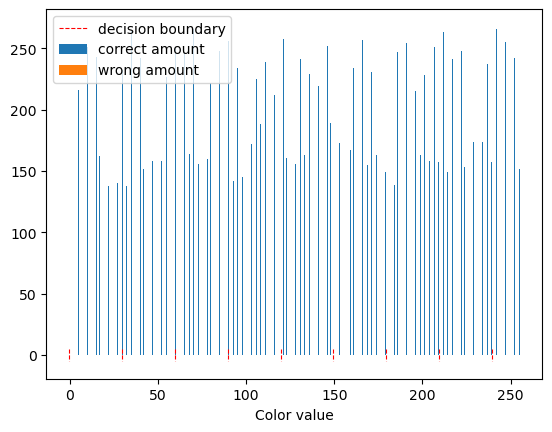

In [11]:
def make_graph(num_correct, total, dataset, critical_values=[150-0.5], buckets=100):
    num_wrong = total - num_correct
    width = 0.4
    labels = [int(x) for i, x in enumerate(np.linspace(*dataset.color_range, buckets))]
    plt.bar(labels, num_correct, width, label="correct amount")
    plt.bar(labels, num_wrong, width, bottom=num_correct, label="wrong amount")
    plt.vlines(critical_values, 5, -5, 
               linewidth=0.8, colors="r", label="decision boundary",
               linestyles="dashed")
    plt.legend()
    plt.xlabel("Color value")
    plt.show()
make_graph(_num_correct, _total, valid_set,   # with .eval(), looks good
           critical_values=[x-0.5 for x in critical_color_values]) 

In [14]:
small_net.eval() # very important!
with torch.no_grad():
    test_index = 987_652  # results seem pretty dependent on image, especially in small-color regimes
    counterfactual_color_values = np.linspace(0, 255, 255) # probably because bad batchnorm estimates
    responses = []
    for color in counterfactual_color_values:
        np.random.seed(test_index)
        generated_img, lbl, __ = valid_set.generate_one(set_color=color)
        generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
        generated_img = torch.tensor(generated_img).to(device).float()
        response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
        responses.append(np.squeeze(response))

/tmp/ipykernel_210007/1976667387.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()


In [59]:
def plot_responses(resp, colors, title):
    resp = np.arcsinh(np.array(resp))
    for output_logit in range(resp.shape[1]):
        plt.plot(colors, resp[:, output_logit], label=f"class {output_logit}")
    plt.legend()
    plt.xlabel("Color value")
    plt.ylabel("Network output logit")
    plt.title(title)
    plt.vlines(critical_color_values, np.min(resp), np.max(resp), linewidth=0.8,
               colors="r", label="decision boundary",
               linestyles="dashed") # with .eval() works well

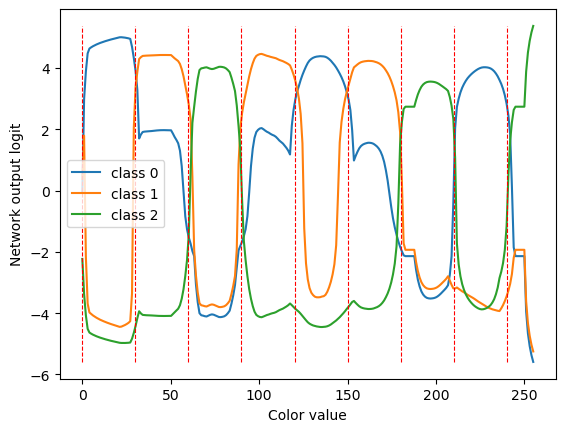

In [15]:
plot_responses(responses, counterfactual_color_values, "")
#i ncreas esize of training set and roughness (mean squared grad across img or pixelvalues) should go down, meght be overfitting (double deep descent)
#  -> could be causing decrease in quality of FD maps
# to be expected

In [7]:
@torch.no_grad()
def finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior):
    num_iters = 20 # sample 20 values evenly spaced
    cuda_stacked_img = torch.tensor(stacked_img).to(device)
    if dataset.num_classes == 2:
        class_multiplier = 1 if target_class == 1 else -1 
        baseline_activations = class_multiplier*model(cuda_stacked_img, logits=True)
    else:
        baseline_activations = model(cuda_stacked_img)[:, target_class]
    largest_slope = np.zeros(stacked_img.shape[0])  # directional finite difference?
    slices = np.index_exp[np.arange(stacked_img.shape[0]), channel, locations[:, 0], locations[:, 1]]
    if values_prior is None:
        values_prior = np.linspace(5, 250, stacked_img.shape[0]) # uniform distribution assumption
    elif isinstance(values_prior, list):
        values_prior = np.expand_dims(np.asarray(values_prior), 1)
    num_loops = 1 if unfairness == "very unfair" else len(values_prior)
    for i in range(num_loops):
        shift_img = stacked_img.copy()
        # shifting method
        if unfairness in ["fair", "unfair"]:
            shift_img[slices] = values_prior[i]+0.01  # add tiny offset to "guarantee" non-zero shift
        elif unfairness in ["very unfair"]:
            critical_value_dists = shift_img[slices] - values_prior
            closest = np.argmin(abs(critical_value_dists), axis=0) # find closest class boundary
            shift_img[slices] = 0.01 + np.choose(closest, values_prior) - 10*np.sign(np.choose(closest, critical_value_dists))
        
        actual_diffs = shift_img[slices] - stacked_img[slices]  
        img_norm = torch.tensor(shift_img).to(device) # best is no normalization anyway
        if dataset.num_classes == 2:
            activations = class_multiplier*model(img_norm, logits=True)
        else:
            activations = model(img_norm)[:, target_class]
        activation_diff = (activations - baseline_activations).cpu().numpy().squeeze()
        finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
        largest_slope = np.where(abs(finite_difference) > abs(largest_slope), finite_difference, largest_slope)
    return largest_slope      

def finite_differences_map(model, dataset, target_class, img, unfairness="fair", values_prior=None):
    # generate a saliency map using finite differences method (iterate over colors)
    model.eval()
    batch_size = 32  # check batch_size num pixel positions in parallel
    im_size = dataset.size
    #img = img.astype(np.float32)/255. # normalization handled later
    values_x = np.repeat(np.arange(im_size), im_size)
    values_y = np.tile(np.arange(im_size), im_size)
    indices = np.stack((values_x, values_y), axis=1)
    stacked_img = np.repeat(np.expand_dims(img, 0), batch_size, axis=0)
    stacked_img = np.transpose(stacked_img, (0, 3, 1, 2)).astype(np.float32) # NCHW format
    img_heat_map = np.zeros_like(img)
    for channel in range(dataset.channels):
        for k in tqdm(range(0, im_size*im_size, batch_size)):
            actual_batch_size = min(batch_size, im_size*im_size-k+batch_size)
            locations = indices[k:k+batch_size]
            largest_slopes = finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior)
            img_heat_map[locations[:,0], locations[:,1], channel] = largest_slopes
    return img_heat_map#.sum(axis=2)  # linear approximation aggregation?

In [10]:
np.random.seed(500_001)
explain_img, label, *_ = valid_set.generate_one()
heat_map = finite_differences_map(small_net, valid_set, label.argmax(), explain_img)

In [58]:
def plt_grid_figure(grid, titles=None, colorbar=True, cmap=None, transpose=False, hspace=-0.4):      
    np_grid = np.array(grid).squeeze()
    if len(np_grid.shape) != 4:
        np_grid = np.expand_dims(np_grid, 0)
    if transpose:
        np_grid = np_grid.T
        
    if cmap is None:
        cmap = "bwr"
    nrows, ncols = np_grid.shape[0], np_grid.shape[1]
    im_size = np_grid.shape[2]
    fig = plt.figure(figsize=(4/128*im_size*ncols, 5/128*im_size*nrows))
    gridspec = fig.add_gridspec(nrows, ncols, hspace=hspace)
    axes = gridspec.subplots(sharex="col", sharey="row")
    if len(axes.shape) == 1:
        axes = np.expand_dims(axes, 0)
    print(np_grid.shape, nrows, ncols)
    for i, row in enumerate(np_grid):
        for j, img in enumerate(row):
            if j == 0: # assume explain_img is the first thing
                im = axes[i,j].imshow(img, cmap="gray")
            else:
                img_max = np.max(abs(img))
                if cmap != "gray":
                    im = axes[i,j].imshow(img, cmap=cmap, interpolation="nearest", vmax=img_max, vmin=-img_max)
                else:
                    axes[i,j].imshow(img, cmap=cmap)
                if colorbar:
                    plt.colorbar(im, pad=0, fraction=0.048)
            if titles and i == 0:
                axes[i,j].set_title(titles[j])
    plt.show()

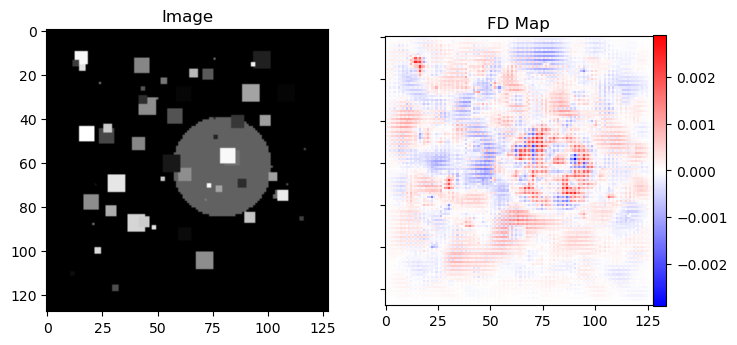

In [279]:
plt_grid_figure([explain_img, heat_map], titles=["Image", "FD Map"])

In [283]:
image_ids = [20_000, 25_000, 30_000, 600_000, 600_001]
heat_maps = []
explain_imgs = []
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, *__ = valid_set.generate_one()
    heat_map_i = finite_differences_map(small_net, valid_set, target_i.argmax(), explain_img_i)
    heat_maps.append(heat_map_i)
    explain_imgs.append(explain_img_i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:28<00:00, 17.91it/s]


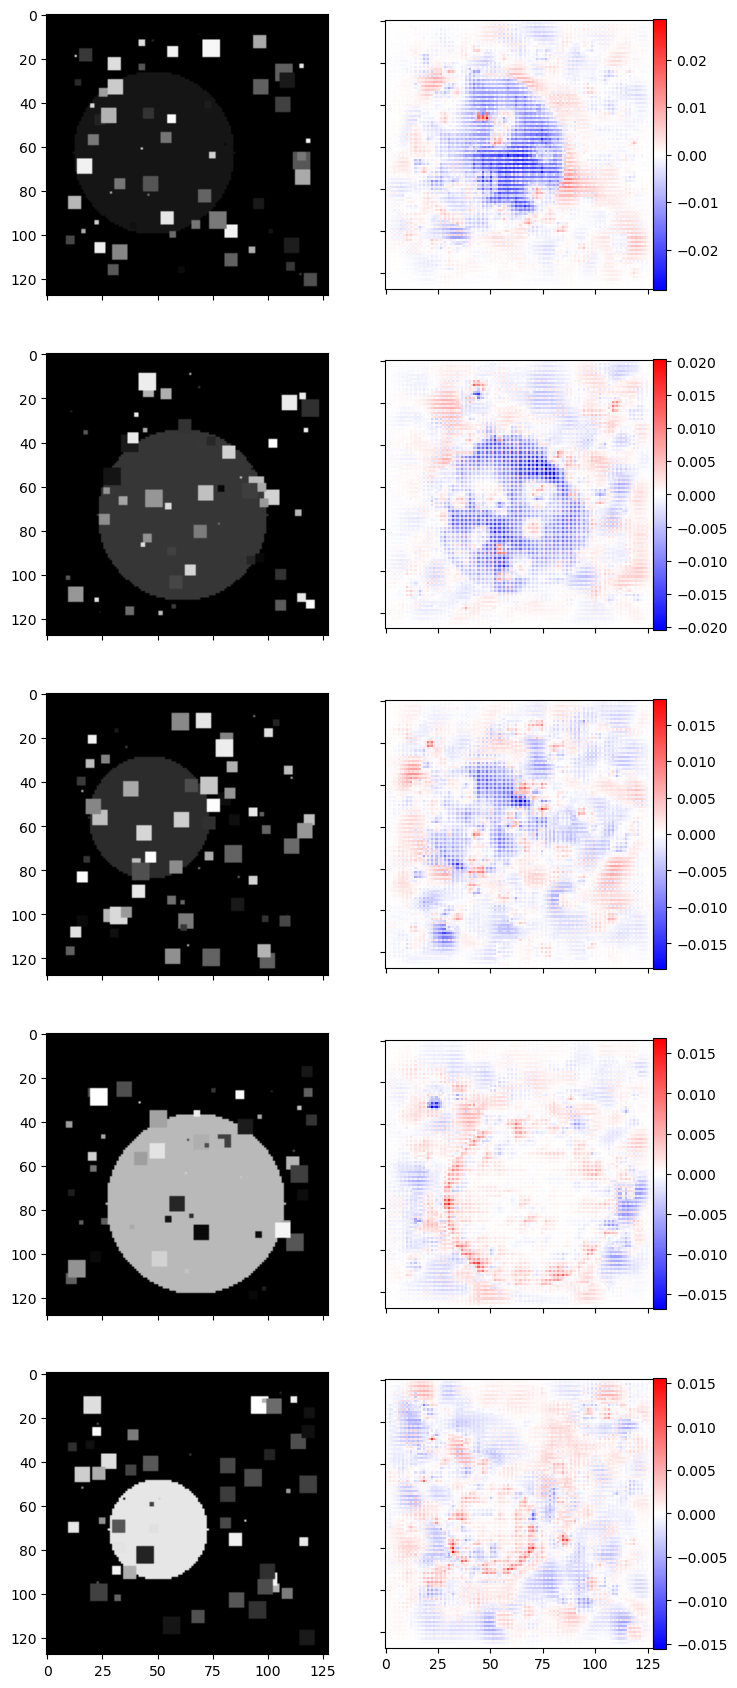

In [291]:
plt_grid_figure([explain_imgs, heat_maps], transpose=True, colorbar=True)

In [56]:
def random_pixels_response(num_pixels, one_class=True):
    small_net.eval() # very important!
    test_index = 987_652  # results seem pretty dependent on image, especially in small-color regimes
    np.random.seed(test_index)
    generated_img, lbl, color, size, pos  = valid_set.generate_one()
    generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
    
    np.random.seed(int(time.time()/np.pi))
    selected_pixels = np.random.randint(0, valid_set.size, (num_pixels, 2))
    num_inside = 0
    for p in selected_pixels:
        if np.linalg.norm(p-pos) < size:
            num_inside += 1
    print(f"Percent of random inside circle: {num_inside/num_pixels*100.}")
    
    counterfactual_color_values = np.linspace(0, 255, 255) # probably because bad batchnorm estimates
    responses = []
    with torch.no_grad():
        for color in counterfactual_color_values:
            generated_img[0, 0, selected_pixels[:,0], selected_pixels[:,1]] = color
            tensor_img = torch.tensor(generated_img).to(device).float()
            response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
            if one_class:
                responses.append(np.expand_dims(np.squeeze(response[:,lbl.argmax()]), 0))
            else:
                responses.append(np.squeeze(response))
    plot_responses(responses, counterfactual_color_values, "Randomly selected pixels")
    
def circle_pixels_response(num_pixels, one_class=True):
    small_net.eval() # very important!
    test_index = 987_652 
    np.random.seed(test_index)  # generate image
    generated_img, lbl, color, size, pos = valid_set.generate_one()
    generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
    
    np.random.seed(int(time.time()/np.pi))
    angle = np.random.uniform(0,2*np.pi, num_pixels)
    radii = np.random.uniform(0, size, num_pixels)
    selected_pixels = np.zeros((num_pixels, 2))
    selected_pixels[:,0] = pos[0][0] + np.cos(angle)*radii
    selected_pixels[:,1] = pos[0][1] + np.sin(angle)*radii
    selected_pixels = np.round(selected_pixels).astype(np.int64)
    
    counterfactual_color_values = np.linspace(0, 255, 255) # probably because bad batchnorm estimates
    responses = []
    with torch.no_grad():
        for color in counterfactual_color_values:
            generated_img[0, 0, selected_pixels[:,0], selected_pixels[:,1]] = color
            tensor_img = torch.tensor(generated_img).to(device).float()
            response = small_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
            if one_class:
                responses.append(np.expand_dims(np.squeeze(response[:,lbl.argmax()]), 0))
            else:
                responses.append(np.squeeze(response))
    plot_responses(responses, counterfactual_color_values, "Pixels inside circle")
    
def both_pixels_response(num_pixels, one_class):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    circle_pixels_response(num_pixels, one_class=one_class)
    plt.subplot(1,2,2)
    random_pixels_response(num_pixels, one_class=one_class)

Percent of random inside circle: 21.0


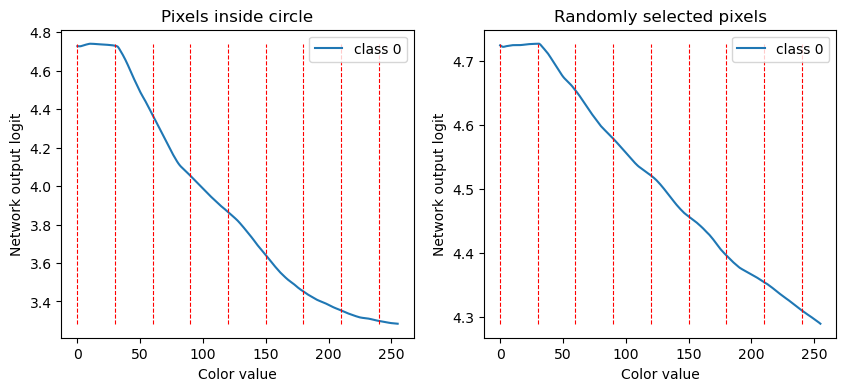

In [72]:
both_pixels_response(100, True)
# deeper layers = more ability to do step function
# conv layer = not be able to do step function
# different pxiles have different jobs, display graph of a bunch of pixels at once
# if theory is correct, we would have a bunch of clutter, but the average would converge to the 
# decision boundary
# mask out everything but 1 pixel, and train on that too
# vector value might be ok
# want it to be beyond edge detection( add color detection)

What if we run the same experiment, but cheat with a prior on pixel values that we know *should* be informative to the output logit, namely values closest to the decision boundary?

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, conv_layers, img_shape, path, fc_layers=[], embed_size=128):
        super().__init__()
        self.path = path  # for saving and loading
        
        enc_layers1 = []  
        enc_layers2 = []
        enc_maxpools = []
        enc_batchnorms1 = []
        enc_batchnorms2 = []
        
        dec_layers1 = []  
        dec_layers2 = []
        dec_maxpools = []  # should be maxunpools
        dec_batchnorms1 = []
        dec_batchnorms2 = []
        
        is_resid = []        
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            is_resid.append(l[2] == 1 and channels == l[0])
            
            if l[2] > 1:
                img_size = (img_size-l[2])//l[2]+1
                print(img_size)
                enc_maxpools.append(nn.MaxPool2d(l[2], return_indices=True))
                dec_maxpools.insert(0, nn.MaxUnpool2d(l[2]))
            else:
                enc_maxpools.append(None)
                dec_maxpools.insert(0, None)
                
            enc_layers1.append(nn.Conv2d(channels, l[0], l[1], padding="same"))
            enc_batchnorms1.append(nn.BatchNorm2d(l[0])) 

            dec_layers2.insert(0,nn.ConvTranspose2d(l[0], channels, l[1], padding=l[1]//2))
            dec_batchnorms2.insert(0,nn.BatchNorm2d(channels)) 

            channels = l[0]
            
            enc_layers2.append(nn.Conv2d(channels, channels, l[1], padding="same"))
            enc_batchnorms2.append(nn.BatchNorm2d(channels))

            dec_layers1.insert(0,nn.ConvTranspose2d(channels, channels, l[1], padding=l[1]//2))
            dec_batchnorms1.insert(0,nn.BatchNorm2d(channels)) 
            
        self.final_flat_shape = channels*img_size*img_size
        self.final_img_shape = [channels, img_size, img_size]
        self.embed_size = embed_size
        
        enc_fully_connected = []
        dec_fully_connected = []
        extended_fc_layers = fc_layers.copy()
        extended_fc_layers.insert(0, self.final_flat_shape)
        extended_fc_layers.append(embed_size)
        for fc_prev, fc_next in zip(extended_fc_layers, extended_fc_layers[1:]):
            enc_fully_connected.append(nn.Linear(fc_prev, fc_next))
            dec_fully_connected.insert(0,nn.Linear(fc_next, fc_prev))
            
        self.enc_layers1 = nn.ModuleList(enc_layers1)
        self.enc_layers2 = nn.ModuleList(enc_layers2)
        self.enc_maxpools = nn.ModuleList(enc_maxpools)
        self.enc_batchnorms1 = nn.ModuleList(enc_batchnorms1)
        self.enc_batchnorms2 = nn.ModuleList(enc_batchnorms2)
        self.enc_fully_connected = nn.ModuleList(enc_fully_connected)
        
        self.dec_layers1 = nn.ModuleList(dec_layers1)
        self.dec_layers2 = nn.ModuleList(dec_layers2)
        self.dec_maxpools = nn.ModuleList(dec_maxpools)
        self.dec_batchnorms1 = nn.ModuleList(dec_batchnorms1)
        self.dec_batchnorms2 = nn.ModuleList(dec_batchnorms2)
        self.dec_fully_connected = nn.ModuleList(dec_fully_connected)

        self.enc_is_resid = is_resid
        self.dec_is_resid = reversed(is_resid)
        
        iter_names = ["layers1", "layers2", "maxpools", "batchnorms1", "batchnorms2", "is_resid"]
        self.enc_iter = list(zip(*[getattr(self, "enc_"+name) for name in iter_names]))
        self.dec_iter = list(zip(*[getattr(self, "dec_"+name) for name in iter_names]))
        
    def net_block(self, x, indices, block_name):
        conv_iter = getattr(self, block_name + "_iter")
        fc_iter = getattr(self, block_name + "_fully_connected")

        if block_name == "dec":
            for i, fc_layer in enumerate(fc_iter):
                x = F.relu(fc_layer(x))
            x = torch.reshape(x, (-1,*self.final_img_shape))
#         print(x.shape, block_name, "pre-conv", type(conv_iter), next(conv_iter))
        #print([t.shape if t is not None else t for t in indices])
        for i, (conv1, conv2, maxpool, batch_norm1, batch_norm2, is_resid) in enumerate(conv_iter):
            x_conv1 = F.relu(batch_norm1(conv1(x)))
#             if block_name == "dec":
#                 print("DEC", i, type(indices[i]), maxpool)
            if maxpool is not None:
                if block_name == "enc":
                    x_conv1, indices_layer = maxpool(x_conv1)
                    #print(x.shape, conv1, indices_layer.shape)
                    indices.insert(0,indices_layer)
                else:
                    #print(x.shape, maxpool, i, type(indices[i-1]), type(indices[i]), type(indices[i+1]))
                    x_conv1 = maxpool(x_conv1, indices[i])
            else:
                if block_name == "enc":
                    indices.insert(0,None)
                    #print(x.shape, conv1)
                    
            if block_name == "dec" and i == len(conv_iter)-1:
                x_conv2 = F.relu(conv2(x_conv1))
            else:
                x_conv2 = F.relu(batch_norm2(conv2(x_conv1)))
                
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block
          #  print(x.shape, block_name, "conv_mid", i)
#         print(x.shape, block_name, "post_conv")
        if block_name == "enc":
            x = torch.flatten(x, 1)
            for i, fc_layer in enumerate(fc_iter):
                x = fc_layer(x)
                if i != len(fc_iter) - 1:
                    x = F.relu(x)
        return x    
    
    def encode(self, x, indices): # due to the symmetry of decoding/encoding, we can do this nicely
        return self.net_block(x, indices, "enc")
    
    def decode(self, z, indices): # => this implementation means the output is ReLU'd
        return self.net_block(z, indices, "dec")

    def forward(self, x):
        save_indices = []
        #print(save_indices, x.shape, "pre anything")
        z = self.encode(x, save_indices)  # write to save_indices
        return self.decode(z, save_indices) # read from save_indices
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if optim is not None:
            save_dict = {}
            save_dict["model"] = self.state_dict()
            save_dict["optim"] = optim.state_dict()
        else:
            save_dict = self.state_dict()
        torch.save(save_dict, path)
    
    def load_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if not os.path.exists(path):
            return
        load_dict = torch.load(path)
        if "model" in load_dict:
            if optim is not None:
                optim.load_state_dict(load_dict["optim"]) 
            self.load_state_dict(load_dict["model"])
        else:
            self.load_state_dict(load_dict)

In [6]:
def autoenc_train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    for epoch in range(epochs):
        epoch_tr_loss = 0.0
        net.train()
        for i, sample in tqdm(enumerate(train_loader)):
            imgs = sample["image"].to(device, non_blocking=False).float()
            optimizer.zero_grad()
            outputs = net(imgs)  # should be close to the image
            batch_loss = loss(outputs, imgs)  # L2 loss of reconstruction
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        epoch_va_loss = 0.0
        net.eval()
        with torch.no_grad():
            for i, sample in enumerate(valid_loader):
                imgs = sample["image"].to(device).float()
                outputs = net(imgs)
                epoch_va_loss += loss(outputs, imgs).item()
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, tr_loss: {epoch_tr_loss}')
        if not va_losses or epoch_va_loss < min(va_losses):
            net.save_model_state_dict(optim=optimizer)
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
    return va_losses, tr_losses

In [9]:
auto_enc = AutoEncoder([[16, 7, 1],  # num_channels (input and output), kernel_size, max_pool kernel
                        [32, 3, 2],  # make sure to change the batch size before working with this
                        [32, 3, 2],
                        [64, 3, 2],
                        [64, 3, 2],
                        [128, 3, 2],
                        [128, 3, 1]], [128, 128, 1], "auto_enc_greyscale_no_norm.dict",
                        fc_layers=[], embed_size=256).to(device)
auto_enc_loss = nn.MSELoss()
auto_enc_optim = torch.optim.Adam(auto_enc.parameters())
print(auto_enc.num_params())
auto_enc.load_model_state_dict(optim=auto_enc_optim)

64
32
16
8
4
2437475


In [8]:
results = autoenc_train(auto_enc, auto_enc_optim, auto_enc_loss, 200)

7813it [07:12, 18.07it/s]


Epoch 1: va_loss: 8217.030039787292, tr_loss: 107249.96073818207


7813it [07:13, 18.02it/s]


Epoch 2: va_loss: 8231.574384689331, tr_loss: 107127.59861660004


7813it [07:13, 18.01it/s]


Epoch 3: va_loss: 8302.732808113098, tr_loss: 106185.07247066498


7813it [07:13, 18.01it/s]


Epoch 4: va_loss: 8068.349966049194, tr_loss: 106060.7579536438


7813it [07:13, 18.02it/s]


Epoch 5: va_loss: 8750.747941970825, tr_loss: 105775.96369552612


7813it [07:13, 18.04it/s]


Epoch 6: va_loss: 8667.275568008423, tr_loss: 106637.77749347687


7813it [07:13, 18.04it/s]


Epoch 7: va_loss: 8726.136813163757, tr_loss: 106153.54279708862


7813it [07:12, 18.05it/s]


Epoch 8: va_loss: 8549.92879486084, tr_loss: 106031.88631916046


7813it [07:12, 18.05it/s]


Epoch 9: va_loss: 8065.889623641968, tr_loss: 105007.08027744293


7813it [07:12, 18.06it/s]


Epoch 10: va_loss: 9705.0608253479, tr_loss: 104697.31934070587


7813it [07:13, 18.04it/s]


Epoch 11: va_loss: 8682.17223072052, tr_loss: 104279.04913711548


7813it [07:13, 18.04it/s]


Epoch 12: va_loss: 8089.148988723755, tr_loss: 105521.57038211823


7813it [07:13, 18.04it/s]


Epoch 13: va_loss: 8802.193824768066, tr_loss: 104876.60557746887


7813it [07:12, 18.06it/s]


Epoch 14: va_loss: 8141.492918968201, tr_loss: 104218.97581481934


7813it [07:12, 18.08it/s]


Epoch 15: va_loss: 9452.620968818665, tr_loss: 103595.87424373627


7813it [07:12, 18.04it/s]


Epoch 16: va_loss: 8151.92294216156, tr_loss: 103081.12366294861


7813it [07:13, 18.04it/s]


Epoch 17: va_loss: 8353.137256622314, tr_loss: 101911.18340110779


7813it [07:12, 18.06it/s]


Epoch 18: va_loss: 7898.888030052185, tr_loss: 101600.32297706604


7813it [07:12, 18.08it/s]


Epoch 19: va_loss: 8749.352096557617, tr_loss: 101926.49405288696


7813it [07:12, 18.08it/s]


Epoch 20: va_loss: 8141.450106620789, tr_loss: 102391.98520088196


7813it [07:12, 18.06it/s]


Epoch 21: va_loss: 8786.254071235657, tr_loss: 102626.93523693085


7813it [07:12, 18.06it/s]


Epoch 22: va_loss: 8992.60755443573, tr_loss: 101975.43817424774


7813it [07:12, 18.05it/s]


Epoch 23: va_loss: 8084.806151390076, tr_loss: 101062.17279720306


7813it [07:12, 18.07it/s]


Epoch 24: va_loss: 7974.3151388168335, tr_loss: 100894.54763031006


7813it [07:12, 18.08it/s]


Epoch 25: va_loss: 7830.368803024292, tr_loss: 100514.00983047485


7813it [07:12, 18.07it/s]


Epoch 26: va_loss: 7736.203797340393, tr_loss: 100192.22732162476


7813it [07:12, 18.05it/s]


Epoch 27: va_loss: 9188.502497673035, tr_loss: 99803.7147321701


7813it [07:12, 18.05it/s]


Epoch 28: va_loss: 7558.539626121521, tr_loss: 99165.04802513123


7813it [07:12, 18.07it/s]


Epoch 29: va_loss: 9022.792490005493, tr_loss: 99895.722281456


7813it [07:12, 18.08it/s]


Epoch 30: va_loss: 9845.719109535217, tr_loss: 99040.65975475311


7813it [07:12, 18.07it/s]


Epoch 31: va_loss: 7663.700464248657, tr_loss: 99004.62228012085


7813it [07:12, 18.05it/s]


Epoch 32: va_loss: 7820.187379837036, tr_loss: 98380.82447910309


7813it [07:12, 18.05it/s]


Epoch 33: va_loss: 7846.529040336609, tr_loss: 98102.76927661896


7813it [07:12, 18.07it/s]


Epoch 34: va_loss: 7588.887351989746, tr_loss: 96920.16131019592


7813it [07:12, 18.07it/s]


Epoch 35: va_loss: 7623.973030090332, tr_loss: 97064.92202186584


7813it [07:12, 18.05it/s]


Epoch 36: va_loss: 8102.585923194885, tr_loss: 97363.63968467712


7813it [07:13, 18.04it/s]


Epoch 37: va_loss: 8272.544845581055, tr_loss: 96655.54843711853


7813it [07:12, 18.05it/s]


Epoch 38: va_loss: 7697.384886741638, tr_loss: 97455.99957370758


7813it [07:12, 18.07it/s]


Epoch 39: va_loss: 8159.738528251648, tr_loss: 98728.24322605133


7813it [07:12, 18.07it/s]


Epoch 40: va_loss: 7742.114009857178, tr_loss: 98763.34615421295


7813it [07:12, 18.05it/s]


Epoch 41: va_loss: 7847.401907920837, tr_loss: 98028.86460971832


7813it [07:12, 18.05it/s]


Epoch 42: va_loss: 7712.932020187378, tr_loss: 98421.69947624207


7813it [07:12, 18.05it/s]


Epoch 43: va_loss: 7664.171927452087, tr_loss: 98077.50699329376


7813it [07:12, 18.07it/s]


Epoch 44: va_loss: 8043.631983757019, tr_loss: 99329.02902412415


7813it [07:12, 18.07it/s]


Epoch 45: va_loss: 8179.984409332275, tr_loss: 98848.93873786926


7813it [07:12, 18.06it/s]


Epoch 46: va_loss: 8152.240274429321, tr_loss: 98142.3209810257


7813it [07:12, 18.05it/s]


Epoch 47: va_loss: 8040.083236694336, tr_loss: 98265.43020248413


7813it [07:12, 18.06it/s]


Epoch 48: va_loss: 7723.786198616028, tr_loss: 98134.72623062134


7813it [07:12, 18.07it/s]


Epoch 49: va_loss: 7755.562415122986, tr_loss: 97300.75359535217


7813it [07:12, 18.08it/s]


Epoch 50: va_loss: 7570.602373123169, tr_loss: 96581.63520812988


7813it [07:12, 18.06it/s]


Epoch 51: va_loss: 7371.321921348572, tr_loss: 96915.52759838104


7813it [07:12, 18.06it/s]


Epoch 52: va_loss: 7744.209636688232, tr_loss: 96934.48661136627


7813it [07:12, 18.06it/s]


Epoch 53: va_loss: 8822.972655296326, tr_loss: 97189.58608913422


7813it [07:12, 18.06it/s]


Epoch 54: va_loss: 7399.636915206909, tr_loss: 96737.11821174622


7813it [07:12, 18.08it/s]


Epoch 55: va_loss: 8087.701865196228, tr_loss: 96926.73739814758


7813it [07:12, 18.08it/s]


Epoch 56: va_loss: 7519.216099739075, tr_loss: 96361.82005023956


7813it [07:12, 18.06it/s]


Epoch 57: va_loss: 7698.145451545715, tr_loss: 96199.18420410156


7813it [07:12, 18.06it/s]


Epoch 58: va_loss: 7803.095319747925, tr_loss: 96116.5441570282


7813it [07:12, 18.07it/s]


Epoch 59: va_loss: 7735.610312461853, tr_loss: 95306.36257839203


7813it [07:12, 18.08it/s]


Epoch 60: va_loss: 7808.1206407547, tr_loss: 95909.74698734283


7813it [07:12, 18.07it/s]


Epoch 61: va_loss: 7462.675162315369, tr_loss: 94848.47785282135


7813it [07:12, 18.06it/s]


Epoch 62: va_loss: 7368.455676078796, tr_loss: 94971.41654777527


7813it [07:12, 18.06it/s]


Epoch 63: va_loss: 7337.174143791199, tr_loss: 95243.44977283478


7813it [07:12, 18.07it/s]


Epoch 64: va_loss: 13936.729068756104, tr_loss: 95147.02586746216


7813it [07:12, 18.07it/s]


Epoch 65: va_loss: 7347.966369628906, tr_loss: 95316.48051738739


3082it [02:50, 18.08it/s]


KeyboardInterrupt: 

In [14]:
# simple sanity check
auto_enc.eval()
generated_img = valid_set.generate_one()[0]
tensor_img = torch.tensor(np.expand_dims(generated_img,0).transpose(0,3,1,2)).to(device).float()
reconstruction = np.expand_dims(auto_enc(tensor_img).detach().cpu().numpy().squeeze(),-1)

In [15]:
print(reconstruction.mean(), generated_img.mean())

29.079472 29.36566162109375


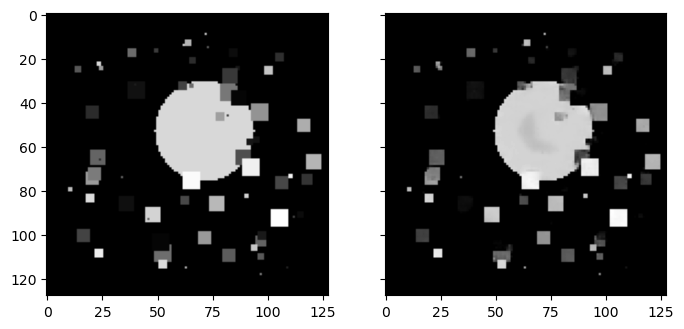

In [16]:
plt_grid_figure([generated_img.squeeze(), reconstruction.squeeze()], colorbar=False, cmap="gray", transpose=False)

(13.97023209202145, 0.007874015748031496, 0.027855494659241656)
(1.0610568358577102, 0.05905511811023622, 0.9293417726873536)


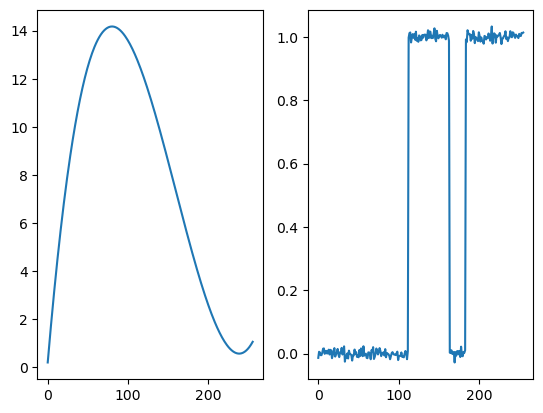

In [51]:
def is_indicator(outpts, inputs):  # assume values are equally spaced
    outpt_diffs = outpts[:-1] - outpts[1:]
    input_diffs = inputs[:-1] - inputs[1:]
    deriv = outpt_diffs/input_diffs
    avg_abs_grad = np.where(abs(deriv) < 1e-3, 1, 0).mean()  # for linear funcs, output_range = m*x_range
    grad_range = np.max(abs(deriv)) - np.min(abs(deriv))
    output_range = np.max(outpts) - np.min(outpts) # avg_square_grad = m**2/x_range
    return output_range, avg_abs_grad, grad_range/output_range
    
def random_polynomial(num_pts, degree, pts_range, inpts):
    input_pts = np.random.uniform(inpts.min(), inpts.max(), num_pts)
    input_pts = np.concatenate((input_pts, [0,255]))
    output_pts = np.random.uniform(*pts_range, num_pts)
    output_pts = np.concatenate((output_pts, np.random.uniform(*pts_range, 2)))
    return np.poly1d(np.polyfit(input_pts, output_pts, degree))(inpts)

def random_indicator(jumps_range, inputs):
    num_jumps = np.random.randint(*jumps_range)
    jumps = np.sort(np.random.uniform(inputs.min(), inputs.max(), num_jumps))
    noise = np.random.normal(loc=0, scale=0.01, size=(len(inputs)))
    return np.digitize(inputs, jumps) % 2 + noise

input_range = np.linspace(0,255,255)
plt.subplot(1,2,1)
poly_results = random_polynomial(4, 3, (-4, 4), input_range)
plt.plot(input_range, poly_results)
plt.subplot(1,2,2)
indic_results = random_indicator((1,5), input_range)
plt.plot(input_range, indic_results)
print(is_indicator(poly_results, input_range))
print(is_indicator(indic_results, input_range))

In [52]:
def baseline_image(encoder_net, img, dataset, target_class, sample_size=1024):
    sample = []
    model.eval()
    while len(sample) != sample_size:
        sampled_img, sampled_label, *_ =  dataset.generate_one()
        if sampled_label.argmax() != target_class:  # only consider sample from other classes
            sample.append(sampled_img)
    im_size = img.shape[0]
    sample = np.array(sample).transpose(0,3,1,2)
    sample_tensor = torch.tensor(sample).to(device).float()
    print(sample_tensor.shape)
    batch_size = 32
    encoding_vectors = []
    encoding_indices = []
    for k in range(0, sample_size, batch_size):
        selected = sample_tensor[k:min(k+batch_size, sample_size)]
        encodings, indices = encoder_net.encode(selected)
        encoding_vectors.append(encodings.detach().cpu().numpy())
        encoding_indices.append(indices.detach().cpu().numpy())
    img_tensor = torch.tensor(img.transpose(2,0,1)).unsqueeze(0).to(device)
    img_enc, img_indices = encoder_net.encode(img_tensor)
    img_enc = img_enc.detach().cpu().numpy()
    encoding_vectors = np.array(encoding_vectors)
    diffs = np.linalg.norm(encoding_vectors - img_enc, axis=1)
    min_diff = np.argmin(diffs)
    closest_img = sample[min_diff]
    # now, do a binary search on alpha values for the closest value that is the other class
    # interpolation on "indices" can be done with ???
    alpha_bin_search(img, closest_img, classifier, auto_encoder, img_enc, closest_enc)

# Model Optimization Stuff

In [31]:
small_net.eval()
generated_img = torch.tensor(valid_set.generate_one()[0].transpose(2,0,1)).unsqueeze(0).to(device).float()
profile_model = ProfileExecution(small_net)
for _ in tqdm(range(1000)):
    profile_model.forward(generated_img)
profile_model.clean_up()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1124.56it/s]


In [32]:
total = sum(stats.values())  # --> gave 3x speed! (Fast and Accurate Model scaling?)
for k,v in sorted(stats.items(), key=lambda x: x[0]):    # --> the 3x speedup caused underfitting though, so switched to 2x
    print(k,(100.*v/total))

fn-batch_norms1_0 5.0193388887053265
fn-batch_norms1_1 4.8895368547370275
fn-batch_norms1_2 4.8319039632435885
fn-batch_norms2_0 4.936572477122364
fn-batch_norms2_1 4.859898902239945
fn-batch_norms2_2 4.874240556237905
fn-conv_layers1_0 8.739666521468697
fn-conv_layers1_1 8.832536889769198
fn-conv_layers1_2 8.865867121647911
fn-conv_layers2_0 10.358396027760826
fn-conv_layers2_1 8.848897888372376
fn-conv_layers2_2 10.155740252339907
fn-fully_connected_0 8.182537589459184
fn-fully_connected_1 6.604866066895724
